<center><h1 style="font-size:40px;">Regression</h1></center>

Welcome to the third lab in the Deep learning course! In this lab we will continue to take a look at four parts for MLP regression;
* Introduction for setup and train an MLP
* Model selection for classification
* Impact of overfitting in validation performance 
* Avoid overfitting for a regression problem

The lab includes different datasets, both synthetic and real for regression task. 
The first part of the lab uses two different synthetic regression problems. The **regr1()** synthetic dataset is a two-dimensional dataset with linear and non-linear relationships between the input features and the output value. It is a good benchmark dataset for regression models, as it is challenging and realistic. The **generate_piecewise_linear_data()** function generates a synthetic dataset with piecewise linear relationships between the input features and the output value with varying amount of noise for each piece. 

All **Tasks** include **TODO's** these are expected to be done before the deadline for this lab. The **Tasks** also include question(s), which should be answered and included in the report. Some sections do not contain any **TODO's** but are good to understand.

Good luck!

---

## Intro to regression


The regression task is to learn a function f that maps from a set of input features X to a continuous output value y. The input features X can be either real-valued or categorical. The output value y is a real-valued number.

$$
y = f(X) + \epsilon
$$

The regression model is trained on a set of training data points, where the input features and the output values are known. The model learns to identify the relationship between the input features and the output values, and then uses this relationship to predict the output value for new input features.



## Necessary Imports 

In [1]:
# select gpu by index in case of multiple gpus
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!python --version

Python 3.11.5


In [2]:

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import copy

## Let's use GPU if possible

In [3]:
# set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU detected.")
if hasattr(os, 'cpu_count'):
    print("The 'os' module has 'cpu_count' attribute.")
    # You can use os.cpu_count() to get the number of CPUs
else:
    print("The 'os' module does not have 'cpu_count' attribute.")

cuda:0
GPU is available.
The 'os' module has 'cpu_count' attribute.


## Dataset generator

In [4]:
class MLPData:
    """
    This class will manage all the dataset related functions for this lab.
    Please take the time do go through the code and try to understand how each point is generated
    """

    @staticmethod
    def regr1(N, v=0):
        """data(samples, features)

        :param N: param v:  (Default value = 0)
        :param v: Default value = 0)

        """
        data = np.empty(shape=(N, 2), dtype=np.float64)

        uni = lambda n: np.random.uniform(0, 1, n)
        norm = lambda n: np.random.normal(0, 1, n)
        noise = lambda n: np.random.normal(0, 1, (n,))
        data[:, 0] = norm(N)
        data[:, 1] = uni(N)

        tar = 10 * data[:, 0] + np.sin(20 * np.pi * data[:, 1])
        std_signal = np.std(tar)
        no = noise(N)
        tar = tar + v * std_signal * no
        return data, tar

    @staticmethod
    def generate_piecewise_linear_data(n_samples, n_segments, stocastic_noise=False):
        """
        Generates a piecewise linear dataset with n_segments segments.
        :param n_samples: Number of samples to generate
        :param n_segments: Number of segments to use
        :return: x, y

        """
        x = torch.rand(n_samples) * 10  # Generate random input values between 0 and 10
        y = torch.zeros(n_samples)

        segment_length = 10 / n_segments
        for i in range(n_segments):
            mask = (x >= i * segment_length) & (x < (i + 1) * segment_length)
            slope = torch.randn(1) * 2  # Random slope for each segment
            if stocastic_noise:
                noise = torch.randn(sum(mask)) * (0.5 + i * torch.randn(1))
            else:
                noise = torch.randn(sum(mask)) * (
                    0.5 + i * 0.2
                )  # Heteroscedastic noise
            y[mask] = slope * x[mask] + noise

        return x, y

Do not forget to instanciate an object of the above class for you to be able to generate dataset on the fly!

In [5]:
synthetic_datasets = MLPData()

Let's see how each dataset looks like! 

In [6]:
def data_distribution(imgs, shape=(2, 2)):
    """Plot scatter distribution for a list of images."""
    f, axs = plt.subplots(*shape, figsize=(10, 10))
    axs = axs.flatten()

    if isinstance(imgs, list):
        for idx, ((d, t), ax) in enumerate(zip(imgs, axs)):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(f"Plot number: {idx}")
    elif isinstance(imgs, dict):
        for (key, (d, t)), ax in zip(imgs.items(), axs):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(key)
    plt.show()

In [7]:
## Plotting synthetic datasets
# make sure you understand how the data is generated

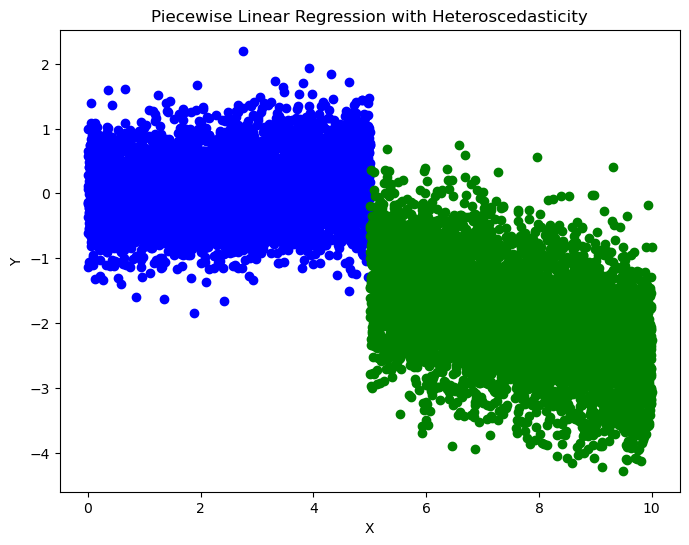

In [8]:
# Generate the synthetic dataset
n_samples = 10000
n_segments = 2
x, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=False
)

# Define colors for each segment
segment_colors = [
    "b",
    "g",
    "r",
    "c",
    "m",
] * (
    n_segments // 5 + 1
)  # Repeat the colors to have enough colors for each segment (up to 5 segments

# Plot the synthetic data with different colors for each segment
plt.figure(figsize=(8, 6))
for i in range(n_segments):
    mask = (x >= i * (10 / n_segments)) & (x < (i + 1) * (10 / n_segments))
    plt.scatter(x[mask], y[mask], label=f"Segment {i+1}", c=segment_colors[i])

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Piecewise Linear Regression with Heteroscedasticity")
plt.show()

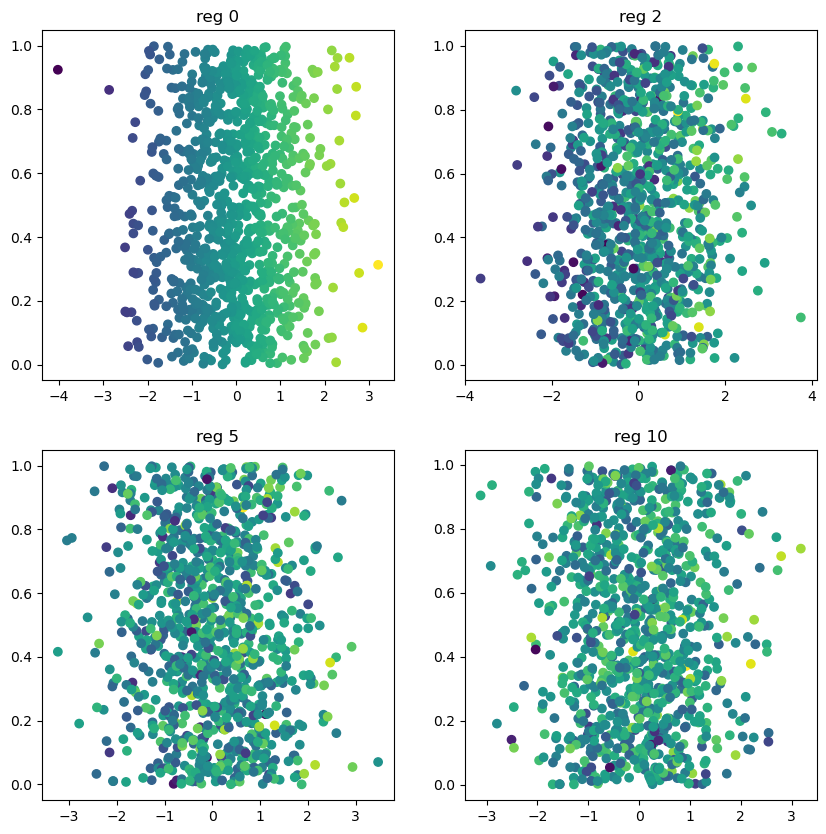

In [9]:
data_distribution(
    {
        "reg 0": MLPData.regr1(1000, v=0),
        "reg 2": MLPData.regr1(1000, v=2),
        "reg 5": MLPData.regr1(1000, v=5),
        "reg 10": MLPData.regr1(1000, v=10),
    },
    shape=(2, 2),
)

## Task 1

**Model definition**

In this lab exercise, you will design a Multi-Layer Perceptron (MLP) for regression. The goal is to create a simple neural network architecture to predict a continuous target variable based on input features. By completing this exercise, you will gain hands-on experience in configuring the architecture of an MLP for regression tasks.

    Task Description:

- Create an MLP architecture for regression.
- Define the input layer, hidden layers, and output layer.
- Configure the input layer to accept input data with dimensions specified as in_dimension.
- Design the hidden layers with num_hidden_layers layers and hidden_nodes neurons in each layer.
- Choose an appropriate activation function, specified as act, for the hidden layers. You can use common activation functions like ReLU (torch.nn.ReLU) for this purpose.
- Configure the output layer to have a linear activation function since this is a regression task.
- Define the output dimension to match your regression problem's requirements (specified as out_dimension).

In [10]:
class NeuralNet(torch.nn.Module):
    def __init__(
        self,
        in_dimension=2,
        hidden_nodes=1,
        num_hidden_layers=1,
        act=torch.nn.ReLU(inplace=True),
        out_dimension=1,
    ):
        """
        in_dimension: number of input data/features
        hidden_nodes: number of neurons in the hidden layer(s)
        num_hidden_layers: number of hidden layers
        act: activation function
        out_dimension: number of output neurons e.g. number of classes
        """
        super(NeuralNet, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(in_dimension, hidden_nodes)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_nodes, hidden_nodes) if i < num_hidden_layers - 1 else nn.Linear(hidden_nodes, out_dimension)
            for i in range(num_hidden_layers)
        ])
        
        # Activation function
        self.activation = act

    def forward(self, x):
        # Forward pass through the layers

        # Input layer
        x = self.input_layer(x)
        x = self.activation(x)

        # Hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)

        # Output layer (linear activation for regression)
        output = x

        return output

## Process the data for training

We need to make tensor from the numpy data generated from ```MLPData``` class and use them to create a PyTorch dataset. For this exercise we will use ```TensorDataset```. To iterate over the dataset, we need a data loader. We will use the default ```DataLoader```. You can find the corresponding documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [here](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

In [11]:
# let's start with 100 points
x, y = synthetic_datasets.regr1(10000)
# simply convert each array to a Tensor
x = torch.Tensor(x)
y = torch.Tensor(y)
# create the TensorDataset
syn2_Pytorch = TensorDataset(x, y)
# create the dataloader.
loader = DataLoader(syn2_Pytorch, batch_size=1024)

# Task 2

Finish the below function. The task at this point is to create a function that is able to train your ```model``` for ```epoch_number``` using ```optimizer```, ```loss``` and ```dataloader```. You can read about optimizer [here](https://pytorch.org/docs/stable/optim.html)

In [12]:
def train_epoch(epoch, optimizer, loss_fn, model, train_loader):
    """
    Trains the model for one epoch using the given training data.

    Args:
        epoch (int): The current epoch number.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
        loss_fn (torch.nn.Module): The loss function used for calculating the loss.
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): The data loader providing training data.

    Returns:
        float: The average loss for the epoch.
    """
    total_loss = 0

    # Set the model to training mode
    model.train()

    for batch_idx, (xi, yi) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(xi).squeeze()
        

        # Calculate the loss
        loss = loss_fn(output, yi)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate the loss for the epoch
        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_epoch_loss = total_loss / len(train_loader)

    return average_epoch_loss

Now that we have a way to trian our model, we need to create an instance of the model and train it. We still need a way to evaluate our model. In this simple datasets, we can try to visualize the decision boundaries. 

We will create one ```helper function```: ```plot_decision_boundary```

In [13]:
def plot_decision_boundary(dataset, y, model, steps=50):
    xmin, xmax = dataset[:, 0].min(), dataset[:, 0].max()
    ymin, ymax = dataset[:, 1].min(), dataset[:, 1].max()
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx_pred, yy_pred = np.meshgrid(x_span, y_span)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.Tensor(model_viz)).float())

    labels_predicted = labels_predicted.detach().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(dataset[:, 0], dataset[:, 1], y)
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        labels_predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="#70b3f0",
    )
    ax.view_init(elev=28, azim=120)
    plt.show()
    model.train()
    return fig, ax

In [14]:
def stats_reg(x, y, model):
    """
    Returns the MSE and CorrCoef for a given dataset and y
    """

    A = ["MSE", "CorrCoeff"]
    model.eval()
    preds = model(x)
    pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
    mse = torch.nn.MSELoss()(preds, y)

    B = [mse.item(), pcorr]

    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")

## Task 3 

### Instantiation
Now the only thing missing to visualize you results is a trained network. **TODO:** Instantiate your model, loss and optimizer below. The choice of loss is critical for the training.  

In [15]:
import torch.optim as optim

# Instantiate your model
# Assuming you have already defined your NeuralNet class
my_model = NeuralNet(in_dimension=2, hidden_nodes=1, num_hidden_layers=1, out_dimension=1)

# Instantiate your loss function
# For regression tasks, Mean Squared Error (MSE) loss is commonly used
critereon = torch.nn.MSELoss()

# Instantiate a suitable optimizer
# For example, you can use Stochastic Gradient Descent (SGD)
learning_rate = 0.01
#optimizer = optim.SGD(my_model.parameters(), lr=learning_rate)
optimizer = Adam(my_model.parameters(), lr=0.001)

### Train the model

Now, our model, loss and optimizer are setup and we are ready to go Training

In [16]:
num_epoch = 100
train_losses = list()
for epoch in range(1, num_epoch + 1):
    epoch_loss = train_epoch(epoch, optimizer, critereon, my_model, loader)
    train_losses.append(epoch_loss)

    if epoch % 3 == 0:
        print(f"Epoch {epoch + 1}/{num_epoch}: Loss = {epoch_loss}")

Epoch 4/100: Loss = 103.05032501220703
Epoch 7/100: Loss = 103.00000076293945
Epoch 10/100: Loss = 102.95691680908203
Epoch 13/100: Loss = 102.91699600219727
Epoch 16/100: Loss = 102.87974853515625
Epoch 19/100: Loss = 102.8449104309082
Epoch 22/100: Loss = 102.81237411499023
Epoch 25/100: Loss = 102.78173370361328
Epoch 28/100: Loss = 102.75287780761718
Epoch 31/100: Loss = 102.72573776245117
Epoch 34/100: Loss = 102.70023651123047
Epoch 37/100: Loss = 102.67628936767578
Epoch 40/100: Loss = 102.65383758544922
Epoch 43/100: Loss = 102.63308486938476
Epoch 46/100: Loss = 102.61375732421875
Epoch 49/100: Loss = 102.5957160949707
Epoch 52/100: Loss = 102.57890548706055
Epoch 55/100: Loss = 102.5632568359375
Epoch 58/100: Loss = 102.54870681762695
Epoch 61/100: Loss = 102.53519592285156
Epoch 64/100: Loss = 102.52267303466797
Epoch 67/100: Loss = 102.51107406616211
Epoch 70/100: Loss = 102.50035095214844
Epoch 73/100: Loss = 102.49044647216797
Epoch 76/100: Loss = 102.48131484985352
Epoch

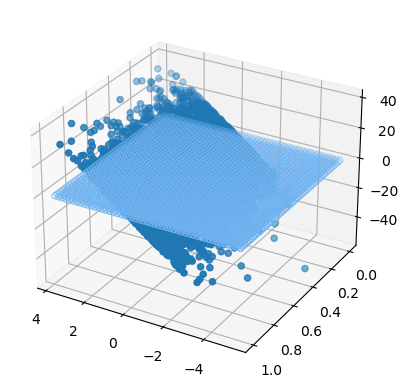

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

In [17]:
plot_decision_boundary(x, y, my_model, steps=50)

In [18]:
stats_reg(x, y, my_model)


 #################### STATISTICS####################

MSE   102.11924743652344
CorrCoeff   [[ 1. nan]
 [nan nan]]

 ##################################################


C:\Users\danie\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\danie\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\danie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Visualize the train losses 

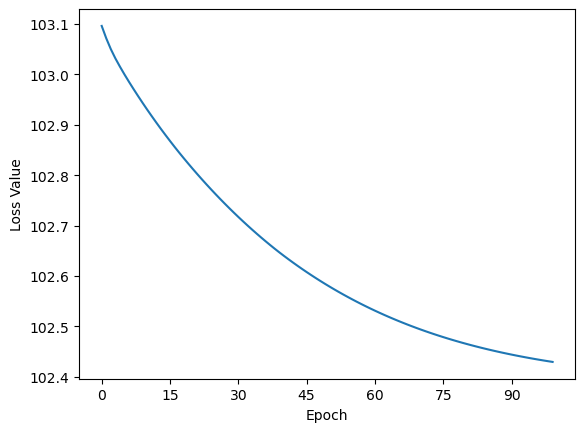

In [19]:
ax = plt.figure().gca()
plt.plot(np.arange(len(train_losses)), train_losses)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.show()

## Model Selection 

A proper training procedure is divided into ```3 splits```: training, validation and test. Generally, for each epoch, training is done on training data, and then a validation is done on the validation data. During validation the model weights are not updated. Best performing model on the validaiton data is selected and saved for final evaluation on test data. 

## Task 4

**TODO:** Split the data to 3 parts, one for training, one for validation and one hold out set for testing. A good starting point can be 70%, 15% and 15% of the dataset respectively for each split

**HINT** you can either do this manually with indexing or use readily available tools e.g. in sklearn

In [20]:
from sklearn.model_selection import train_test_split

x, y = synthetic_datasets.regr1(10000)

# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training, validation, and test sets (70%, 15%, 15%)
x_train, x_temp, y_train, y_temp = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 32

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(valid_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

# Length of data loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Validation loader length: {len(valid_loader)}")
print(f"Test loader length: {len(test_loader)}")

Train dataset length: 7000
Validation dataset length: 1500
Test dataset length: 1500
Train loader length: 219
Validation loader length: 47
Test loader length: 47


## Task 5
**TODO:** Complete the following functions. Run a proper training on each of the synthetic datasets you have created. Discuss the performance of model in report. What could be the reason behind the performance? Feel free to adapt the number of hidden nodes (and possibly the number of hidden layers and epochs)

In [21]:
def validate_epoch(epoch, loss_fn, model, val_loader):
    """
    Validates the model on the validation data for one epoch.

    Args:
        epoch (int): The current epoch number.
        loss_fn (torch.nn.Module): The loss function used for calculating the validation loss.
        model (torch.nn.Module): The neural network model to be evaluated.
        val_loader (torch.utils.data.DataLoader): The data loader providing validation data.

    Returns:
        float: The average validation loss for the epoch.

    This function switches the provided model to evaluation mode, iterates through the
    validation data provided by `val_loader`, computes the forward pass, and calculates
    the validation loss. It then returns the average validation loss for the entire epoch.

    Example:
        >>> loss_fn = torch.nn.MSELoss()
        >>> val_loader = DataLoader(val_dataset, batch_size=32)
        >>> for epoch in range(num_epochs):
        ...     epoch_loss = validate_epoch(epoch, loss_fn, model, val_loader)
        ...     print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss:.4f}")
    """

    total_loss = 0

    # Switch model to evaluation mode
    model.eval()

    with torch.no_grad():
        for batch_idx, (xi, yi) in enumerate(val_loader):
            # Forward pass
            outputs = model(xi)
            
            # Calculate the loss
            loss = loss_fn(outputs, yi)
            
            # Accumulate the total loss
            total_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(val_loader)

    # Print or log validation loss for the epoch
    print(f"Epoch {epoch+1}, Validation Loss: {avg_loss:.4f}")

    return avg_loss


In [22]:
def a_proper_training(num_epochs, model, optimizer, loss_fn, train_loader, val_loader):
    """
    Performs a complete training and validation process for the given model.

    Args:
        num_epochs (int): The number of training epochs.
        model (torch.nn.Module): The neural network model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
        loss_fn (torch.nn.Module): The loss function used for calculating the loss.
        train_loader (torch.utils.data.DataLoader): The data loader providing training data.
        val_loader (torch.utils.data.DataLoader): The data loader providing validation data.

    Returns:
        tuple: A tuple containing the best trained model, a list of training losses for each epoch,
        and a list of validation losses for each epoch.

    This function trains the provided model for the specified number of epochs, monitoring both
    training and validation losses. It also saves the best model based on the lowest validation
    loss achieved during training.

    Example:
        >>> num_epochs = 10
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        >>> loss_fn = torch.nn.MSELoss()
        >>> train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        >>> val_loader = DataLoader(val_dataset, batch_size=32)
        >>> best_model, train_losses, val_losses = a_proper_training(num_epochs, model, optimizer, loss_fn, train_loader, val_loader)
        >>> # After training, you can use the best_model for inference.
    """
    best_val_loss = float('inf')
    best_model = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0.0  # Accumulator for training loss in the current epoch

        for batch_idx, (xi, yi) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(xi).squeeze()
            loss = loss_fn(outputs, yi)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()  # Accumulate the training loss

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        val_loss = validate_epoch(epoch, loss_fn, model, val_loader)
        val_losses.append(val_loss)

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    # Load the best model state before returning
    model.load_state_dict(best_model)

    # Return best model and lists of training and validation losses
    return model, train_losses, val_losses

In [23]:
# Instantiate your model
# Assuming you have already defined your NeuralNet class
my_model = NeuralNet(in_dimension=2, hidden_nodes=1, num_hidden_layers=1, out_dimension=1)

# Instantiate your loss function
# For regression tasks, Mean Squared Error (MSE) loss is commonly used
critereon = torch.nn.MSELoss()

# Instantiate a suitable optimizer
# For example, you can use Stochastic Gradient Descent (SGD)
learning_rate = 0.01
optimizer = Adam(my_model.parameters(), lr=0.001)

In [47]:
best_model, train_losses, val_losses = a_proper_training(
    1000, my_model, optimizer, critereon, train_loader, valid_loader
)

Epoch 1, Validation Loss: 5780.4896
Epoch 2, Validation Loss: 5780.5142
Epoch 3, Validation Loss: 5780.5176
Epoch 4, Validation Loss: 5780.4948
Epoch 5, Validation Loss: 5780.4881
Epoch 6, Validation Loss: 5780.4712
Epoch 7, Validation Loss: 5780.4744
Epoch 8, Validation Loss: 5780.4870
Epoch 9, Validation Loss: 5780.5117
Epoch 10, Validation Loss: 5780.5203
Epoch 11, Validation Loss: 5780.4915
Epoch 12, Validation Loss: 5780.4823
Epoch 13, Validation Loss: 5780.4953
Epoch 14, Validation Loss: 5780.5137
Epoch 15, Validation Loss: 5780.5117
Epoch 16, Validation Loss: 5780.5104
Epoch 17, Validation Loss: 5780.5073
Epoch 18, Validation Loss: 5780.5044
Epoch 19, Validation Loss: 5780.5068
Epoch 20, Validation Loss: 5780.5068
Epoch 21, Validation Loss: 5780.5371
Epoch 22, Validation Loss: 5780.5244
Epoch 23, Validation Loss: 5780.5332
Epoch 24, Validation Loss: 5780.5413
Epoch 25, Validation Loss: 5780.5290
Epoch 26, Validation Loss: 5780.5257
Epoch 27, Validation Loss: 5780.5210
Epoch 28, 

Epoch 237, Validation Loss: 5780.5955
Epoch 238, Validation Loss: 5780.5757
Epoch 239, Validation Loss: 5780.5602
Epoch 240, Validation Loss: 5780.5690
Epoch 241, Validation Loss: 5780.5907
Epoch 242, Validation Loss: 5780.6014
Epoch 243, Validation Loss: 5780.5946
Epoch 244, Validation Loss: 5780.5978
Epoch 245, Validation Loss: 5780.6159
Epoch 246, Validation Loss: 5780.6229
Epoch 247, Validation Loss: 5780.6089
Epoch 248, Validation Loss: 5780.5983
Epoch 249, Validation Loss: 5780.5978
Epoch 250, Validation Loss: 5780.5985
Epoch 251, Validation Loss: 5780.6196
Epoch 252, Validation Loss: 5780.6219
Epoch 253, Validation Loss: 5780.6328
Epoch 254, Validation Loss: 5780.6400
Epoch 255, Validation Loss: 5780.6382
Epoch 256, Validation Loss: 5780.6134
Epoch 257, Validation Loss: 5780.6112
Epoch 258, Validation Loss: 5780.6226
Epoch 259, Validation Loss: 5780.6099
Epoch 260, Validation Loss: 5780.6006
Epoch 261, Validation Loss: 5780.6336
Epoch 262, Validation Loss: 5780.6304
Epoch 263, V

Epoch 474, Validation Loss: 5780.6634
Epoch 475, Validation Loss: 5780.6637
Epoch 476, Validation Loss: 5780.6572
Epoch 477, Validation Loss: 5780.6615
Epoch 478, Validation Loss: 5780.6764
Epoch 479, Validation Loss: 5780.6919
Epoch 480, Validation Loss: 5780.6919
Epoch 481, Validation Loss: 5780.6855
Epoch 482, Validation Loss: 5780.6725
Epoch 483, Validation Loss: 5780.6899
Epoch 484, Validation Loss: 5780.6924
Epoch 485, Validation Loss: 5780.6774
Epoch 486, Validation Loss: 5780.6698
Epoch 487, Validation Loss: 5780.6899
Epoch 488, Validation Loss: 5780.6800
Epoch 489, Validation Loss: 5780.6947
Epoch 490, Validation Loss: 5780.6805
Epoch 491, Validation Loss: 5780.6878
Epoch 492, Validation Loss: 5780.6807
Epoch 493, Validation Loss: 5780.6753
Epoch 494, Validation Loss: 5780.6712
Epoch 495, Validation Loss: 5780.6707
Epoch 496, Validation Loss: 5780.6785
Epoch 497, Validation Loss: 5780.6730
Epoch 498, Validation Loss: 5780.6785
Epoch 499, Validation Loss: 5780.6785
Epoch 500, V

Epoch 713, Validation Loss: 5780.7900
Epoch 714, Validation Loss: 5780.7811
Epoch 715, Validation Loss: 5780.7703
Epoch 716, Validation Loss: 5780.7811
Epoch 717, Validation Loss: 5780.7666
Epoch 718, Validation Loss: 5780.7567
Epoch 719, Validation Loss: 5780.7601
Epoch 720, Validation Loss: 5780.7677
Epoch 721, Validation Loss: 5780.7780
Epoch 722, Validation Loss: 5780.7839
Epoch 723, Validation Loss: 5780.7588
Epoch 724, Validation Loss: 5780.7570
Epoch 725, Validation Loss: 5780.7656
Epoch 726, Validation Loss: 5780.7485
Epoch 727, Validation Loss: 5780.7528
Epoch 728, Validation Loss: 5780.7399
Epoch 729, Validation Loss: 5780.7450
Epoch 730, Validation Loss: 5780.7401
Epoch 731, Validation Loss: 5780.7438
Epoch 732, Validation Loss: 5780.7191
Epoch 733, Validation Loss: 5780.7201
Epoch 734, Validation Loss: 5780.7340
Epoch 735, Validation Loss: 5780.7298
Epoch 736, Validation Loss: 5780.7282
Epoch 737, Validation Loss: 5780.7303
Epoch 738, Validation Loss: 5780.7334
Epoch 739, V

Epoch 952, Validation Loss: 5780.5269
Epoch 953, Validation Loss: 5780.5267
Epoch 954, Validation Loss: 5780.5104
Epoch 955, Validation Loss: 5780.5073
Epoch 956, Validation Loss: 5780.4943
Epoch 957, Validation Loss: 5780.5031
Epoch 958, Validation Loss: 5780.5003
Epoch 959, Validation Loss: 5780.5002
Epoch 960, Validation Loss: 5780.5002
Epoch 961, Validation Loss: 5780.5272
Epoch 962, Validation Loss: 5780.5233
Epoch 963, Validation Loss: 5780.5093
Epoch 964, Validation Loss: 5780.5218
Epoch 965, Validation Loss: 5780.5350
Epoch 966, Validation Loss: 5780.5145
Epoch 967, Validation Loss: 5780.4870
Epoch 968, Validation Loss: 5780.5042
Epoch 969, Validation Loss: 5780.5182
Epoch 970, Validation Loss: 5780.5264
Epoch 971, Validation Loss: 5780.5195
Epoch 972, Validation Loss: 5780.5195
Epoch 973, Validation Loss: 5780.4953
Epoch 974, Validation Loss: 5780.5028
Epoch 975, Validation Loss: 5780.5049
Epoch 976, Validation Loss: 5780.5171
Epoch 977, Validation Loss: 5780.5070
Epoch 978, V

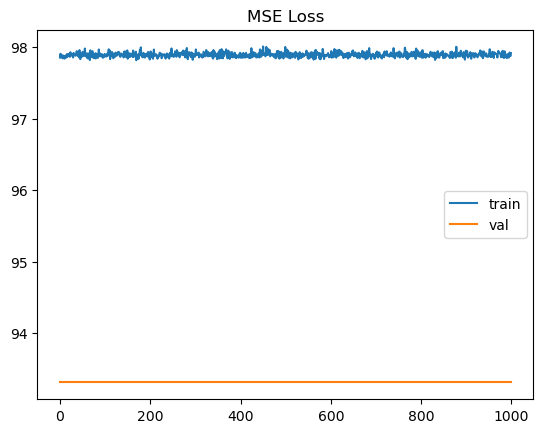

In [25]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MSE Loss")
plt.legend()

## Task 6 

Add dropout to the model, and rerun the previous experiment, does it have any effect and why?

In [26]:
class NeuralNet(torch.nn.Module):
    def __init__(
        self,
        in_dimension=2,
        hidden_nodes=1,
        num_hidden_layers=1,
        act=torch.nn.ReLU(inplace=True),
        out_dimension=1,
        dropout_prob=0.5,
    ):
        """
        in_dimension: number of input data/features
        hidden_nodes: number of neurons in the hidden layer(s)
        num_hidden_layers: number of hidden layers
        act: activation function
        out_dimension: number of output neurons e.g. number of classes
        dropout_prob: probability of dropout
        """
        super(NeuralNet, self).__init__()
        self.layers = []
        
        # Input layer
        self.layers.append(torch.nn.Linear(in_dimension, hidden_nodes))
        self.layers.append(act)
        self.layers.append(torch.nn.Dropout(p=dropout_prob))
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            self.layers.append(torch.nn.Linear(hidden_nodes, hidden_nodes))
            self.layers.append(act)
            self.layers.append(torch.nn.Dropout(p=dropout_prob))
        
        # Output layer
        self.layers.append(torch.nn.Linear(hidden_nodes, out_dimension))
        
        # Define the sequential model
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=-1)

## Task 7


**TODO!** Rerun the experiment with the second synthetic dataset, with splitting, and proper training. Feel free to play with the parameters of the models

In [60]:
# Generate the synthetic dataset
n_samples = 10000
n_segments = 5
X, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=True
)

# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training, validation, and test sets (70%, 15%, 15%)
x_train, x_temp, y_train, y_temp = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 32

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(valid_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

# Length of data loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Validation loader length: {len(valid_loader)}")
print(f"Test loader length: {len(test_loader)}")

Train dataset length: 7000
Validation dataset length: 1500
Test dataset length: 1500
Train loader length: 219
Validation loader length: 47
Test loader length: 47


C:\Users\danie\AppData\Local\Temp\ipykernel_17024\3174418460.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32)


In [61]:
# TODO: instantiate model
my_model = NeuralNet(in_dimension=2, hidden_nodes=1, num_hidden_layers=1, out_dimension=1)
# TODO: instantiate loss
critereon = torch.nn.MSELoss()
# TODO: instantiate a suitable optimizer
optimizer = Adam(my_model.parameters(), lr=0.001)

In [62]:
best_model, train_losses, val_losses = a_proper_training(
    1000, my_model, optimizer, critereon, train_loader, valid_loader
)

Epoch 1, Validation Loss: 159.5293
Epoch 2, Validation Loss: 158.3800
Epoch 3, Validation Loss: 157.1651
Epoch 4, Validation Loss: 155.8808
Epoch 5, Validation Loss: 154.8575
Epoch 6, Validation Loss: 154.1213
Epoch 7, Validation Loss: 153.5556
Epoch 8, Validation Loss: 153.2488
Epoch 9, Validation Loss: 152.9939
Epoch 10, Validation Loss: 152.8025
Epoch 11, Validation Loss: 152.6803
Epoch 12, Validation Loss: 152.4937
Epoch 13, Validation Loss: 152.3786
Epoch 14, Validation Loss: 152.2770
Epoch 15, Validation Loss: 152.2070
Epoch 16, Validation Loss: 152.1242
Epoch 17, Validation Loss: 152.0931
Epoch 18, Validation Loss: 152.0455
Epoch 19, Validation Loss: 152.0424
Epoch 20, Validation Loss: 151.9822
Epoch 21, Validation Loss: 151.9657
Epoch 22, Validation Loss: 151.9214
Epoch 23, Validation Loss: 151.8815
Epoch 24, Validation Loss: 151.8186
Epoch 25, Validation Loss: 151.8158
Epoch 26, Validation Loss: 151.7726
Epoch 27, Validation Loss: 151.7784
Epoch 28, Validation Loss: 151.7387
E

KeyboardInterrupt: 

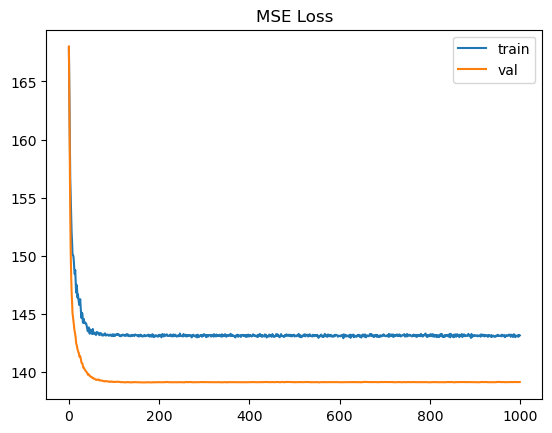

In [30]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MSE Loss")
plt.legend()

In [31]:
def stats_reg(dataloader, model):
    """
    Returns the MSE and CorrCoef for a given PyTorch dataset and model
    """

    A = ["MSE", "CorrCoeff"]
    model.eval()

    for x, y in dataloader:
        preds = model(x)
        pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
        mse = nn.MSELoss()(preds, y)

    B = [mse.item(), pcorr[0, 1]]

    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")

In [32]:
stats_reg(test_loader, my_model)


 #################### STATISTICS####################

MSE   123.83642578125
CorrCoeff   0.530547518820311

 ##################################################


<center><h1 style="font-size:40px;">Real dataset</h1></center>

## Task 9

In the following example, we will import the diabetes dataset. This dataset contains data from diabetic patients and contains certain features such as their bmi, age , blood pressure and glucose levels which are useful in predicting the diabetes disease progression in patients.

Here are the key details of the sklearn diabetes dataset:

- Target Variable: The target variable is a quantitative measure of disease progression, which represents the one-year change in a patient's disease progression. It is a continuous variable, not a binary classification of diabetes.
- Features (Predictors):
    The dataset contains ten baseline variables (predictors) that are used to predict the disease progression:

        - Age
        - Sex
        - BMI (Body Mass Index)
        - Average Blood Pressure
        - S1: Total serum cholesterol
        - S2: Low-density lipoproteins (LDL cholesterol)
        - S3: High-density lipoproteins (HDL cholesterol)
        - S4: Total cholesterol / HDL cholesterol ratio
        - S5: Log of serum triglycerides level
        - S6: Blood sugar level

In [42]:
from sklearn import datasets
import seaborn as sns
import pandas as pd

In [43]:
diabetes = datasets.load_diabetes(scaled=True, as_frame=True, return_X_y=True)
X, y = diabetes[0], diabetes[1]
X = X.astype(np.float32)
y = y.astype(np.float32)

<Axes: >

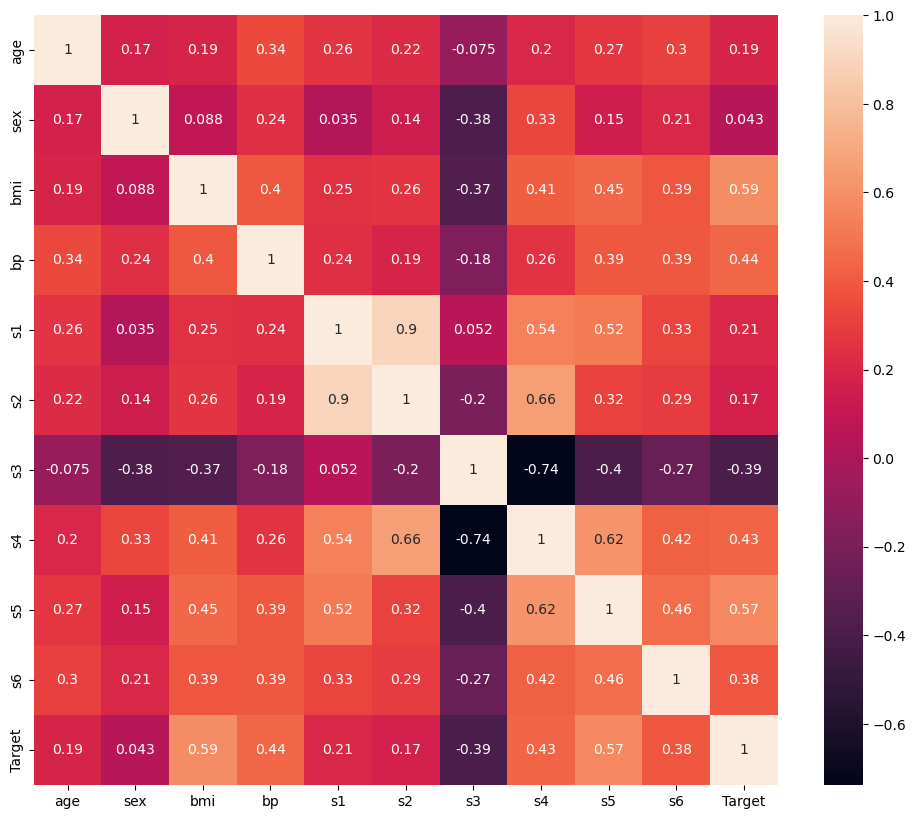

In [44]:
cols = list(X.columns) + ["Target"]
diabetes_df = pd.DataFrame(np.hstack([X, np.atleast_2d(y).T]), columns=cols)
plt.figure(figsize=(12, 10))
sns.heatmap(diabetes_df.corr(), annot=True)

**TODO:**  run the experiments for the diabetes dataset, do you get similar performance? why? Do you suffer from overfitting/underfitting?

In [45]:

#--------------------------------------------------------------------------------------------

# Ensure X is a numpy array
X = X.astype(np.float32).to_numpy()

# Convert numpy arrays to PyTorch tensors
x_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training, validation, and test sets (70%, 15%, 15%)
x_train, x_temp, y_train, y_temp = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 32

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(valid_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

# Length of data loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Validation loader length: {len(valid_loader)}")
print(f"Test loader length: {len(test_loader)}")

#--------------------------------------------------------------------------------------------

# TODO: instantiate model
my_model = NeuralNet(in_dimension=10, hidden_nodes=1, num_hidden_layers=1, out_dimension=1)
# TODO: instantiate loss
critereon = torch.nn.MSELoss()
# TODO: instantiate a suitable optimizer
optimizer = Adam(my_model.parameters(), lr=0.001)

best_model, train_losses, val_losses = a_proper_training(
    30000, my_model, optimizer, critereon, train_loader, valid_loader
)

Train dataset length: 309
Validation dataset length: 66
Test dataset length: 67
Train loader length: 10
Validation loader length: 3
Test loader length: 3
Epoch 1, Validation Loss: 32615.8958
Epoch 2, Validation Loss: 32612.6569
Epoch 3, Validation Loss: 32609.3919
Epoch 4, Validation Loss: 32606.1406
Epoch 5, Validation Loss: 32602.8555
Epoch 6, Validation Loss: 32599.5742
Epoch 7, Validation Loss: 32596.3060
Epoch 8, Validation Loss: 32593.0326
Epoch 9, Validation Loss: 32589.7741
Epoch 10, Validation Loss: 32586.4831
Epoch 11, Validation Loss: 32583.2370
Epoch 12, Validation Loss: 32579.9844
Epoch 13, Validation Loss: 32576.7292
Epoch 14, Validation Loss: 32573.4596
Epoch 15, Validation Loss: 32570.1732
Epoch 16, Validation Loss: 32566.9167
Epoch 17, Validation Loss: 32563.6667
Epoch 18, Validation Loss: 32560.3919
Epoch 19, Validation Loss: 32557.1302
Epoch 20, Validation Loss: 32553.8815
Epoch 21, Validation Loss: 32550.6126
Epoch 22, Validation Loss: 32547.3516
Epoch 23, Validatio

C:\Users\danie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\danie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40, Validation Loss: 32488.6556
Epoch 41, Validation Loss: 32485.3633
Epoch 42, Validation Loss: 32482.1204
Epoch 43, Validation Loss: 32478.8620
Epoch 44, Validation Loss: 32475.6107
Epoch 45, Validation Loss: 32472.3587
Epoch 46, Validation Loss: 32469.0729
Epoch 47, Validation Loss: 32465.8275
Epoch 48, Validation Loss: 32462.5820
Epoch 49, Validation Loss: 32459.3379
Epoch 50, Validation Loss: 32456.0931
Epoch 51, Validation Loss: 32452.8418
Epoch 52, Validation Loss: 32449.5671
Epoch 53, Validation Loss: 32446.2988
Epoch 54, Validation Loss: 32443.0234
Epoch 55, Validation Loss: 32439.7728
Epoch 56, Validation Loss: 32436.5156
Epoch 57, Validation Loss: 32433.2839
Epoch 58, Validation Loss: 32429.9948
Epoch 59, Validation Loss: 32426.7363
Epoch 60, Validation Loss: 32423.4961
Epoch 61, Validation Loss: 32420.2708
Epoch 62, Validation Loss: 32416.9818
Epoch 63, Validation Loss: 32413.7142
Epoch 64, Validation Loss: 32410.4486
Epoch 65, Validation Loss: 32407.2142
Epoch 66, Va

Epoch 278, Validation Loss: 31720.6934
Epoch 279, Validation Loss: 31717.4980
Epoch 280, Validation Loss: 31714.2630
Epoch 281, Validation Loss: 31711.0885
Epoch 282, Validation Loss: 31707.8776
Epoch 283, Validation Loss: 31704.6673
Epoch 284, Validation Loss: 31701.4329
Epoch 285, Validation Loss: 31698.2415
Epoch 286, Validation Loss: 31695.0638
Epoch 287, Validation Loss: 31691.8548
Epoch 288, Validation Loss: 31688.6738
Epoch 289, Validation Loss: 31685.4701
Epoch 290, Validation Loss: 31682.2637
Epoch 291, Validation Loss: 31679.0462
Epoch 292, Validation Loss: 31675.8379
Epoch 293, Validation Loss: 31672.6816
Epoch 294, Validation Loss: 31669.5085
Epoch 295, Validation Loss: 31666.3034
Epoch 296, Validation Loss: 31663.1152
Epoch 297, Validation Loss: 31659.9310
Epoch 298, Validation Loss: 31656.7253
Epoch 299, Validation Loss: 31653.5469
Epoch 300, Validation Loss: 31650.3607
Epoch 301, Validation Loss: 31647.1777
Epoch 302, Validation Loss: 31643.9538
Epoch 303, Validation Los

Epoch 516, Validation Loss: 30965.8008
Epoch 517, Validation Loss: 30962.6478
Epoch 518, Validation Loss: 30959.5059
Epoch 519, Validation Loss: 30956.3724
Epoch 520, Validation Loss: 30953.2279
Epoch 521, Validation Loss: 30950.0553
Epoch 522, Validation Loss: 30946.9108
Epoch 523, Validation Loss: 30943.7871
Epoch 524, Validation Loss: 30940.6393
Epoch 525, Validation Loss: 30937.4772
Epoch 526, Validation Loss: 30934.3268
Epoch 527, Validation Loss: 30931.1940
Epoch 528, Validation Loss: 30928.0736
Epoch 529, Validation Loss: 30924.9043
Epoch 530, Validation Loss: 30921.7415
Epoch 531, Validation Loss: 30918.6706
Epoch 532, Validation Loss: 30915.5443
Epoch 533, Validation Loss: 30912.3965
Epoch 534, Validation Loss: 30909.2598
Epoch 535, Validation Loss: 30906.1250
Epoch 536, Validation Loss: 30902.9557
Epoch 537, Validation Loss: 30899.8210
Epoch 538, Validation Loss: 30896.6927
Epoch 539, Validation Loss: 30893.5417
Epoch 540, Validation Loss: 30890.4089
Epoch 541, Validation Los

Epoch 753, Validation Loss: 30225.7689
Epoch 754, Validation Loss: 30222.6751
Epoch 755, Validation Loss: 30219.5664
Epoch 756, Validation Loss: 30216.4720
Epoch 757, Validation Loss: 30213.3737
Epoch 758, Validation Loss: 30210.2578
Epoch 759, Validation Loss: 30207.1784
Epoch 760, Validation Loss: 30204.0977
Epoch 761, Validation Loss: 30200.9857
Epoch 762, Validation Loss: 30197.8737
Epoch 763, Validation Loss: 30194.8040
Epoch 764, Validation Loss: 30191.6901
Epoch 765, Validation Loss: 30188.5781
Epoch 766, Validation Loss: 30185.4570
Epoch 767, Validation Loss: 30182.3900
Epoch 768, Validation Loss: 30179.2695
Epoch 769, Validation Loss: 30176.1777
Epoch 770, Validation Loss: 30173.0964
Epoch 771, Validation Loss: 30169.9941
Epoch 772, Validation Loss: 30166.9023
Epoch 773, Validation Loss: 30163.8327
Epoch 774, Validation Loss: 30160.7493
Epoch 775, Validation Loss: 30157.6354
Epoch 776, Validation Loss: 30154.5299
Epoch 777, Validation Loss: 30151.4792
Epoch 778, Validation Los

Epoch 991, Validation Loss: 29493.7253
Epoch 992, Validation Loss: 29490.6335
Epoch 993, Validation Loss: 29487.6348
Epoch 994, Validation Loss: 29484.5814
Epoch 995, Validation Loss: 29481.5143
Epoch 996, Validation Loss: 29478.4414
Epoch 997, Validation Loss: 29475.4238
Epoch 998, Validation Loss: 29472.3359
Epoch 999, Validation Loss: 29469.2956
Epoch 1000, Validation Loss: 29466.2031
Epoch 1001, Validation Loss: 29463.1797
Epoch 1002, Validation Loss: 29460.1517
Epoch 1003, Validation Loss: 29457.1204
Epoch 1004, Validation Loss: 29454.0996
Epoch 1005, Validation Loss: 29451.0345
Epoch 1006, Validation Loss: 29447.9844
Epoch 1007, Validation Loss: 29444.9108
Epoch 1008, Validation Loss: 29441.8906
Epoch 1009, Validation Loss: 29438.8151
Epoch 1010, Validation Loss: 29435.7402
Epoch 1011, Validation Loss: 29432.7109
Epoch 1012, Validation Loss: 29429.6458
Epoch 1013, Validation Loss: 29426.6165
Epoch 1014, Validation Loss: 29423.5553
Epoch 1015, Validation Loss: 29420.4980
Epoch 101

Epoch 1231, Validation Loss: 28767.1693
Epoch 1232, Validation Loss: 28764.1706
Epoch 1233, Validation Loss: 28761.1589
Epoch 1234, Validation Loss: 28758.1543
Epoch 1235, Validation Loss: 28755.1348
Epoch 1236, Validation Loss: 28752.1211
Epoch 1237, Validation Loss: 28749.1237
Epoch 1238, Validation Loss: 28746.1354
Epoch 1239, Validation Loss: 28743.1497
Epoch 1240, Validation Loss: 28740.1276
Epoch 1241, Validation Loss: 28737.1211
Epoch 1242, Validation Loss: 28734.1374
Epoch 1243, Validation Loss: 28731.1445
Epoch 1244, Validation Loss: 28728.1510
Epoch 1245, Validation Loss: 28725.1452
Epoch 1246, Validation Loss: 28722.1270
Epoch 1247, Validation Loss: 28719.1257
Epoch 1248, Validation Loss: 28716.0794
Epoch 1249, Validation Loss: 28713.0996
Epoch 1250, Validation Loss: 28710.0944
Epoch 1251, Validation Loss: 28707.1029
Epoch 1252, Validation Loss: 28704.1133
Epoch 1253, Validation Loss: 28701.0983
Epoch 1254, Validation Loss: 28698.1055
Epoch 1255, Validation Loss: 28695.1146


Epoch 1470, Validation Loss: 28055.0436
Epoch 1471, Validation Loss: 28052.1211
Epoch 1472, Validation Loss: 28049.1087
Epoch 1473, Validation Loss: 28046.1413
Epoch 1474, Validation Loss: 28043.1738
Epoch 1475, Validation Loss: 28040.2188
Epoch 1476, Validation Loss: 28037.3223
Epoch 1477, Validation Loss: 28034.3385
Epoch 1478, Validation Loss: 28031.3802
Epoch 1479, Validation Loss: 28028.4232
Epoch 1480, Validation Loss: 28025.4408
Epoch 1481, Validation Loss: 28022.5221
Epoch 1482, Validation Loss: 28019.5703
Epoch 1483, Validation Loss: 28016.6074
Epoch 1484, Validation Loss: 28013.6484
Epoch 1485, Validation Loss: 28010.6973
Epoch 1486, Validation Loss: 28007.7070
Epoch 1487, Validation Loss: 28004.7897
Epoch 1488, Validation Loss: 28001.8626
Epoch 1489, Validation Loss: 27998.9212
Epoch 1490, Validation Loss: 27995.9447
Epoch 1491, Validation Loss: 27993.0195
Epoch 1492, Validation Loss: 27990.0677
Epoch 1493, Validation Loss: 27987.0736
Epoch 1494, Validation Loss: 27984.1126


Epoch 1709, Validation Loss: 27354.2344
Epoch 1710, Validation Loss: 27351.3001
Epoch 1711, Validation Loss: 27348.3698
Epoch 1712, Validation Loss: 27345.4401
Epoch 1713, Validation Loss: 27342.5365
Epoch 1714, Validation Loss: 27339.6647
Epoch 1715, Validation Loss: 27336.7500
Epoch 1716, Validation Loss: 27333.8542
Epoch 1717, Validation Loss: 27330.9368
Epoch 1718, Validation Loss: 27328.0638
Epoch 1719, Validation Loss: 27325.1732
Epoch 1720, Validation Loss: 27322.2747
Epoch 1721, Validation Loss: 27319.3639
Epoch 1722, Validation Loss: 27316.4167
Epoch 1723, Validation Loss: 27313.4974
Epoch 1724, Validation Loss: 27310.5801
Epoch 1725, Validation Loss: 27307.7051
Epoch 1726, Validation Loss: 27304.7819
Epoch 1727, Validation Loss: 27301.9115
Epoch 1728, Validation Loss: 27298.9727
Epoch 1729, Validation Loss: 27296.0560
Epoch 1730, Validation Loss: 27293.1510
Epoch 1731, Validation Loss: 27290.2292
Epoch 1732, Validation Loss: 27287.3307
Epoch 1733, Validation Loss: 27284.3991


Epoch 1947, Validation Loss: 26667.4238
Epoch 1948, Validation Loss: 26664.5739
Epoch 1949, Validation Loss: 26661.7096
Epoch 1950, Validation Loss: 26658.8594
Epoch 1951, Validation Loss: 26656.0020
Epoch 1952, Validation Loss: 26653.1250
Epoch 1953, Validation Loss: 26650.2630
Epoch 1954, Validation Loss: 26647.4056
Epoch 1955, Validation Loss: 26644.5264
Epoch 1956, Validation Loss: 26641.7070
Epoch 1957, Validation Loss: 26638.8232
Epoch 1958, Validation Loss: 26635.9681
Epoch 1959, Validation Loss: 26633.0778
Epoch 1960, Validation Loss: 26630.2419
Epoch 1961, Validation Loss: 26627.4076
Epoch 1962, Validation Loss: 26624.5697
Epoch 1963, Validation Loss: 26621.6895
Epoch 1964, Validation Loss: 26618.8275
Epoch 1965, Validation Loss: 26615.9753
Epoch 1966, Validation Loss: 26613.1341
Epoch 1967, Validation Loss: 26610.2617
Epoch 1968, Validation Loss: 26607.4062
Epoch 1969, Validation Loss: 26604.5563
Epoch 1970, Validation Loss: 26601.7005
Epoch 1971, Validation Loss: 26598.8392


Epoch 2183, Validation Loss: 25997.7370
Epoch 2184, Validation Loss: 25994.9010
Epoch 2185, Validation Loss: 25992.0879
Epoch 2186, Validation Loss: 25989.2930
Epoch 2187, Validation Loss: 25986.4655
Epoch 2188, Validation Loss: 25983.6335
Epoch 2189, Validation Loss: 25980.7995
Epoch 2190, Validation Loss: 25978.0521
Epoch 2191, Validation Loss: 25975.1969
Epoch 2192, Validation Loss: 25972.4020
Epoch 2193, Validation Loss: 25969.6201
Epoch 2194, Validation Loss: 25966.7878
Epoch 2195, Validation Loss: 25963.9678
Epoch 2196, Validation Loss: 25961.1400
Epoch 2197, Validation Loss: 25958.3164
Epoch 2198, Validation Loss: 25955.5072
Epoch 2199, Validation Loss: 25952.7129
Epoch 2200, Validation Loss: 25949.8809
Epoch 2201, Validation Loss: 25947.1055
Epoch 2202, Validation Loss: 25944.2917
Epoch 2203, Validation Loss: 25941.5208
Epoch 2204, Validation Loss: 25938.6885
Epoch 2205, Validation Loss: 25935.8577
Epoch 2206, Validation Loss: 25933.0508
Epoch 2207, Validation Loss: 25930.2533


Epoch 2418, Validation Loss: 25341.7096
Epoch 2419, Validation Loss: 25338.9375
Epoch 2420, Validation Loss: 25336.1742
Epoch 2421, Validation Loss: 25333.4066
Epoch 2422, Validation Loss: 25330.6185
Epoch 2423, Validation Loss: 25327.8646
Epoch 2424, Validation Loss: 25325.0889
Epoch 2425, Validation Loss: 25322.2852
Epoch 2426, Validation Loss: 25319.5615
Epoch 2427, Validation Loss: 25316.8040
Epoch 2428, Validation Loss: 25314.0550
Epoch 2429, Validation Loss: 25311.2669
Epoch 2430, Validation Loss: 25308.4990
Epoch 2431, Validation Loss: 25305.7344
Epoch 2432, Validation Loss: 25302.9609
Epoch 2433, Validation Loss: 25300.1699
Epoch 2434, Validation Loss: 25297.4017
Epoch 2435, Validation Loss: 25294.6204
Epoch 2436, Validation Loss: 25291.8669
Epoch 2437, Validation Loss: 25289.0999
Epoch 2438, Validation Loss: 25286.3548
Epoch 2439, Validation Loss: 25283.5765
Epoch 2440, Validation Loss: 25280.8574
Epoch 2441, Validation Loss: 25278.0553
Epoch 2442, Validation Loss: 25275.3001


Epoch 2653, Validation Loss: 24696.5521
Epoch 2654, Validation Loss: 24693.7988
Epoch 2655, Validation Loss: 24691.0537
Epoch 2656, Validation Loss: 24688.3483
Epoch 2657, Validation Loss: 24685.6667
Epoch 2658, Validation Loss: 24682.9456
Epoch 2659, Validation Loss: 24680.2747
Epoch 2660, Validation Loss: 24677.5215
Epoch 2661, Validation Loss: 24674.7884
Epoch 2662, Validation Loss: 24672.1025
Epoch 2663, Validation Loss: 24669.3734
Epoch 2664, Validation Loss: 24666.6416
Epoch 2665, Validation Loss: 24663.9505
Epoch 2666, Validation Loss: 24661.2018
Epoch 2667, Validation Loss: 24658.4463
Epoch 2668, Validation Loss: 24655.7474
Epoch 2669, Validation Loss: 24653.0322
Epoch 2670, Validation Loss: 24650.3063
Epoch 2671, Validation Loss: 24647.5872
Epoch 2672, Validation Loss: 24644.8825
Epoch 2673, Validation Loss: 24642.1986
Epoch 2674, Validation Loss: 24639.4375
Epoch 2675, Validation Loss: 24636.7305
Epoch 2676, Validation Loss: 24633.9779
Epoch 2677, Validation Loss: 24631.2992


Epoch 2887, Validation Loss: 24065.2454
Epoch 2888, Validation Loss: 24062.5827
Epoch 2889, Validation Loss: 24059.9030
Epoch 2890, Validation Loss: 24057.2132
Epoch 2891, Validation Loss: 24054.5111
Epoch 2892, Validation Loss: 24051.8639
Epoch 2893, Validation Loss: 24049.1979
Epoch 2894, Validation Loss: 24046.5049
Epoch 2895, Validation Loss: 24043.8275
Epoch 2896, Validation Loss: 24041.1520
Epoch 2897, Validation Loss: 24038.4593
Epoch 2898, Validation Loss: 24035.7715
Epoch 2899, Validation Loss: 24033.1100
Epoch 2900, Validation Loss: 24030.4030
Epoch 2901, Validation Loss: 24027.7337
Epoch 2902, Validation Loss: 24025.1221
Epoch 2903, Validation Loss: 24022.4499
Epoch 2904, Validation Loss: 24019.8050
Epoch 2905, Validation Loss: 24017.1413
Epoch 2906, Validation Loss: 24014.4603
Epoch 2907, Validation Loss: 24011.7803
Epoch 2908, Validation Loss: 24009.1439
Epoch 2909, Validation Loss: 24006.4762
Epoch 2910, Validation Loss: 24003.8021
Epoch 2911, Validation Loss: 24001.1289


Epoch 3118, Validation Loss: 23452.6338
Epoch 3119, Validation Loss: 23449.9707
Epoch 3120, Validation Loss: 23447.3626
Epoch 3121, Validation Loss: 23444.7568
Epoch 3122, Validation Loss: 23442.1344
Epoch 3123, Validation Loss: 23439.5163
Epoch 3124, Validation Loss: 23436.9274
Epoch 3125, Validation Loss: 23434.2412
Epoch 3126, Validation Loss: 23431.6426
Epoch 3127, Validation Loss: 23429.0026
Epoch 3128, Validation Loss: 23426.3649
Epoch 3129, Validation Loss: 23423.7637
Epoch 3130, Validation Loss: 23421.1185
Epoch 3131, Validation Loss: 23418.4977
Epoch 3132, Validation Loss: 23415.8792
Epoch 3133, Validation Loss: 23413.2546
Epoch 3134, Validation Loss: 23410.6051
Epoch 3135, Validation Loss: 23407.9570
Epoch 3136, Validation Loss: 23405.3483
Epoch 3137, Validation Loss: 23402.7093
Epoch 3138, Validation Loss: 23400.0781
Epoch 3139, Validation Loss: 23397.4834
Epoch 3140, Validation Loss: 23394.8568
Epoch 3141, Validation Loss: 23392.2503
Epoch 3142, Validation Loss: 23389.6061


Epoch 3354, Validation Loss: 22837.8050
Epoch 3355, Validation Loss: 22835.1927
Epoch 3356, Validation Loss: 22832.6488
Epoch 3357, Validation Loss: 22830.0628
Epoch 3358, Validation Loss: 22827.4619
Epoch 3359, Validation Loss: 22824.8581
Epoch 3360, Validation Loss: 22822.2533
Epoch 3361, Validation Loss: 22819.6862
Epoch 3362, Validation Loss: 22817.1374
Epoch 3363, Validation Loss: 22814.5186
Epoch 3364, Validation Loss: 22811.9473
Epoch 3365, Validation Loss: 22809.3887
Epoch 3366, Validation Loss: 22806.7565
Epoch 3367, Validation Loss: 22804.2188
Epoch 3368, Validation Loss: 22801.6413
Epoch 3369, Validation Loss: 22799.0498
Epoch 3370, Validation Loss: 22796.4521
Epoch 3371, Validation Loss: 22793.8978
Epoch 3372, Validation Loss: 22791.2881
Epoch 3373, Validation Loss: 22788.6855
Epoch 3374, Validation Loss: 22786.1019
Epoch 3375, Validation Loss: 22783.5290
Epoch 3376, Validation Loss: 22780.9434
Epoch 3377, Validation Loss: 22778.3952
Epoch 3378, Validation Loss: 22775.8014


Epoch 3591, Validation Loss: 22231.5931
Epoch 3592, Validation Loss: 22229.0342
Epoch 3593, Validation Loss: 22226.4945
Epoch 3594, Validation Loss: 22223.9727
Epoch 3595, Validation Loss: 22221.4609
Epoch 3596, Validation Loss: 22218.9294
Epoch 3597, Validation Loss: 22216.3610
Epoch 3598, Validation Loss: 22213.8428
Epoch 3599, Validation Loss: 22211.2943
Epoch 3600, Validation Loss: 22208.7409
Epoch 3601, Validation Loss: 22206.2360
Epoch 3602, Validation Loss: 22203.7103
Epoch 3603, Validation Loss: 22201.2044
Epoch 3604, Validation Loss: 22198.6794
Epoch 3605, Validation Loss: 22196.1745
Epoch 3606, Validation Loss: 22193.6406
Epoch 3607, Validation Loss: 22191.0859
Epoch 3608, Validation Loss: 22188.5387
Epoch 3609, Validation Loss: 22186.0195
Epoch 3610, Validation Loss: 22183.4912
Epoch 3611, Validation Loss: 22180.9528
Epoch 3612, Validation Loss: 22178.4414
Epoch 3613, Validation Loss: 22175.9382
Epoch 3614, Validation Loss: 22173.3877
Epoch 3615, Validation Loss: 22170.8503


Epoch 3827, Validation Loss: 21638.9388
Epoch 3828, Validation Loss: 21636.4525
Epoch 3829, Validation Loss: 21633.9531
Epoch 3830, Validation Loss: 21631.4574
Epoch 3831, Validation Loss: 21628.9492
Epoch 3832, Validation Loss: 21626.4727
Epoch 3833, Validation Loss: 21623.9801
Epoch 3834, Validation Loss: 21621.4958
Epoch 3835, Validation Loss: 21619.0189
Epoch 3836, Validation Loss: 21616.5042
Epoch 3837, Validation Loss: 21614.0690
Epoch 3838, Validation Loss: 21611.5169
Epoch 3839, Validation Loss: 21609.0316
Epoch 3840, Validation Loss: 21606.5309
Epoch 3841, Validation Loss: 21604.0820
Epoch 3842, Validation Loss: 21601.6025
Epoch 3843, Validation Loss: 21599.1400
Epoch 3844, Validation Loss: 21596.6543
Epoch 3845, Validation Loss: 21594.1908
Epoch 3846, Validation Loss: 21591.7259
Epoch 3847, Validation Loss: 21589.2285
Epoch 3848, Validation Loss: 21586.7233
Epoch 3849, Validation Loss: 21584.2572
Epoch 3850, Validation Loss: 21581.7607
Epoch 3851, Validation Loss: 21579.3102


Epoch 4064, Validation Loss: 21054.8281
Epoch 4065, Validation Loss: 21052.3815
Epoch 4066, Validation Loss: 21049.9232
Epoch 4067, Validation Loss: 21047.4964
Epoch 4068, Validation Loss: 21045.0576
Epoch 4069, Validation Loss: 21042.6338
Epoch 4070, Validation Loss: 21040.2210
Epoch 4071, Validation Loss: 21037.7796
Epoch 4072, Validation Loss: 21035.3600
Epoch 4073, Validation Loss: 21032.8851
Epoch 4074, Validation Loss: 21030.4440
Epoch 4075, Validation Loss: 21028.0098
Epoch 4076, Validation Loss: 21025.5807
Epoch 4077, Validation Loss: 21023.1478
Epoch 4078, Validation Loss: 21020.6868
Epoch 4079, Validation Loss: 21018.2699
Epoch 4080, Validation Loss: 21015.8486
Epoch 4081, Validation Loss: 21013.3939
Epoch 4082, Validation Loss: 21010.9235
Epoch 4083, Validation Loss: 21008.4987
Epoch 4084, Validation Loss: 21006.0430
Epoch 4085, Validation Loss: 21003.6263
Epoch 4086, Validation Loss: 21001.2077
Epoch 4087, Validation Loss: 20998.7754
Epoch 4088, Validation Loss: 20996.3783


Epoch 4300, Validation Loss: 20484.2796
Epoch 4301, Validation Loss: 20481.8669
Epoch 4302, Validation Loss: 20479.4915
Epoch 4303, Validation Loss: 20477.1175
Epoch 4304, Validation Loss: 20474.7152
Epoch 4305, Validation Loss: 20472.2943
Epoch 4306, Validation Loss: 20469.8773
Epoch 4307, Validation Loss: 20467.5046
Epoch 4308, Validation Loss: 20465.1195
Epoch 4309, Validation Loss: 20462.7155
Epoch 4310, Validation Loss: 20460.2995
Epoch 4311, Validation Loss: 20457.9072
Epoch 4312, Validation Loss: 20455.5127
Epoch 4313, Validation Loss: 20453.1296
Epoch 4314, Validation Loss: 20450.7266
Epoch 4315, Validation Loss: 20448.3206
Epoch 4316, Validation Loss: 20445.9229
Epoch 4317, Validation Loss: 20443.5339
Epoch 4318, Validation Loss: 20441.1159
Epoch 4319, Validation Loss: 20438.6963
Epoch 4320, Validation Loss: 20436.3132
Epoch 4321, Validation Loss: 20433.9466
Epoch 4322, Validation Loss: 20431.5469
Epoch 4323, Validation Loss: 20429.1784
Epoch 4324, Validation Loss: 20426.7611


Epoch 4537, Validation Loss: 19922.5579
Epoch 4538, Validation Loss: 19920.2158
Epoch 4539, Validation Loss: 19917.8665
Epoch 4540, Validation Loss: 19915.5130
Epoch 4541, Validation Loss: 19913.1686
Epoch 4542, Validation Loss: 19910.8376
Epoch 4543, Validation Loss: 19908.5052
Epoch 4544, Validation Loss: 19906.1217
Epoch 4545, Validation Loss: 19903.7539
Epoch 4546, Validation Loss: 19901.4368
Epoch 4547, Validation Loss: 19899.0833
Epoch 4548, Validation Loss: 19896.7601
Epoch 4549, Validation Loss: 19894.3916
Epoch 4550, Validation Loss: 19892.0521
Epoch 4551, Validation Loss: 19889.7409
Epoch 4552, Validation Loss: 19887.3600
Epoch 4553, Validation Loss: 19885.0345
Epoch 4554, Validation Loss: 19882.6901
Epoch 4555, Validation Loss: 19880.3363
Epoch 4556, Validation Loss: 19877.9701
Epoch 4557, Validation Loss: 19875.6055
Epoch 4558, Validation Loss: 19873.2799
Epoch 4559, Validation Loss: 19870.9460
Epoch 4560, Validation Loss: 19868.6064
Epoch 4561, Validation Loss: 19866.2493


Epoch 4774, Validation Loss: 19371.7760
Epoch 4775, Validation Loss: 19369.4733
Epoch 4776, Validation Loss: 19367.1764
Epoch 4777, Validation Loss: 19364.8815
Epoch 4778, Validation Loss: 19362.5736
Epoch 4779, Validation Loss: 19360.2796
Epoch 4780, Validation Loss: 19357.9720
Epoch 4781, Validation Loss: 19355.6598
Epoch 4782, Validation Loss: 19353.3561
Epoch 4783, Validation Loss: 19351.0866
Epoch 4784, Validation Loss: 19348.8089
Epoch 4785, Validation Loss: 19346.5156
Epoch 4786, Validation Loss: 19344.2093
Epoch 4787, Validation Loss: 19341.8988
Epoch 4788, Validation Loss: 19339.5742
Epoch 4789, Validation Loss: 19337.2767
Epoch 4790, Validation Loss: 19334.9671
Epoch 4791, Validation Loss: 19332.6742
Epoch 4792, Validation Loss: 19330.3678
Epoch 4793, Validation Loss: 19328.0918
Epoch 4794, Validation Loss: 19325.7721
Epoch 4795, Validation Loss: 19323.4424
Epoch 4796, Validation Loss: 19321.1797
Epoch 4797, Validation Loss: 19318.8675
Epoch 4798, Validation Loss: 19316.5684


Epoch 5009, Validation Loss: 18836.7305
Epoch 5010, Validation Loss: 18834.4824
Epoch 5011, Validation Loss: 18832.2174
Epoch 5012, Validation Loss: 18829.9554
Epoch 5013, Validation Loss: 18827.6839
Epoch 5014, Validation Loss: 18825.4225
Epoch 5015, Validation Loss: 18823.1816
Epoch 5016, Validation Loss: 18820.9368
Epoch 5017, Validation Loss: 18818.6644
Epoch 5018, Validation Loss: 18816.4023
Epoch 5019, Validation Loss: 18814.1595
Epoch 5020, Validation Loss: 18811.9499
Epoch 5021, Validation Loss: 18809.6572
Epoch 5022, Validation Loss: 18807.4421
Epoch 5023, Validation Loss: 18805.1986
Epoch 5024, Validation Loss: 18802.9447
Epoch 5025, Validation Loss: 18800.7155
Epoch 5026, Validation Loss: 18798.4489
Epoch 5027, Validation Loss: 18796.2246
Epoch 5028, Validation Loss: 18793.9460
Epoch 5029, Validation Loss: 18791.6862
Epoch 5030, Validation Loss: 18789.4408
Epoch 5031, Validation Loss: 18787.2096
Epoch 5032, Validation Loss: 18784.9629
Epoch 5033, Validation Loss: 18782.7188


Epoch 5242, Validation Loss: 18317.0309
Epoch 5243, Validation Loss: 18314.8066
Epoch 5244, Validation Loss: 18312.5518
Epoch 5245, Validation Loss: 18310.3698
Epoch 5246, Validation Loss: 18308.1771
Epoch 5247, Validation Loss: 18305.9710
Epoch 5248, Validation Loss: 18303.7669
Epoch 5249, Validation Loss: 18301.5664
Epoch 5250, Validation Loss: 18299.3770
Epoch 5251, Validation Loss: 18297.1676
Epoch 5252, Validation Loss: 18294.9720
Epoch 5253, Validation Loss: 18292.7734
Epoch 5254, Validation Loss: 18290.5674
Epoch 5255, Validation Loss: 18288.3408
Epoch 5256, Validation Loss: 18286.1419
Epoch 5257, Validation Loss: 18283.9036
Epoch 5258, Validation Loss: 18281.7454
Epoch 5259, Validation Loss: 18279.5488
Epoch 5260, Validation Loss: 18277.3639
Epoch 5261, Validation Loss: 18275.1436
Epoch 5262, Validation Loss: 18272.9635
Epoch 5263, Validation Loss: 18270.7321
Epoch 5264, Validation Loss: 18268.5212
Epoch 5265, Validation Loss: 18266.2962
Epoch 5266, Validation Loss: 18264.1038


Epoch 5478, Validation Loss: 17801.6077
Epoch 5479, Validation Loss: 17799.4326
Epoch 5480, Validation Loss: 17797.2949
Epoch 5481, Validation Loss: 17795.1621
Epoch 5482, Validation Loss: 17792.9834
Epoch 5483, Validation Loss: 17790.8317
Epoch 5484, Validation Loss: 17788.6709
Epoch 5485, Validation Loss: 17786.5622
Epoch 5486, Validation Loss: 17784.3919
Epoch 5487, Validation Loss: 17782.2139
Epoch 5488, Validation Loss: 17780.0544
Epoch 5489, Validation Loss: 17777.8923
Epoch 5490, Validation Loss: 17775.7393
Epoch 5491, Validation Loss: 17773.5605
Epoch 5492, Validation Loss: 17771.3763
Epoch 5493, Validation Loss: 17769.2380
Epoch 5494, Validation Loss: 17767.0820
Epoch 5495, Validation Loss: 17764.9603
Epoch 5496, Validation Loss: 17762.7923
Epoch 5497, Validation Loss: 17760.6237
Epoch 5498, Validation Loss: 17758.4909
Epoch 5499, Validation Loss: 17756.3105
Epoch 5500, Validation Loss: 17754.1497
Epoch 5501, Validation Loss: 17752.0273
Epoch 5502, Validation Loss: 17749.8799


Epoch 5714, Validation Loss: 17297.4209
Epoch 5715, Validation Loss: 17295.2956
Epoch 5716, Validation Loss: 17293.1702
Epoch 5717, Validation Loss: 17291.0511
Epoch 5718, Validation Loss: 17288.9619
Epoch 5719, Validation Loss: 17286.8727
Epoch 5720, Validation Loss: 17284.7373
Epoch 5721, Validation Loss: 17282.6058
Epoch 5722, Validation Loss: 17280.5169
Epoch 5723, Validation Loss: 17278.3870
Epoch 5724, Validation Loss: 17276.2757
Epoch 5725, Validation Loss: 17274.1706
Epoch 5726, Validation Loss: 17272.0365
Epoch 5727, Validation Loss: 17269.9157
Epoch 5728, Validation Loss: 17267.8070
Epoch 5729, Validation Loss: 17265.6976
Epoch 5730, Validation Loss: 17263.6061
Epoch 5731, Validation Loss: 17261.5020
Epoch 5732, Validation Loss: 17259.3828
Epoch 5733, Validation Loss: 17257.2718
Epoch 5734, Validation Loss: 17255.1602
Epoch 5735, Validation Loss: 17253.0137
Epoch 5736, Validation Loss: 17250.9079
Epoch 5737, Validation Loss: 17248.8083
Epoch 5738, Validation Loss: 17246.7152


Epoch 5950, Validation Loss: 16803.7949
Epoch 5951, Validation Loss: 16801.7135
Epoch 5952, Validation Loss: 16799.6569
Epoch 5953, Validation Loss: 16797.5918
Epoch 5954, Validation Loss: 16795.4762
Epoch 5955, Validation Loss: 16793.4320
Epoch 5956, Validation Loss: 16791.3454
Epoch 5957, Validation Loss: 16789.2699
Epoch 5958, Validation Loss: 16787.2113
Epoch 5959, Validation Loss: 16785.1484
Epoch 5960, Validation Loss: 16783.0599
Epoch 5961, Validation Loss: 16781.0068
Epoch 5962, Validation Loss: 16778.9375
Epoch 5963, Validation Loss: 16776.8623
Epoch 5964, Validation Loss: 16774.7865
Epoch 5965, Validation Loss: 16772.7363
Epoch 5966, Validation Loss: 16770.7230
Epoch 5967, Validation Loss: 16768.6523
Epoch 5968, Validation Loss: 16766.5495
Epoch 5969, Validation Loss: 16764.4919
Epoch 5970, Validation Loss: 16762.4349
Epoch 5971, Validation Loss: 16760.3561
Epoch 5972, Validation Loss: 16758.2884
Epoch 5973, Validation Loss: 16756.2311
Epoch 5974, Validation Loss: 16754.1553


Epoch 6184, Validation Loss: 16325.5215
Epoch 6185, Validation Loss: 16323.5514
Epoch 6186, Validation Loss: 16321.4671
Epoch 6187, Validation Loss: 16319.4749
Epoch 6188, Validation Loss: 16317.4749
Epoch 6189, Validation Loss: 16315.4694
Epoch 6190, Validation Loss: 16313.4176
Epoch 6191, Validation Loss: 16311.4154
Epoch 6192, Validation Loss: 16309.3812
Epoch 6193, Validation Loss: 16307.3760
Epoch 6194, Validation Loss: 16305.3633
Epoch 6195, Validation Loss: 16303.3704
Epoch 6196, Validation Loss: 16301.3249
Epoch 6197, Validation Loss: 16299.2982
Epoch 6198, Validation Loss: 16297.2660
Epoch 6199, Validation Loss: 16295.2373
Epoch 6200, Validation Loss: 16293.2236
Epoch 6201, Validation Loss: 16291.2259
Epoch 6202, Validation Loss: 16289.2181
Epoch 6203, Validation Loss: 16287.1615
Epoch 6204, Validation Loss: 16285.1738
Epoch 6205, Validation Loss: 16283.1507
Epoch 6206, Validation Loss: 16281.1471
Epoch 6207, Validation Loss: 16279.1110
Epoch 6208, Validation Loss: 16277.1048


Epoch 6419, Validation Loss: 15856.2865
Epoch 6420, Validation Loss: 15854.2998
Epoch 6421, Validation Loss: 15852.3525
Epoch 6422, Validation Loss: 15850.3480
Epoch 6423, Validation Loss: 15848.3633
Epoch 6424, Validation Loss: 15846.4118
Epoch 6425, Validation Loss: 15844.4284
Epoch 6426, Validation Loss: 15842.4271
Epoch 6427, Validation Loss: 15840.4508
Epoch 6428, Validation Loss: 15838.4473
Epoch 6429, Validation Loss: 15836.5072
Epoch 6430, Validation Loss: 15834.5137
Epoch 6431, Validation Loss: 15832.5306
Epoch 6432, Validation Loss: 15830.5531
Epoch 6433, Validation Loss: 15828.6019
Epoch 6434, Validation Loss: 15826.6299
Epoch 6435, Validation Loss: 15824.6484
Epoch 6436, Validation Loss: 15822.6859
Epoch 6437, Validation Loss: 15820.7135
Epoch 6438, Validation Loss: 15818.7220
Epoch 6439, Validation Loss: 15816.7197
Epoch 6440, Validation Loss: 15814.7822
Epoch 6441, Validation Loss: 15812.8275
Epoch 6442, Validation Loss: 15810.8551
Epoch 6443, Validation Loss: 15808.8962


Epoch 6652, Validation Loss: 15401.7189
Epoch 6653, Validation Loss: 15399.7904
Epoch 6654, Validation Loss: 15397.8846
Epoch 6655, Validation Loss: 15395.9329
Epoch 6656, Validation Loss: 15394.0368
Epoch 6657, Validation Loss: 15392.0881
Epoch 6658, Validation Loss: 15390.1514
Epoch 6659, Validation Loss: 15388.1940
Epoch 6660, Validation Loss: 15386.2848
Epoch 6661, Validation Loss: 15384.3730
Epoch 6662, Validation Loss: 15382.4043
Epoch 6663, Validation Loss: 15380.5023
Epoch 6664, Validation Loss: 15378.5654
Epoch 6665, Validation Loss: 15376.6501
Epoch 6666, Validation Loss: 15374.7096
Epoch 6667, Validation Loss: 15372.7826
Epoch 6668, Validation Loss: 15370.8983
Epoch 6669, Validation Loss: 15368.9876
Epoch 6670, Validation Loss: 15367.0371
Epoch 6671, Validation Loss: 15365.0921
Epoch 6672, Validation Loss: 15363.1771
Epoch 6673, Validation Loss: 15361.3053
Epoch 6674, Validation Loss: 15359.3996
Epoch 6675, Validation Loss: 15357.4549
Epoch 6676, Validation Loss: 15355.5579


Epoch 6889, Validation Loss: 14950.5522
Epoch 6890, Validation Loss: 14948.6178
Epoch 6891, Validation Loss: 14946.7438
Epoch 6892, Validation Loss: 14944.8418
Epoch 6893, Validation Loss: 14942.9990
Epoch 6894, Validation Loss: 14941.1297
Epoch 6895, Validation Loss: 14939.2438
Epoch 6896, Validation Loss: 14937.3490
Epoch 6897, Validation Loss: 14935.4595
Epoch 6898, Validation Loss: 14933.5815
Epoch 6899, Validation Loss: 14931.7191
Epoch 6900, Validation Loss: 14929.8333
Epoch 6901, Validation Loss: 14927.9388
Epoch 6902, Validation Loss: 14926.0812
Epoch 6903, Validation Loss: 14924.2067
Epoch 6904, Validation Loss: 14922.3398
Epoch 6905, Validation Loss: 14920.4528
Epoch 6906, Validation Loss: 14918.5846
Epoch 6907, Validation Loss: 14916.6899
Epoch 6908, Validation Loss: 14914.8275
Epoch 6909, Validation Loss: 14912.9316
Epoch 6910, Validation Loss: 14911.0858
Epoch 6911, Validation Loss: 14909.2091
Epoch 6912, Validation Loss: 14907.3104
Epoch 6913, Validation Loss: 14905.4334


Epoch 7126, Validation Loss: 14510.3389
Epoch 7127, Validation Loss: 14508.4888
Epoch 7128, Validation Loss: 14506.6519
Epoch 7129, Validation Loss: 14504.8350
Epoch 7130, Validation Loss: 14503.0083
Epoch 7131, Validation Loss: 14501.1507
Epoch 7132, Validation Loss: 14499.3462
Epoch 7133, Validation Loss: 14497.5112
Epoch 7134, Validation Loss: 14495.6610
Epoch 7135, Validation Loss: 14493.8089
Epoch 7136, Validation Loss: 14492.0119
Epoch 7137, Validation Loss: 14490.2142
Epoch 7138, Validation Loss: 14488.3817
Epoch 7139, Validation Loss: 14486.5283
Epoch 7140, Validation Loss: 14484.7144
Epoch 7141, Validation Loss: 14482.9017
Epoch 7142, Validation Loss: 14481.0754
Epoch 7143, Validation Loss: 14479.2646
Epoch 7144, Validation Loss: 14477.4323
Epoch 7145, Validation Loss: 14475.5850
Epoch 7146, Validation Loss: 14473.7454
Epoch 7147, Validation Loss: 14471.9123
Epoch 7148, Validation Loss: 14470.1009
Epoch 7149, Validation Loss: 14468.2650
Epoch 7150, Validation Loss: 14466.4373


Epoch 7363, Validation Loss: 14081.2591
Epoch 7364, Validation Loss: 14079.4920
Epoch 7365, Validation Loss: 14077.7078
Epoch 7366, Validation Loss: 14075.9160
Epoch 7367, Validation Loss: 14074.1266
Epoch 7368, Validation Loss: 14072.3052
Epoch 7369, Validation Loss: 14070.5182
Epoch 7370, Validation Loss: 14068.7427
Epoch 7371, Validation Loss: 14066.9715
Epoch 7372, Validation Loss: 14065.1904
Epoch 7373, Validation Loss: 14063.4105
Epoch 7374, Validation Loss: 14061.6180
Epoch 7375, Validation Loss: 14059.8700
Epoch 7376, Validation Loss: 14058.0477
Epoch 7377, Validation Loss: 14056.2422
Epoch 7378, Validation Loss: 14054.4401
Epoch 7379, Validation Loss: 14052.6883
Epoch 7380, Validation Loss: 14050.9194
Epoch 7381, Validation Loss: 14049.1442
Epoch 7382, Validation Loss: 14047.3332
Epoch 7383, Validation Loss: 14045.5075
Epoch 7384, Validation Loss: 14043.7179
Epoch 7385, Validation Loss: 14041.9500
Epoch 7386, Validation Loss: 14040.1689
Epoch 7387, Validation Loss: 14038.3815


Epoch 7600, Validation Loss: 13663.2272
Epoch 7601, Validation Loss: 13661.5028
Epoch 7602, Validation Loss: 13659.7321
Epoch 7603, Validation Loss: 13658.0116
Epoch 7604, Validation Loss: 13656.2897
Epoch 7605, Validation Loss: 13654.6029
Epoch 7606, Validation Loss: 13652.8439
Epoch 7607, Validation Loss: 13651.1019
Epoch 7608, Validation Loss: 13649.4040
Epoch 7609, Validation Loss: 13647.6725
Epoch 7610, Validation Loss: 13645.9233
Epoch 7611, Validation Loss: 13644.1865
Epoch 7612, Validation Loss: 13642.4492
Epoch 7613, Validation Loss: 13640.7104
Epoch 7614, Validation Loss: 13638.9938
Epoch 7615, Validation Loss: 13637.2593
Epoch 7616, Validation Loss: 13635.5457
Epoch 7617, Validation Loss: 13633.7835
Epoch 7618, Validation Loss: 13632.0597
Epoch 7619, Validation Loss: 13630.3415
Epoch 7620, Validation Loss: 13628.6234
Epoch 7621, Validation Loss: 13626.8955
Epoch 7622, Validation Loss: 13625.1665
Epoch 7623, Validation Loss: 13623.4046
Epoch 7624, Validation Loss: 13621.6719


Epoch 7836, Validation Loss: 13258.1066
Epoch 7837, Validation Loss: 13256.4425
Epoch 7838, Validation Loss: 13254.7645
Epoch 7839, Validation Loss: 13253.0726
Epoch 7840, Validation Loss: 13251.3623
Epoch 7841, Validation Loss: 13249.6605
Epoch 7842, Validation Loss: 13247.9855
Epoch 7843, Validation Loss: 13246.3034
Epoch 7844, Validation Loss: 13244.6071
Epoch 7845, Validation Loss: 13242.9575
Epoch 7846, Validation Loss: 13241.2767
Epoch 7847, Validation Loss: 13239.5923
Epoch 7848, Validation Loss: 13237.9474
Epoch 7849, Validation Loss: 13236.2329
Epoch 7850, Validation Loss: 13234.5501
Epoch 7851, Validation Loss: 13232.8548
Epoch 7852, Validation Loss: 13231.1619
Epoch 7853, Validation Loss: 13229.4714
Epoch 7854, Validation Loss: 13227.8174
Epoch 7855, Validation Loss: 13226.1063
Epoch 7856, Validation Loss: 13224.3849
Epoch 7857, Validation Loss: 13222.7375
Epoch 7858, Validation Loss: 13221.0483
Epoch 7859, Validation Loss: 13219.3753
Epoch 7860, Validation Loss: 13217.6647


Epoch 8072, Validation Loss: 12864.4616
Epoch 8073, Validation Loss: 12862.8193
Epoch 8074, Validation Loss: 12861.1395
Epoch 8075, Validation Loss: 12859.5228
Epoch 8076, Validation Loss: 12857.8923
Epoch 8077, Validation Loss: 12856.2349
Epoch 8078, Validation Loss: 12854.6009
Epoch 8079, Validation Loss: 12852.9531
Epoch 8080, Validation Loss: 12851.2785
Epoch 8081, Validation Loss: 12849.6131
Epoch 8082, Validation Loss: 12847.9964
Epoch 8083, Validation Loss: 12846.3584
Epoch 8084, Validation Loss: 12844.7192
Epoch 8085, Validation Loss: 12843.0947
Epoch 8086, Validation Loss: 12841.4382
Epoch 8087, Validation Loss: 12839.8286
Epoch 8088, Validation Loss: 12838.1466
Epoch 8089, Validation Loss: 12836.4933
Epoch 8090, Validation Loss: 12834.8174
Epoch 8091, Validation Loss: 12833.1639
Epoch 8092, Validation Loss: 12831.5327
Epoch 8093, Validation Loss: 12829.9111
Epoch 8094, Validation Loss: 12828.2773
Epoch 8095, Validation Loss: 12826.6536
Epoch 8096, Validation Loss: 12825.0229


Epoch 8309, Validation Loss: 12479.7469
Epoch 8310, Validation Loss: 12478.1392
Epoch 8311, Validation Loss: 12476.5568
Epoch 8312, Validation Loss: 12474.9299
Epoch 8313, Validation Loss: 12473.3151
Epoch 8314, Validation Loss: 12471.7122
Epoch 8315, Validation Loss: 12470.1104
Epoch 8316, Validation Loss: 12468.4919
Epoch 8317, Validation Loss: 12466.8789
Epoch 8318, Validation Loss: 12465.2977
Epoch 8319, Validation Loss: 12463.6862
Epoch 8320, Validation Loss: 12462.0698
Epoch 8321, Validation Loss: 12460.4681
Epoch 8322, Validation Loss: 12458.8931
Epoch 8323, Validation Loss: 12457.2749
Epoch 8324, Validation Loss: 12455.6663
Epoch 8325, Validation Loss: 12454.0881
Epoch 8326, Validation Loss: 12452.4779
Epoch 8327, Validation Loss: 12450.9103
Epoch 8328, Validation Loss: 12449.3130
Epoch 8329, Validation Loss: 12447.7380
Epoch 8330, Validation Loss: 12446.0728
Epoch 8331, Validation Loss: 12444.4678
Epoch 8332, Validation Loss: 12442.9092
Epoch 8333, Validation Loss: 12441.3127


Epoch 8547, Validation Loss: 12104.5273
Epoch 8548, Validation Loss: 12102.9539
Epoch 8549, Validation Loss: 12101.4076
Epoch 8550, Validation Loss: 12099.8560
Epoch 8551, Validation Loss: 12098.3258
Epoch 8552, Validation Loss: 12096.7720
Epoch 8553, Validation Loss: 12095.1925
Epoch 8554, Validation Loss: 12093.6468
Epoch 8555, Validation Loss: 12092.1074
Epoch 8556, Validation Loss: 12090.5649
Epoch 8557, Validation Loss: 12089.0394
Epoch 8558, Validation Loss: 12087.4976
Epoch 8559, Validation Loss: 12085.9657
Epoch 8560, Validation Loss: 12084.3895
Epoch 8561, Validation Loss: 12082.8311
Epoch 8562, Validation Loss: 12081.2871
Epoch 8563, Validation Loss: 12079.7410
Epoch 8564, Validation Loss: 12078.1979
Epoch 8565, Validation Loss: 12076.6398
Epoch 8566, Validation Loss: 12075.1042
Epoch 8567, Validation Loss: 12073.5889
Epoch 8568, Validation Loss: 12072.0527
Epoch 8569, Validation Loss: 12070.5184
Epoch 8570, Validation Loss: 12068.9173
Epoch 8571, Validation Loss: 12067.3755


Epoch 8783, Validation Loss: 11743.8405
Epoch 8784, Validation Loss: 11742.3659
Epoch 8785, Validation Loss: 11740.8078
Epoch 8786, Validation Loss: 11739.2982
Epoch 8787, Validation Loss: 11737.7915
Epoch 8788, Validation Loss: 11736.3027
Epoch 8789, Validation Loss: 11734.7980
Epoch 8790, Validation Loss: 11733.2804
Epoch 8791, Validation Loss: 11731.7733
Epoch 8792, Validation Loss: 11730.2653
Epoch 8793, Validation Loss: 11728.7858
Epoch 8794, Validation Loss: 11727.2746
Epoch 8795, Validation Loss: 11725.7909
Epoch 8796, Validation Loss: 11724.2897
Epoch 8797, Validation Loss: 11722.7650
Epoch 8798, Validation Loss: 11721.2861
Epoch 8799, Validation Loss: 11719.7790
Epoch 8800, Validation Loss: 11718.2829
Epoch 8801, Validation Loss: 11716.7886
Epoch 8802, Validation Loss: 11715.2830
Epoch 8803, Validation Loss: 11713.7699
Epoch 8804, Validation Loss: 11712.2594
Epoch 8805, Validation Loss: 11710.7946
Epoch 8806, Validation Loss: 11709.3104
Epoch 8807, Validation Loss: 11707.7861


Epoch 9019, Validation Loss: 11394.0601
Epoch 9020, Validation Loss: 11392.6076
Epoch 9021, Validation Loss: 11391.1790
Epoch 9022, Validation Loss: 11389.7367
Epoch 9023, Validation Loss: 11388.2998
Epoch 9024, Validation Loss: 11386.8416
Epoch 9025, Validation Loss: 11385.3480
Epoch 9026, Validation Loss: 11383.9027
Epoch 9027, Validation Loss: 11382.4447
Epoch 9028, Validation Loss: 11381.0088
Epoch 9029, Validation Loss: 11379.5454
Epoch 9030, Validation Loss: 11378.0687
Epoch 9031, Validation Loss: 11376.6190
Epoch 9032, Validation Loss: 11375.1385
Epoch 9033, Validation Loss: 11373.7074
Epoch 9034, Validation Loss: 11372.2380
Epoch 9035, Validation Loss: 11370.7806
Epoch 9036, Validation Loss: 11369.3574
Epoch 9037, Validation Loss: 11367.8796
Epoch 9038, Validation Loss: 11366.4134
Epoch 9039, Validation Loss: 11364.9626
Epoch 9040, Validation Loss: 11363.5067
Epoch 9041, Validation Loss: 11362.0640
Epoch 9042, Validation Loss: 11360.6250
Epoch 9043, Validation Loss: 11359.1644


Epoch 9256, Validation Loss: 11053.7113
Epoch 9257, Validation Loss: 11052.3200
Epoch 9258, Validation Loss: 11050.8898
Epoch 9259, Validation Loss: 11049.4932
Epoch 9260, Validation Loss: 11048.0856
Epoch 9261, Validation Loss: 11046.6432
Epoch 9262, Validation Loss: 11045.2240
Epoch 9263, Validation Loss: 11043.7752
Epoch 9264, Validation Loss: 11042.3592
Epoch 9265, Validation Loss: 11040.9242
Epoch 9266, Validation Loss: 11039.5246
Epoch 9267, Validation Loss: 11038.1619
Epoch 9268, Validation Loss: 11036.7456
Epoch 9269, Validation Loss: 11035.3783
Epoch 9270, Validation Loss: 11033.9674
Epoch 9271, Validation Loss: 11032.5316
Epoch 9272, Validation Loss: 11031.1001
Epoch 9273, Validation Loss: 11029.7314
Epoch 9274, Validation Loss: 11028.3140
Epoch 9275, Validation Loss: 11026.8887
Epoch 9276, Validation Loss: 11025.4771
Epoch 9277, Validation Loss: 11024.0915
Epoch 9278, Validation Loss: 11022.6774
Epoch 9279, Validation Loss: 11021.2428
Epoch 9280, Validation Loss: 11019.8525


Epoch 9493, Validation Loss: 10724.6790
Epoch 9494, Validation Loss: 10723.2876
Epoch 9495, Validation Loss: 10721.9351
Epoch 9496, Validation Loss: 10720.5376
Epoch 9497, Validation Loss: 10719.2051
Epoch 9498, Validation Loss: 10717.8490
Epoch 9499, Validation Loss: 10716.4870
Epoch 9500, Validation Loss: 10715.1217
Epoch 9501, Validation Loss: 10713.7601
Epoch 9502, Validation Loss: 10712.3960
Epoch 9503, Validation Loss: 10711.0246
Epoch 9504, Validation Loss: 10709.6582
Epoch 9505, Validation Loss: 10708.2707
Epoch 9506, Validation Loss: 10706.9227
Epoch 9507, Validation Loss: 10705.5553
Epoch 9508, Validation Loss: 10704.2210
Epoch 9509, Validation Loss: 10702.8879
Epoch 9510, Validation Loss: 10701.5192
Epoch 9511, Validation Loss: 10700.1523
Epoch 9512, Validation Loss: 10698.7897
Epoch 9513, Validation Loss: 10697.3923
Epoch 9514, Validation Loss: 10696.0662
Epoch 9515, Validation Loss: 10694.6777
Epoch 9516, Validation Loss: 10693.3242
Epoch 9517, Validation Loss: 10691.9736


Epoch 9729, Validation Loss: 10408.1610
Epoch 9730, Validation Loss: 10406.8327
Epoch 9731, Validation Loss: 10405.5322
Epoch 9732, Validation Loss: 10404.2140
Epoch 9733, Validation Loss: 10402.8709
Epoch 9734, Validation Loss: 10401.5788
Epoch 9735, Validation Loss: 10400.2705
Epoch 9736, Validation Loss: 10398.9707
Epoch 9737, Validation Loss: 10397.6413
Epoch 9738, Validation Loss: 10396.3324
Epoch 9739, Validation Loss: 10395.0176
Epoch 9740, Validation Loss: 10393.7254
Epoch 9741, Validation Loss: 10392.4157
Epoch 9742, Validation Loss: 10391.0903
Epoch 9743, Validation Loss: 10389.7482
Epoch 9744, Validation Loss: 10388.4469
Epoch 9745, Validation Loss: 10387.1029
Epoch 9746, Validation Loss: 10385.8058
Epoch 9747, Validation Loss: 10384.4679
Epoch 9748, Validation Loss: 10383.1766
Epoch 9749, Validation Loss: 10381.8374
Epoch 9750, Validation Loss: 10380.5228
Epoch 9751, Validation Loss: 10379.2036
Epoch 9752, Validation Loss: 10377.9274
Epoch 9753, Validation Loss: 10376.5955


Epoch 9964, Validation Loss: 10103.4984
Epoch 9965, Validation Loss: 10102.1937
Epoch 9966, Validation Loss: 10100.9499
Epoch 9967, Validation Loss: 10099.6611
Epoch 9968, Validation Loss: 10098.3976
Epoch 9969, Validation Loss: 10097.1266
Epoch 9970, Validation Loss: 10095.8524
Epoch 9971, Validation Loss: 10094.5998
Epoch 9972, Validation Loss: 10093.3011
Epoch 9973, Validation Loss: 10091.9899
Epoch 9974, Validation Loss: 10090.7511
Epoch 9975, Validation Loss: 10089.5127
Epoch 9976, Validation Loss: 10088.2287
Epoch 9977, Validation Loss: 10086.9507
Epoch 9978, Validation Loss: 10085.7191
Epoch 9979, Validation Loss: 10084.4531
Epoch 9980, Validation Loss: 10083.1517
Epoch 9981, Validation Loss: 10081.9023
Epoch 9982, Validation Loss: 10080.6169
Epoch 9983, Validation Loss: 10079.3446
Epoch 9984, Validation Loss: 10078.0920
Epoch 9985, Validation Loss: 10076.8424
Epoch 9986, Validation Loss: 10075.5477
Epoch 9987, Validation Loss: 10074.3141
Epoch 9988, Validation Loss: 10073.0575


Epoch 10199, Validation Loss: 9809.8099
Epoch 10200, Validation Loss: 9808.5889
Epoch 10201, Validation Loss: 9807.3457
Epoch 10202, Validation Loss: 9806.1390
Epoch 10203, Validation Loss: 9804.8713
Epoch 10204, Validation Loss: 9803.6523
Epoch 10205, Validation Loss: 9802.4102
Epoch 10206, Validation Loss: 9801.2056
Epoch 10207, Validation Loss: 9799.9857
Epoch 10208, Validation Loss: 9798.7853
Epoch 10209, Validation Loss: 9797.5233
Epoch 10210, Validation Loss: 9796.3034
Epoch 10211, Validation Loss: 9795.0765
Epoch 10212, Validation Loss: 9793.8550
Epoch 10213, Validation Loss: 9792.6107
Epoch 10214, Validation Loss: 9791.4076
Epoch 10215, Validation Loss: 9790.1772
Epoch 10216, Validation Loss: 9788.9362
Epoch 10217, Validation Loss: 9787.7012
Epoch 10218, Validation Loss: 9786.4870
Epoch 10219, Validation Loss: 9785.2835
Epoch 10220, Validation Loss: 9784.0636
Epoch 10221, Validation Loss: 9782.8475
Epoch 10222, Validation Loss: 9781.6366
Epoch 10223, Validation Loss: 9780.4108


Epoch 10433, Validation Loss: 9528.4984
Epoch 10434, Validation Loss: 9527.3084
Epoch 10435, Validation Loss: 9526.1126
Epoch 10436, Validation Loss: 9524.9352
Epoch 10437, Validation Loss: 9523.7632
Epoch 10438, Validation Loss: 9522.5903
Epoch 10439, Validation Loss: 9521.4185
Epoch 10440, Validation Loss: 9520.2767
Epoch 10441, Validation Loss: 9519.0954
Epoch 10442, Validation Loss: 9517.9404
Epoch 10443, Validation Loss: 9516.7197
Epoch 10444, Validation Loss: 9515.5640
Epoch 10445, Validation Loss: 9514.3752
Epoch 10446, Validation Loss: 9513.2347
Epoch 10447, Validation Loss: 9512.0902
Epoch 10448, Validation Loss: 9510.9136
Epoch 10449, Validation Loss: 9509.7396
Epoch 10450, Validation Loss: 9508.5841
Epoch 10451, Validation Loss: 9507.4124
Epoch 10452, Validation Loss: 9506.2383
Epoch 10453, Validation Loss: 9505.0711
Epoch 10454, Validation Loss: 9503.8936
Epoch 10455, Validation Loss: 9502.7300
Epoch 10456, Validation Loss: 9501.5552
Epoch 10457, Validation Loss: 9500.3350


Epoch 10668, Validation Loss: 9256.8905
Epoch 10669, Validation Loss: 9255.7419
Epoch 10670, Validation Loss: 9254.6527
Epoch 10671, Validation Loss: 9253.5394
Epoch 10672, Validation Loss: 9252.3962
Epoch 10673, Validation Loss: 9251.2407
Epoch 10674, Validation Loss: 9250.1177
Epoch 10675, Validation Loss: 9248.9886
Epoch 10676, Validation Loss: 9247.8371
Epoch 10677, Validation Loss: 9246.7088
Epoch 10678, Validation Loss: 9245.5636
Epoch 10679, Validation Loss: 9244.4577
Epoch 10680, Validation Loss: 9243.3387
Epoch 10681, Validation Loss: 9242.2220
Epoch 10682, Validation Loss: 9241.1086
Epoch 10683, Validation Loss: 9239.9834
Epoch 10684, Validation Loss: 9238.8644
Epoch 10685, Validation Loss: 9237.7077
Epoch 10686, Validation Loss: 9236.5872
Epoch 10687, Validation Loss: 9235.4430
Epoch 10688, Validation Loss: 9234.3460
Epoch 10689, Validation Loss: 9233.1777
Epoch 10690, Validation Loss: 9232.0374
Epoch 10691, Validation Loss: 9230.9032
Epoch 10692, Validation Loss: 9229.8099


Epoch 10904, Validation Loss: 8994.9263
Epoch 10905, Validation Loss: 8993.8254
Epoch 10906, Validation Loss: 8992.7482
Epoch 10907, Validation Loss: 8991.6494
Epoch 10908, Validation Loss: 8990.5703
Epoch 10909, Validation Loss: 8989.5085
Epoch 10910, Validation Loss: 8988.3726
Epoch 10911, Validation Loss: 8987.2970
Epoch 10912, Validation Loss: 8986.2049
Epoch 10913, Validation Loss: 8985.1159
Epoch 10914, Validation Loss: 8984.0270
Epoch 10915, Validation Loss: 8982.9421
Epoch 10916, Validation Loss: 8981.8608
Epoch 10917, Validation Loss: 8980.7731
Epoch 10918, Validation Loss: 8979.7021
Epoch 10919, Validation Loss: 8978.6077
Epoch 10920, Validation Loss: 8977.5920
Epoch 10921, Validation Loss: 8976.4907
Epoch 10922, Validation Loss: 8975.3997
Epoch 10923, Validation Loss: 8974.2817
Epoch 10924, Validation Loss: 8973.2109
Epoch 10925, Validation Loss: 8972.1450
Epoch 10926, Validation Loss: 8971.0550
Epoch 10927, Validation Loss: 8969.9478
Epoch 10928, Validation Loss: 8968.8685


Epoch 11142, Validation Loss: 8741.4207
Epoch 11143, Validation Loss: 8740.3900
Epoch 11144, Validation Loss: 8739.3595
Epoch 11145, Validation Loss: 8738.2938
Epoch 11146, Validation Loss: 8737.2555
Epoch 11147, Validation Loss: 8736.1951
Epoch 11148, Validation Loss: 8735.1367
Epoch 11149, Validation Loss: 8734.1253
Epoch 11150, Validation Loss: 8733.1061
Epoch 11151, Validation Loss: 8732.0765
Epoch 11152, Validation Loss: 8731.0715
Epoch 11153, Validation Loss: 8730.0632
Epoch 11154, Validation Loss: 8728.9924
Epoch 11155, Validation Loss: 8727.9315
Epoch 11156, Validation Loss: 8726.9170
Epoch 11157, Validation Loss: 8725.8717
Epoch 11158, Validation Loss: 8724.8319
Epoch 11159, Validation Loss: 8723.7956
Epoch 11160, Validation Loss: 8722.7142
Epoch 11161, Validation Loss: 8721.6732
Epoch 11162, Validation Loss: 8720.6800
Epoch 11163, Validation Loss: 8719.6331
Epoch 11164, Validation Loss: 8718.5638
Epoch 11165, Validation Loss: 8717.5485
Epoch 11166, Validation Loss: 8716.4920


Epoch 11381, Validation Loss: 8498.6081
Epoch 11382, Validation Loss: 8497.6226
Epoch 11383, Validation Loss: 8496.6178
Epoch 11384, Validation Loss: 8495.6230
Epoch 11385, Validation Loss: 8494.6076
Epoch 11386, Validation Loss: 8493.6110
Epoch 11387, Validation Loss: 8492.6466
Epoch 11388, Validation Loss: 8491.6826
Epoch 11389, Validation Loss: 8490.7113
Epoch 11390, Validation Loss: 8489.6908
Epoch 11391, Validation Loss: 8488.7065
Epoch 11392, Validation Loss: 8487.7326
Epoch 11393, Validation Loss: 8486.7811
Epoch 11394, Validation Loss: 8485.7591
Epoch 11395, Validation Loss: 8484.7852
Epoch 11396, Validation Loss: 8483.7702
Epoch 11397, Validation Loss: 8482.8050
Epoch 11398, Validation Loss: 8481.8398
Epoch 11399, Validation Loss: 8480.8381
Epoch 11400, Validation Loss: 8479.8363
Epoch 11401, Validation Loss: 8478.8382
Epoch 11402, Validation Loss: 8477.8752
Epoch 11403, Validation Loss: 8476.8976
Epoch 11404, Validation Loss: 8475.9666
Epoch 11405, Validation Loss: 8474.9225


Epoch 11621, Validation Loss: 8266.1037
Epoch 11622, Validation Loss: 8265.1169
Epoch 11623, Validation Loss: 8264.2010
Epoch 11624, Validation Loss: 8263.2637
Epoch 11625, Validation Loss: 8262.3019
Epoch 11626, Validation Loss: 8261.3524
Epoch 11627, Validation Loss: 8260.3722
Epoch 11628, Validation Loss: 8259.4580
Epoch 11629, Validation Loss: 8258.5112
Epoch 11630, Validation Loss: 8257.5672
Epoch 11631, Validation Loss: 8256.6250
Epoch 11632, Validation Loss: 8255.6660
Epoch 11633, Validation Loss: 8254.7165
Epoch 11634, Validation Loss: 8253.8091
Epoch 11635, Validation Loss: 8252.8462
Epoch 11636, Validation Loss: 8251.8599
Epoch 11637, Validation Loss: 8250.9354
Epoch 11638, Validation Loss: 8250.0011
Epoch 11639, Validation Loss: 8249.0734
Epoch 11640, Validation Loss: 8248.1382
Epoch 11641, Validation Loss: 8247.1886
Epoch 11642, Validation Loss: 8246.2451
Epoch 11643, Validation Loss: 8245.3053
Epoch 11644, Validation Loss: 8244.3778
Epoch 11645, Validation Loss: 8243.4468


Epoch 11859, Validation Loss: 8046.7222
Epoch 11860, Validation Loss: 8045.8302
Epoch 11861, Validation Loss: 8044.9631
Epoch 11862, Validation Loss: 8044.0612
Epoch 11863, Validation Loss: 8043.1382
Epoch 11864, Validation Loss: 8042.2450
Epoch 11865, Validation Loss: 8041.3776
Epoch 11866, Validation Loss: 8040.4209
Epoch 11867, Validation Loss: 8039.5498
Epoch 11868, Validation Loss: 8038.6335
Epoch 11869, Validation Loss: 8037.7650
Epoch 11870, Validation Loss: 8036.8986
Epoch 11871, Validation Loss: 8036.0026
Epoch 11872, Validation Loss: 8035.1445
Epoch 11873, Validation Loss: 8034.1883
Epoch 11874, Validation Loss: 8033.2673
Epoch 11875, Validation Loss: 8032.3634
Epoch 11876, Validation Loss: 8031.4925
Epoch 11877, Validation Loss: 8030.6432
Epoch 11878, Validation Loss: 8029.7218
Epoch 11879, Validation Loss: 8028.8392
Epoch 11880, Validation Loss: 8027.8955
Epoch 11881, Validation Loss: 8027.0304
Epoch 11882, Validation Loss: 8026.1418
Epoch 11883, Validation Loss: 8025.2230


Epoch 12097, Validation Loss: 7838.8120
Epoch 12098, Validation Loss: 7837.9479
Epoch 12099, Validation Loss: 7837.1169
Epoch 12100, Validation Loss: 7836.2612
Epoch 12101, Validation Loss: 7835.4284
Epoch 12102, Validation Loss: 7834.5939
Epoch 12103, Validation Loss: 7833.7173
Epoch 12104, Validation Loss: 7832.8628
Epoch 12105, Validation Loss: 7832.0330
Epoch 12106, Validation Loss: 7831.1799
Epoch 12107, Validation Loss: 7830.3551
Epoch 12108, Validation Loss: 7829.4893
Epoch 12109, Validation Loss: 7828.6069
Epoch 12110, Validation Loss: 7827.7894
Epoch 12111, Validation Loss: 7826.9499
Epoch 12112, Validation Loss: 7826.0762
Epoch 12113, Validation Loss: 7825.2116
Epoch 12114, Validation Loss: 7824.3556
Epoch 12115, Validation Loss: 7823.5560
Epoch 12116, Validation Loss: 7822.6803
Epoch 12117, Validation Loss: 7821.8361
Epoch 12118, Validation Loss: 7820.9720
Epoch 12119, Validation Loss: 7820.1270
Epoch 12120, Validation Loss: 7819.2728
Epoch 12121, Validation Loss: 7818.4196


Epoch 12335, Validation Loss: 7642.6022
Epoch 12336, Validation Loss: 7641.7700
Epoch 12337, Validation Loss: 7640.9844
Epoch 12338, Validation Loss: 7640.1903
Epoch 12339, Validation Loss: 7639.3734
Epoch 12340, Validation Loss: 7638.5755
Epoch 12341, Validation Loss: 7637.7848
Epoch 12342, Validation Loss: 7636.9928
Epoch 12343, Validation Loss: 7636.1523
Epoch 12344, Validation Loss: 7635.3862
Epoch 12345, Validation Loss: 7634.6016
Epoch 12346, Validation Loss: 7633.7845
Epoch 12347, Validation Loss: 7632.9764
Epoch 12348, Validation Loss: 7632.1860
Epoch 12349, Validation Loss: 7631.3978
Epoch 12350, Validation Loss: 7630.5970
Epoch 12351, Validation Loss: 7629.7936
Epoch 12352, Validation Loss: 7628.9862
Epoch 12353, Validation Loss: 7628.1782
Epoch 12354, Validation Loss: 7627.4097
Epoch 12355, Validation Loss: 7626.5859
Epoch 12356, Validation Loss: 7625.7622
Epoch 12357, Validation Loss: 7624.9855
Epoch 12358, Validation Loss: 7624.2106
Epoch 12359, Validation Loss: 7623.4053


Epoch 12573, Validation Loss: 7457.1870
Epoch 12574, Validation Loss: 7456.4032
Epoch 12575, Validation Loss: 7455.6029
Epoch 12576, Validation Loss: 7454.8514
Epoch 12577, Validation Loss: 7454.1038
Epoch 12578, Validation Loss: 7453.3143
Epoch 12579, Validation Loss: 7452.5557
Epoch 12580, Validation Loss: 7451.8081
Epoch 12581, Validation Loss: 7451.0685
Epoch 12582, Validation Loss: 7450.2964
Epoch 12583, Validation Loss: 7449.5409
Epoch 12584, Validation Loss: 7448.8114
Epoch 12585, Validation Loss: 7448.0483
Epoch 12586, Validation Loss: 7447.2785
Epoch 12587, Validation Loss: 7446.4958
Epoch 12588, Validation Loss: 7445.7948
Epoch 12589, Validation Loss: 7445.0465
Epoch 12590, Validation Loss: 7444.2770
Epoch 12591, Validation Loss: 7443.5500
Epoch 12592, Validation Loss: 7442.7972
Epoch 12593, Validation Loss: 7442.0884
Epoch 12594, Validation Loss: 7441.3228
Epoch 12595, Validation Loss: 7440.5799
Epoch 12596, Validation Loss: 7439.8060
Epoch 12597, Validation Loss: 7439.0448


Epoch 12811, Validation Loss: 7282.4111
Epoch 12812, Validation Loss: 7281.7137
Epoch 12813, Validation Loss: 7280.9821
Epoch 12814, Validation Loss: 7280.2497
Epoch 12815, Validation Loss: 7279.5562
Epoch 12816, Validation Loss: 7278.8638
Epoch 12817, Validation Loss: 7278.1401
Epoch 12818, Validation Loss: 7277.4307
Epoch 12819, Validation Loss: 7276.7446
Epoch 12820, Validation Loss: 7276.0373
Epoch 12821, Validation Loss: 7275.3081
Epoch 12822, Validation Loss: 7274.6217
Epoch 12823, Validation Loss: 7273.9318
Epoch 12824, Validation Loss: 7273.1937
Epoch 12825, Validation Loss: 7272.4725
Epoch 12826, Validation Loss: 7271.7419
Epoch 12827, Validation Loss: 7271.0744
Epoch 12828, Validation Loss: 7270.3465
Epoch 12829, Validation Loss: 7269.5838
Epoch 12830, Validation Loss: 7268.8659
Epoch 12831, Validation Loss: 7268.1753
Epoch 12832, Validation Loss: 7267.4780
Epoch 12833, Validation Loss: 7266.7845
Epoch 12834, Validation Loss: 7266.0881
Epoch 12835, Validation Loss: 7265.3683


Epoch 13049, Validation Loss: 7118.6799
Epoch 13050, Validation Loss: 7117.9950
Epoch 13051, Validation Loss: 7117.3172
Epoch 13052, Validation Loss: 7116.6880
Epoch 13053, Validation Loss: 7116.0322
Epoch 13054, Validation Loss: 7115.3444
Epoch 13055, Validation Loss: 7114.7171
Epoch 13056, Validation Loss: 7114.1037
Epoch 13057, Validation Loss: 7113.4357
Epoch 13058, Validation Loss: 7112.7402
Epoch 13059, Validation Loss: 7112.0737
Epoch 13060, Validation Loss: 7111.3921
Epoch 13061, Validation Loss: 7110.7422
Epoch 13062, Validation Loss: 7110.0757
Epoch 13063, Validation Loss: 7109.4199
Epoch 13064, Validation Loss: 7108.7798
Epoch 13065, Validation Loss: 7108.1326
Epoch 13066, Validation Loss: 7107.4790
Epoch 13067, Validation Loss: 7106.8322
Epoch 13068, Validation Loss: 7106.1585
Epoch 13069, Validation Loss: 7105.5303
Epoch 13070, Validation Loss: 7104.8335
Epoch 13071, Validation Loss: 7104.2155
Epoch 13072, Validation Loss: 7103.5459
Epoch 13073, Validation Loss: 7102.8358


Epoch 13288, Validation Loss: 6966.0326
Epoch 13289, Validation Loss: 6965.4395
Epoch 13290, Validation Loss: 6964.8560
Epoch 13291, Validation Loss: 6964.2254
Epoch 13292, Validation Loss: 6963.5687
Epoch 13293, Validation Loss: 6963.0041
Epoch 13294, Validation Loss: 6962.3890
Epoch 13295, Validation Loss: 6961.7593
Epoch 13296, Validation Loss: 6961.1263
Epoch 13297, Validation Loss: 6960.4980
Epoch 13298, Validation Loss: 6959.8568
Epoch 13299, Validation Loss: 6959.2611
Epoch 13300, Validation Loss: 6958.6234
Epoch 13301, Validation Loss: 6958.0376
Epoch 13302, Validation Loss: 6957.4390
Epoch 13303, Validation Loss: 6956.8333
Epoch 13304, Validation Loss: 6956.2383
Epoch 13305, Validation Loss: 6955.5661
Epoch 13306, Validation Loss: 6955.0055
Epoch 13307, Validation Loss: 6954.3605
Epoch 13308, Validation Loss: 6953.7725
Epoch 13309, Validation Loss: 6953.0980
Epoch 13310, Validation Loss: 6952.4924
Epoch 13311, Validation Loss: 6951.8630
Epoch 13312, Validation Loss: 6951.2723


Epoch 13525, Validation Loss: 6825.6047
Epoch 13526, Validation Loss: 6825.0231
Epoch 13527, Validation Loss: 6824.4746
Epoch 13528, Validation Loss: 6823.9027
Epoch 13529, Validation Loss: 6823.3299
Epoch 13530, Validation Loss: 6822.7783
Epoch 13531, Validation Loss: 6822.2007
Epoch 13532, Validation Loss: 6821.6313
Epoch 13533, Validation Loss: 6821.0405
Epoch 13534, Validation Loss: 6820.4992
Epoch 13535, Validation Loss: 6819.8761
Epoch 13536, Validation Loss: 6819.3001
Epoch 13537, Validation Loss: 6818.7448
Epoch 13538, Validation Loss: 6818.1820
Epoch 13539, Validation Loss: 6817.6087
Epoch 13540, Validation Loss: 6816.9984
Epoch 13541, Validation Loss: 6816.4497
Epoch 13542, Validation Loss: 6815.8535
Epoch 13543, Validation Loss: 6815.2987
Epoch 13544, Validation Loss: 6814.7381
Epoch 13545, Validation Loss: 6814.1185
Epoch 13546, Validation Loss: 6813.5500
Epoch 13547, Validation Loss: 6813.0269
Epoch 13548, Validation Loss: 6812.4453
Epoch 13549, Validation Loss: 6811.8919


Epoch 13764, Validation Loss: 6694.6644
Epoch 13765, Validation Loss: 6694.1097
Epoch 13766, Validation Loss: 6693.5866
Epoch 13767, Validation Loss: 6693.0199
Epoch 13768, Validation Loss: 6692.4984
Epoch 13769, Validation Loss: 6691.9523
Epoch 13770, Validation Loss: 6691.4661
Epoch 13771, Validation Loss: 6690.9515
Epoch 13772, Validation Loss: 6690.4242
Epoch 13773, Validation Loss: 6689.9189
Epoch 13774, Validation Loss: 6689.4456
Epoch 13775, Validation Loss: 6688.9030
Epoch 13776, Validation Loss: 6688.3405
Epoch 13777, Validation Loss: 6687.8218
Epoch 13778, Validation Loss: 6687.3024
Epoch 13779, Validation Loss: 6686.7865
Epoch 13780, Validation Loss: 6686.3008
Epoch 13781, Validation Loss: 6685.8024
Epoch 13782, Validation Loss: 6685.2884
Epoch 13783, Validation Loss: 6684.7729
Epoch 13784, Validation Loss: 6684.2108
Epoch 13785, Validation Loss: 6683.7070
Epoch 13786, Validation Loss: 6683.1984
Epoch 13787, Validation Loss: 6682.6636
Epoch 13788, Validation Loss: 6682.1699


Epoch 14000, Validation Loss: 6575.1486
Epoch 14001, Validation Loss: 6574.6680
Epoch 14002, Validation Loss: 6574.2083
Epoch 14003, Validation Loss: 6573.7166
Epoch 14004, Validation Loss: 6573.2824
Epoch 14005, Validation Loss: 6572.7980
Epoch 14006, Validation Loss: 6572.2922
Epoch 14007, Validation Loss: 6571.8096
Epoch 14008, Validation Loss: 6571.3525
Epoch 14009, Validation Loss: 6570.8506
Epoch 14010, Validation Loss: 6570.3475
Epoch 14011, Validation Loss: 6569.8841
Epoch 14012, Validation Loss: 6569.3893
Epoch 14013, Validation Loss: 6568.9232
Epoch 14014, Validation Loss: 6568.4963
Epoch 14015, Validation Loss: 6568.0023
Epoch 14016, Validation Loss: 6567.5449
Epoch 14017, Validation Loss: 6567.0506
Epoch 14018, Validation Loss: 6566.5723
Epoch 14019, Validation Loss: 6566.1121
Epoch 14020, Validation Loss: 6565.6178
Epoch 14021, Validation Loss: 6565.1086
Epoch 14022, Validation Loss: 6564.6468
Epoch 14023, Validation Loss: 6564.1494
Epoch 14024, Validation Loss: 6563.6953


Epoch 14239, Validation Loss: 6465.2381
Epoch 14240, Validation Loss: 6464.7677
Epoch 14241, Validation Loss: 6464.3545
Epoch 14242, Validation Loss: 6463.9435
Epoch 14243, Validation Loss: 6463.5054
Epoch 14244, Validation Loss: 6463.0833
Epoch 14245, Validation Loss: 6462.6473
Epoch 14246, Validation Loss: 6462.1865
Epoch 14247, Validation Loss: 6461.8092
Epoch 14248, Validation Loss: 6461.3641
Epoch 14249, Validation Loss: 6460.9134
Epoch 14250, Validation Loss: 6460.5096
Epoch 14251, Validation Loss: 6460.0120
Epoch 14252, Validation Loss: 6459.6385
Epoch 14253, Validation Loss: 6459.2017
Epoch 14254, Validation Loss: 6458.7819
Epoch 14255, Validation Loss: 6458.3467
Epoch 14256, Validation Loss: 6457.8646
Epoch 14257, Validation Loss: 6457.4215
Epoch 14258, Validation Loss: 6457.0309
Epoch 14259, Validation Loss: 6456.6030
Epoch 14260, Validation Loss: 6456.1395
Epoch 14261, Validation Loss: 6455.6807
Epoch 14262, Validation Loss: 6455.2316
Epoch 14263, Validation Loss: 6454.8071


Epoch 14478, Validation Loss: 6366.7318
Epoch 14479, Validation Loss: 6366.3491
Epoch 14480, Validation Loss: 6365.9792
Epoch 14481, Validation Loss: 6365.5726
Epoch 14482, Validation Loss: 6365.1851
Epoch 14483, Validation Loss: 6364.7977
Epoch 14484, Validation Loss: 6364.4318
Epoch 14485, Validation Loss: 6364.0920
Epoch 14486, Validation Loss: 6363.6890
Epoch 14487, Validation Loss: 6363.3224
Epoch 14488, Validation Loss: 6362.9346
Epoch 14489, Validation Loss: 6362.5171
Epoch 14490, Validation Loss: 6362.1094
Epoch 14491, Validation Loss: 6361.7378
Epoch 14492, Validation Loss: 6361.3807
Epoch 14493, Validation Loss: 6360.9811
Epoch 14494, Validation Loss: 6360.5819
Epoch 14495, Validation Loss: 6360.2212
Epoch 14496, Validation Loss: 6359.8273
Epoch 14497, Validation Loss: 6359.4352
Epoch 14498, Validation Loss: 6359.0400
Epoch 14499, Validation Loss: 6358.6538
Epoch 14500, Validation Loss: 6358.2863
Epoch 14501, Validation Loss: 6357.9077
Epoch 14502, Validation Loss: 6357.5210


Epoch 14716, Validation Loss: 6279.4513
Epoch 14717, Validation Loss: 6279.0960
Epoch 14718, Validation Loss: 6278.7713
Epoch 14719, Validation Loss: 6278.4321
Epoch 14720, Validation Loss: 6278.0968
Epoch 14721, Validation Loss: 6277.7316
Epoch 14722, Validation Loss: 6277.3566
Epoch 14723, Validation Loss: 6277.0503
Epoch 14724, Validation Loss: 6276.6580
Epoch 14725, Validation Loss: 6276.3516
Epoch 14726, Validation Loss: 6276.0257
Epoch 14727, Validation Loss: 6275.6707
Epoch 14728, Validation Loss: 6275.3239
Epoch 14729, Validation Loss: 6274.9904
Epoch 14730, Validation Loss: 6274.6255
Epoch 14731, Validation Loss: 6274.2861
Epoch 14732, Validation Loss: 6273.9530
Epoch 14733, Validation Loss: 6273.6090
Epoch 14734, Validation Loss: 6273.2542
Epoch 14735, Validation Loss: 6272.9137
Epoch 14736, Validation Loss: 6272.5705
Epoch 14737, Validation Loss: 6272.2521
Epoch 14738, Validation Loss: 6271.9289
Epoch 14739, Validation Loss: 6271.6004
Epoch 14740, Validation Loss: 6271.2375


Epoch 14952, Validation Loss: 6202.8846
Epoch 14953, Validation Loss: 6202.5534
Epoch 14954, Validation Loss: 6202.2606
Epoch 14955, Validation Loss: 6201.9701
Epoch 14956, Validation Loss: 6201.6784
Epoch 14957, Validation Loss: 6201.3766
Epoch 14958, Validation Loss: 6201.0182
Epoch 14959, Validation Loss: 6200.7008
Epoch 14960, Validation Loss: 6200.3997
Epoch 14961, Validation Loss: 6200.1029
Epoch 14962, Validation Loss: 6199.7954
Epoch 14963, Validation Loss: 6199.5013
Epoch 14964, Validation Loss: 6199.2064
Epoch 14965, Validation Loss: 6198.9111
Epoch 14966, Validation Loss: 6198.6320
Epoch 14967, Validation Loss: 6198.3805
Epoch 14968, Validation Loss: 6198.0661
Epoch 14969, Validation Loss: 6197.8091
Epoch 14970, Validation Loss: 6197.5042
Epoch 14971, Validation Loss: 6197.2161
Epoch 14972, Validation Loss: 6196.8988
Epoch 14973, Validation Loss: 6196.5851
Epoch 14974, Validation Loss: 6196.2541
Epoch 14975, Validation Loss: 6196.0015
Epoch 14976, Validation Loss: 6195.7344


Epoch 15191, Validation Loss: 6134.7635
Epoch 15192, Validation Loss: 6134.4993
Epoch 15193, Validation Loss: 6134.2495
Epoch 15194, Validation Loss: 6133.9652
Epoch 15195, Validation Loss: 6133.6924
Epoch 15196, Validation Loss: 6133.4705
Epoch 15197, Validation Loss: 6133.1868
Epoch 15198, Validation Loss: 6132.9202
Epoch 15199, Validation Loss: 6132.6507
Epoch 15200, Validation Loss: 6132.4232
Epoch 15201, Validation Loss: 6132.1379
Epoch 15202, Validation Loss: 6131.8717
Epoch 15203, Validation Loss: 6131.6130
Epoch 15204, Validation Loss: 6131.3486
Epoch 15205, Validation Loss: 6131.0500
Epoch 15206, Validation Loss: 6130.7770
Epoch 15207, Validation Loss: 6130.5234
Epoch 15208, Validation Loss: 6130.2428
Epoch 15209, Validation Loss: 6129.9950
Epoch 15210, Validation Loss: 6129.6978
Epoch 15211, Validation Loss: 6129.4272
Epoch 15212, Validation Loss: 6129.1362
Epoch 15213, Validation Loss: 6128.8997
Epoch 15214, Validation Loss: 6128.6639
Epoch 15215, Validation Loss: 6128.3547


Epoch 15430, Validation Loss: 6075.8817
Epoch 15431, Validation Loss: 6075.6310
Epoch 15432, Validation Loss: 6075.3841
Epoch 15433, Validation Loss: 6075.1815
Epoch 15434, Validation Loss: 6074.9826
Epoch 15435, Validation Loss: 6074.7458
Epoch 15436, Validation Loss: 6074.5322
Epoch 15437, Validation Loss: 6074.2853
Epoch 15438, Validation Loss: 6074.0521
Epoch 15439, Validation Loss: 6073.8000
Epoch 15440, Validation Loss: 6073.6043
Epoch 15441, Validation Loss: 6073.3241
Epoch 15442, Validation Loss: 6073.0882
Epoch 15443, Validation Loss: 6072.8337
Epoch 15444, Validation Loss: 6072.6437
Epoch 15445, Validation Loss: 6072.3730
Epoch 15446, Validation Loss: 6072.1696
Epoch 15447, Validation Loss: 6071.9548
Epoch 15448, Validation Loss: 6071.7054
Epoch 15449, Validation Loss: 6071.4849
Epoch 15450, Validation Loss: 6071.2526
Epoch 15451, Validation Loss: 6071.0343
Epoch 15452, Validation Loss: 6070.7235
Epoch 15453, Validation Loss: 6070.5311
Epoch 15454, Validation Loss: 6070.3092


Epoch 15668, Validation Loss: 6024.3906
Epoch 15669, Validation Loss: 6024.2380
Epoch 15670, Validation Loss: 6024.0231
Epoch 15671, Validation Loss: 6023.8117
Epoch 15672, Validation Loss: 6023.6465
Epoch 15673, Validation Loss: 6023.4386
Epoch 15674, Validation Loss: 6023.2458
Epoch 15675, Validation Loss: 6023.0037
Epoch 15676, Validation Loss: 6022.8128
Epoch 15677, Validation Loss: 6022.6411
Epoch 15678, Validation Loss: 6022.4740
Epoch 15679, Validation Loss: 6022.2943
Epoch 15680, Validation Loss: 6022.1134
Epoch 15681, Validation Loss: 6021.8918
Epoch 15682, Validation Loss: 6021.7085
Epoch 15683, Validation Loss: 6021.5413
Epoch 15684, Validation Loss: 6021.3708
Epoch 15685, Validation Loss: 6021.1999
Epoch 15686, Validation Loss: 6020.9964
Epoch 15687, Validation Loss: 6020.8097
Epoch 15688, Validation Loss: 6020.5924
Epoch 15689, Validation Loss: 6020.4329
Epoch 15690, Validation Loss: 6020.1901
Epoch 15691, Validation Loss: 6020.0088
Epoch 15692, Validation Loss: 6019.8579


Epoch 15902, Validation Loss: 5982.4302
Epoch 15903, Validation Loss: 5982.2648
Epoch 15904, Validation Loss: 5982.1092
Epoch 15905, Validation Loss: 5981.9443
Epoch 15906, Validation Loss: 5981.8011
Epoch 15907, Validation Loss: 5981.6447
Epoch 15908, Validation Loss: 5981.4801
Epoch 15909, Validation Loss: 5981.3312
Epoch 15910, Validation Loss: 5981.1611
Epoch 15911, Validation Loss: 5980.9782
Epoch 15912, Validation Loss: 5980.8577
Epoch 15913, Validation Loss: 5980.6807
Epoch 15914, Validation Loss: 5980.5140
Epoch 15915, Validation Loss: 5980.3743
Epoch 15916, Validation Loss: 5980.2157
Epoch 15917, Validation Loss: 5980.0864
Epoch 15918, Validation Loss: 5979.8991
Epoch 15919, Validation Loss: 5979.7344
Epoch 15920, Validation Loss: 5979.5812
Epoch 15921, Validation Loss: 5979.4277
Epoch 15922, Validation Loss: 5979.2472
Epoch 15923, Validation Loss: 5979.1066
Epoch 15924, Validation Loss: 5978.9450
Epoch 15925, Validation Loss: 5978.7777
Epoch 15926, Validation Loss: 5978.6182


Epoch 16136, Validation Loss: 5947.2620
Epoch 16137, Validation Loss: 5947.0747
Epoch 16138, Validation Loss: 5946.9793
Epoch 16139, Validation Loss: 5946.8607
Epoch 16140, Validation Loss: 5946.6940
Epoch 16141, Validation Loss: 5946.5850
Epoch 16142, Validation Loss: 5946.4401
Epoch 16143, Validation Loss: 5946.2868
Epoch 16144, Validation Loss: 5946.1519
Epoch 16145, Validation Loss: 5945.9980
Epoch 16146, Validation Loss: 5945.8739
Epoch 16147, Validation Loss: 5945.7432
Epoch 16148, Validation Loss: 5945.6064
Epoch 16149, Validation Loss: 5945.4624
Epoch 16150, Validation Loss: 5945.3493
Epoch 16151, Validation Loss: 5945.1823
Epoch 16152, Validation Loss: 5945.0666
Epoch 16153, Validation Loss: 5944.9276
Epoch 16154, Validation Loss: 5944.8242
Epoch 16155, Validation Loss: 5944.6432
Epoch 16156, Validation Loss: 5944.4948
Epoch 16157, Validation Loss: 5944.3693
Epoch 16158, Validation Loss: 5944.2340
Epoch 16159, Validation Loss: 5944.0809
Epoch 16160, Validation Loss: 5943.9424


Epoch 16370, Validation Loss: 5917.5396
Epoch 16371, Validation Loss: 5917.4284
Epoch 16372, Validation Loss: 5917.3486
Epoch 16373, Validation Loss: 5917.2248
Epoch 16374, Validation Loss: 5917.0879
Epoch 16375, Validation Loss: 5916.9730
Epoch 16376, Validation Loss: 5916.8402
Epoch 16377, Validation Loss: 5916.7311
Epoch 16378, Validation Loss: 5916.6164
Epoch 16379, Validation Loss: 5916.5195
Epoch 16380, Validation Loss: 5916.3859
Epoch 16381, Validation Loss: 5916.2778
Epoch 16382, Validation Loss: 5916.1665
Epoch 16383, Validation Loss: 5916.0428
Epoch 16384, Validation Loss: 5915.9276
Epoch 16385, Validation Loss: 5915.8094
Epoch 16386, Validation Loss: 5915.7197
Epoch 16387, Validation Loss: 5915.5851
Epoch 16388, Validation Loss: 5915.4575
Epoch 16389, Validation Loss: 5915.3654
Epoch 16390, Validation Loss: 5915.2646
Epoch 16391, Validation Loss: 5915.1455
Epoch 16392, Validation Loss: 5915.0399
Epoch 16393, Validation Loss: 5914.9429
Epoch 16394, Validation Loss: 5914.8501


Epoch 16606, Validation Loss: 5892.8493
Epoch 16607, Validation Loss: 5892.7599
Epoch 16608, Validation Loss: 5892.6382
Epoch 16609, Validation Loss: 5892.5752
Epoch 16610, Validation Loss: 5892.4684
Epoch 16611, Validation Loss: 5892.3813
Epoch 16612, Validation Loss: 5892.3045
Epoch 16613, Validation Loss: 5892.1867
Epoch 16614, Validation Loss: 5892.1434
Epoch 16615, Validation Loss: 5892.0160
Epoch 16616, Validation Loss: 5891.9105
Epoch 16617, Validation Loss: 5891.8306
Epoch 16618, Validation Loss: 5891.7371
Epoch 16619, Validation Loss: 5891.6558
Epoch 16620, Validation Loss: 5891.5726
Epoch 16621, Validation Loss: 5891.4676
Epoch 16622, Validation Loss: 5891.3314
Epoch 16623, Validation Loss: 5891.2440
Epoch 16624, Validation Loss: 5891.1610
Epoch 16625, Validation Loss: 5891.0890
Epoch 16626, Validation Loss: 5890.9779
Epoch 16627, Validation Loss: 5890.9006
Epoch 16628, Validation Loss: 5890.7887
Epoch 16629, Validation Loss: 5890.7051
Epoch 16630, Validation Loss: 5890.5770


Epoch 16840, Validation Loss: 5872.5781
Epoch 16841, Validation Loss: 5872.4967
Epoch 16842, Validation Loss: 5872.4300
Epoch 16843, Validation Loss: 5872.3307
Epoch 16844, Validation Loss: 5872.2466
Epoch 16845, Validation Loss: 5872.1846
Epoch 16846, Validation Loss: 5872.1108
Epoch 16847, Validation Loss: 5872.0285
Epoch 16848, Validation Loss: 5871.9341
Epoch 16849, Validation Loss: 5871.8109
Epoch 16850, Validation Loss: 5871.7484
Epoch 16851, Validation Loss: 5871.6979
Epoch 16852, Validation Loss: 5871.6369
Epoch 16853, Validation Loss: 5871.5308
Epoch 16854, Validation Loss: 5871.4701
Epoch 16855, Validation Loss: 5871.3706
Epoch 16856, Validation Loss: 5871.2939
Epoch 16857, Validation Loss: 5871.2033
Epoch 16858, Validation Loss: 5871.1287
Epoch 16859, Validation Loss: 5871.0726
Epoch 16860, Validation Loss: 5870.9645
Epoch 16861, Validation Loss: 5870.9215
Epoch 16862, Validation Loss: 5870.8452
Epoch 16863, Validation Loss: 5870.7728
Epoch 16864, Validation Loss: 5870.6987


Epoch 17076, Validation Loss: 5856.3032
Epoch 17077, Validation Loss: 5856.2559
Epoch 17078, Validation Loss: 5856.1831
Epoch 17079, Validation Loss: 5856.1053
Epoch 17080, Validation Loss: 5856.0628
Epoch 17081, Validation Loss: 5856.0195
Epoch 17082, Validation Loss: 5855.9575
Epoch 17083, Validation Loss: 5855.8939
Epoch 17084, Validation Loss: 5855.8114
Epoch 17085, Validation Loss: 5855.7295
Epoch 17086, Validation Loss: 5855.6823
Epoch 17087, Validation Loss: 5855.6465
Epoch 17088, Validation Loss: 5855.5986
Epoch 17089, Validation Loss: 5855.4989
Epoch 17090, Validation Loss: 5855.4551
Epoch 17091, Validation Loss: 5855.3999
Epoch 17092, Validation Loss: 5855.3346
Epoch 17093, Validation Loss: 5855.2933
Epoch 17094, Validation Loss: 5855.2067
Epoch 17095, Validation Loss: 5855.1615
Epoch 17096, Validation Loss: 5855.1100
Epoch 17097, Validation Loss: 5855.0435
Epoch 17098, Validation Loss: 5854.9764
Epoch 17099, Validation Loss: 5854.9035
Epoch 17100, Validation Loss: 5854.8389


Epoch 17309, Validation Loss: 5843.5874
Epoch 17310, Validation Loss: 5843.5381
Epoch 17311, Validation Loss: 5843.5011
Epoch 17312, Validation Loss: 5843.4316
Epoch 17313, Validation Loss: 5843.3680
Epoch 17314, Validation Loss: 5843.2881
Epoch 17315, Validation Loss: 5843.2661
Epoch 17316, Validation Loss: 5843.1725
Epoch 17317, Validation Loss: 5843.1310
Epoch 17318, Validation Loss: 5843.0477
Epoch 17319, Validation Loss: 5843.0101
Epoch 17320, Validation Loss: 5842.9655
Epoch 17321, Validation Loss: 5842.9268
Epoch 17322, Validation Loss: 5842.8584
Epoch 17323, Validation Loss: 5842.7990
Epoch 17324, Validation Loss: 5842.7334
Epoch 17325, Validation Loss: 5842.6932
Epoch 17326, Validation Loss: 5842.6162
Epoch 17327, Validation Loss: 5842.5742
Epoch 17328, Validation Loss: 5842.5137
Epoch 17329, Validation Loss: 5842.4437
Epoch 17330, Validation Loss: 5842.3996
Epoch 17331, Validation Loss: 5842.3376
Epoch 17332, Validation Loss: 5842.3244
Epoch 17333, Validation Loss: 5842.2812


Epoch 17546, Validation Loss: 5832.2979
Epoch 17547, Validation Loss: 5832.2380
Epoch 17548, Validation Loss: 5832.1709
Epoch 17549, Validation Loss: 5832.1598
Epoch 17550, Validation Loss: 5832.1307
Epoch 17551, Validation Loss: 5832.0962
Epoch 17552, Validation Loss: 5832.0768
Epoch 17553, Validation Loss: 5832.0552
Epoch 17554, Validation Loss: 5832.0013
Epoch 17555, Validation Loss: 5831.9557
Epoch 17556, Validation Loss: 5831.8911
Epoch 17557, Validation Loss: 5831.8880
Epoch 17558, Validation Loss: 5831.8551
Epoch 17559, Validation Loss: 5831.8236
Epoch 17560, Validation Loss: 5831.7764
Epoch 17561, Validation Loss: 5831.7612
Epoch 17562, Validation Loss: 5831.7140
Epoch 17563, Validation Loss: 5831.6615
Epoch 17564, Validation Loss: 5831.6226
Epoch 17565, Validation Loss: 5831.5775
Epoch 17566, Validation Loss: 5831.5407
Epoch 17567, Validation Loss: 5831.4909
Epoch 17568, Validation Loss: 5831.4723
Epoch 17569, Validation Loss: 5831.4346
Epoch 17570, Validation Loss: 5831.3989


Epoch 17778, Validation Loss: 5823.2074
Epoch 17779, Validation Loss: 5823.2007
Epoch 17780, Validation Loss: 5823.1375
Epoch 17781, Validation Loss: 5823.0796
Epoch 17782, Validation Loss: 5823.0498
Epoch 17783, Validation Loss: 5823.0633
Epoch 17784, Validation Loss: 5823.0117
Epoch 17785, Validation Loss: 5822.9766
Epoch 17786, Validation Loss: 5822.9338
Epoch 17787, Validation Loss: 5822.9061
Epoch 17788, Validation Loss: 5822.8748
Epoch 17789, Validation Loss: 5822.8320
Epoch 17790, Validation Loss: 5822.7842
Epoch 17791, Validation Loss: 5822.7664
Epoch 17792, Validation Loss: 5822.7326
Epoch 17793, Validation Loss: 5822.6628
Epoch 17794, Validation Loss: 5822.6476
Epoch 17795, Validation Loss: 5822.5928
Epoch 17796, Validation Loss: 5822.5628
Epoch 17797, Validation Loss: 5822.5334
Epoch 17798, Validation Loss: 5822.4964
Epoch 17799, Validation Loss: 5822.4513
Epoch 17800, Validation Loss: 5822.4064
Epoch 17801, Validation Loss: 5822.3687
Epoch 17802, Validation Loss: 5822.3506


Epoch 18014, Validation Loss: 5816.0065
Epoch 18015, Validation Loss: 5816.0068
Epoch 18016, Validation Loss: 5815.9801
Epoch 18017, Validation Loss: 5815.9325
Epoch 18018, Validation Loss: 5815.9048
Epoch 18019, Validation Loss: 5815.9032
Epoch 18020, Validation Loss: 5815.8623
Epoch 18021, Validation Loss: 5815.8301
Epoch 18022, Validation Loss: 5815.7926
Epoch 18023, Validation Loss: 5815.7866
Epoch 18024, Validation Loss: 5815.7419
Epoch 18025, Validation Loss: 5815.7078
Epoch 18026, Validation Loss: 5815.6722
Epoch 18027, Validation Loss: 5815.6506
Epoch 18028, Validation Loss: 5815.6476
Epoch 18029, Validation Loss: 5815.6048
Epoch 18030, Validation Loss: 5815.5701
Epoch 18031, Validation Loss: 5815.5382
Epoch 18032, Validation Loss: 5815.5405
Epoch 18033, Validation Loss: 5815.5044
Epoch 18034, Validation Loss: 5815.4733
Epoch 18035, Validation Loss: 5815.4395
Epoch 18036, Validation Loss: 5815.4009
Epoch 18037, Validation Loss: 5815.3867
Epoch 18038, Validation Loss: 5815.3604


Epoch 18252, Validation Loss: 5810.0604
Epoch 18253, Validation Loss: 5810.0072
Epoch 18254, Validation Loss: 5809.9893
Epoch 18255, Validation Loss: 5809.9513
Epoch 18256, Validation Loss: 5809.9310
Epoch 18257, Validation Loss: 5809.8890
Epoch 18258, Validation Loss: 5809.8944
Epoch 18259, Validation Loss: 5809.8649
Epoch 18260, Validation Loss: 5809.8573
Epoch 18261, Validation Loss: 5809.8522
Epoch 18262, Validation Loss: 5809.8298
Epoch 18263, Validation Loss: 5809.7936
Epoch 18264, Validation Loss: 5809.7638
Epoch 18265, Validation Loss: 5809.7244
Epoch 18266, Validation Loss: 5809.6953
Epoch 18267, Validation Loss: 5809.6948
Epoch 18268, Validation Loss: 5809.6667
Epoch 18269, Validation Loss: 5809.6406
Epoch 18270, Validation Loss: 5809.6056
Epoch 18271, Validation Loss: 5809.5643
Epoch 18272, Validation Loss: 5809.5173
Epoch 18273, Validation Loss: 5809.4865
Epoch 18274, Validation Loss: 5809.4733
Epoch 18275, Validation Loss: 5809.4365
Epoch 18276, Validation Loss: 5809.4211


Epoch 18490, Validation Loss: 5804.9159
Epoch 18491, Validation Loss: 5804.8947
Epoch 18492, Validation Loss: 5804.8993
Epoch 18493, Validation Loss: 5804.8851
Epoch 18494, Validation Loss: 5804.8607
Epoch 18495, Validation Loss: 5804.8625
Epoch 18496, Validation Loss: 5804.8175
Epoch 18497, Validation Loss: 5804.7933
Epoch 18498, Validation Loss: 5804.7531
Epoch 18499, Validation Loss: 5804.7316
Epoch 18500, Validation Loss: 5804.7349
Epoch 18501, Validation Loss: 5804.7119
Epoch 18502, Validation Loss: 5804.6597
Epoch 18503, Validation Loss: 5804.6356
Epoch 18504, Validation Loss: 5804.6242
Epoch 18505, Validation Loss: 5804.5902
Epoch 18506, Validation Loss: 5804.5978
Epoch 18507, Validation Loss: 5804.5518
Epoch 18508, Validation Loss: 5804.5205
Epoch 18509, Validation Loss: 5804.5008
Epoch 18510, Validation Loss: 5804.4671
Epoch 18511, Validation Loss: 5804.4429
Epoch 18512, Validation Loss: 5804.4285
Epoch 18513, Validation Loss: 5804.4250
Epoch 18514, Validation Loss: 5804.4023


Epoch 18727, Validation Loss: 5800.8175
Epoch 18728, Validation Loss: 5800.7907
Epoch 18729, Validation Loss: 5800.7671
Epoch 18730, Validation Loss: 5800.7762
Epoch 18731, Validation Loss: 5800.7747
Epoch 18732, Validation Loss: 5800.7817
Epoch 18733, Validation Loss: 5800.7580
Epoch 18734, Validation Loss: 5800.7555
Epoch 18735, Validation Loss: 5800.7161
Epoch 18736, Validation Loss: 5800.7077
Epoch 18737, Validation Loss: 5800.6989
Epoch 18738, Validation Loss: 5800.6872
Epoch 18739, Validation Loss: 5800.6812
Epoch 18740, Validation Loss: 5800.6535
Epoch 18741, Validation Loss: 5800.6187
Epoch 18742, Validation Loss: 5800.5970
Epoch 18743, Validation Loss: 5800.5916
Epoch 18744, Validation Loss: 5800.5693
Epoch 18745, Validation Loss: 5800.5496
Epoch 18746, Validation Loss: 5800.5343
Epoch 18747, Validation Loss: 5800.5098
Epoch 18748, Validation Loss: 5800.4884
Epoch 18749, Validation Loss: 5800.4588
Epoch 18750, Validation Loss: 5800.4515
Epoch 18751, Validation Loss: 5800.4689


Epoch 18964, Validation Loss: 5797.3501
Epoch 18965, Validation Loss: 5797.3221
Epoch 18966, Validation Loss: 5797.3270
Epoch 18967, Validation Loss: 5797.3037
Epoch 18968, Validation Loss: 5797.2803
Epoch 18969, Validation Loss: 5797.2746
Epoch 18970, Validation Loss: 5797.2726
Epoch 18971, Validation Loss: 5797.2557
Epoch 18972, Validation Loss: 5797.2505
Epoch 18973, Validation Loss: 5797.2220
Epoch 18974, Validation Loss: 5797.2161
Epoch 18975, Validation Loss: 5797.2005
Epoch 18976, Validation Loss: 5797.1742
Epoch 18977, Validation Loss: 5797.1566
Epoch 18978, Validation Loss: 5797.1558
Epoch 18979, Validation Loss: 5797.1509
Epoch 18980, Validation Loss: 5797.1688
Epoch 18981, Validation Loss: 5797.1418
Epoch 18982, Validation Loss: 5797.1185
Epoch 18983, Validation Loss: 5797.1154
Epoch 18984, Validation Loss: 5797.0801
Epoch 18985, Validation Loss: 5797.0732
Epoch 18986, Validation Loss: 5797.0741
Epoch 18987, Validation Loss: 5797.0534
Epoch 18988, Validation Loss: 5797.0207


Epoch 19203, Validation Loss: 5794.7358
Epoch 19204, Validation Loss: 5794.7238
Epoch 19205, Validation Loss: 5794.7277
Epoch 19206, Validation Loss: 5794.7188
Epoch 19207, Validation Loss: 5794.7091
Epoch 19208, Validation Loss: 5794.6722
Epoch 19209, Validation Loss: 5794.6810
Epoch 19210, Validation Loss: 5794.6478
Epoch 19211, Validation Loss: 5794.6271
Epoch 19212, Validation Loss: 5794.6322
Epoch 19213, Validation Loss: 5794.6471
Epoch 19214, Validation Loss: 5794.6234
Epoch 19215, Validation Loss: 5794.6255
Epoch 19216, Validation Loss: 5794.6004
Epoch 19217, Validation Loss: 5794.5817
Epoch 19218, Validation Loss: 5794.5687
Epoch 19219, Validation Loss: 5794.5635
Epoch 19220, Validation Loss: 5794.5394
Epoch 19221, Validation Loss: 5794.5368
Epoch 19222, Validation Loss: 5794.5177
Epoch 19223, Validation Loss: 5794.5519
Epoch 19224, Validation Loss: 5794.5283
Epoch 19225, Validation Loss: 5794.5208
Epoch 19226, Validation Loss: 5794.4925
Epoch 19227, Validation Loss: 5794.4956


Epoch 19436, Validation Loss: 5792.5973
Epoch 19437, Validation Loss: 5792.5916
Epoch 19438, Validation Loss: 5792.5633
Epoch 19439, Validation Loss: 5792.5498
Epoch 19440, Validation Loss: 5792.5200
Epoch 19441, Validation Loss: 5792.5339
Epoch 19442, Validation Loss: 5792.5164
Epoch 19443, Validation Loss: 5792.4917
Epoch 19444, Validation Loss: 5792.4735
Epoch 19445, Validation Loss: 5792.4766
Epoch 19446, Validation Loss: 5792.4832
Epoch 19447, Validation Loss: 5792.4725
Epoch 19448, Validation Loss: 5792.4731
Epoch 19449, Validation Loss: 5792.4679
Epoch 19450, Validation Loss: 5792.4520
Epoch 19451, Validation Loss: 5792.4401
Epoch 19452, Validation Loss: 5792.4202
Epoch 19453, Validation Loss: 5792.4272
Epoch 19454, Validation Loss: 5792.4476
Epoch 19455, Validation Loss: 5792.4199
Epoch 19456, Validation Loss: 5792.4001
Epoch 19457, Validation Loss: 5792.4178
Epoch 19458, Validation Loss: 5792.4264
Epoch 19459, Validation Loss: 5792.4006
Epoch 19460, Validation Loss: 5792.4020


Epoch 19675, Validation Loss: 5790.6281
Epoch 19676, Validation Loss: 5790.6175
Epoch 19677, Validation Loss: 5790.6180
Epoch 19678, Validation Loss: 5790.6252
Epoch 19679, Validation Loss: 5790.6112
Epoch 19680, Validation Loss: 5790.6120
Epoch 19681, Validation Loss: 5790.5952
Epoch 19682, Validation Loss: 5790.5718
Epoch 19683, Validation Loss: 5790.5632
Epoch 19684, Validation Loss: 5790.5439
Epoch 19685, Validation Loss: 5790.5583
Epoch 19686, Validation Loss: 5790.5394
Epoch 19687, Validation Loss: 5790.5498
Epoch 19688, Validation Loss: 5790.5418
Epoch 19689, Validation Loss: 5790.5428
Epoch 19690, Validation Loss: 5790.5496
Epoch 19691, Validation Loss: 5790.5623
Epoch 19692, Validation Loss: 5790.5479
Epoch 19693, Validation Loss: 5790.5469
Epoch 19694, Validation Loss: 5790.5462
Epoch 19695, Validation Loss: 5790.5545
Epoch 19696, Validation Loss: 5790.5549
Epoch 19697, Validation Loss: 5790.5391
Epoch 19698, Validation Loss: 5790.5044
Epoch 19699, Validation Loss: 5790.4958


Epoch 19914, Validation Loss: 5788.9481
Epoch 19915, Validation Loss: 5788.9224
Epoch 19916, Validation Loss: 5788.9199
Epoch 19917, Validation Loss: 5788.9105
Epoch 19918, Validation Loss: 5788.9242
Epoch 19919, Validation Loss: 5788.9189
Epoch 19920, Validation Loss: 5788.8960
Epoch 19921, Validation Loss: 5788.8991
Epoch 19922, Validation Loss: 5788.9144
Epoch 19923, Validation Loss: 5788.8965
Epoch 19924, Validation Loss: 5788.8644
Epoch 19925, Validation Loss: 5788.8800
Epoch 19926, Validation Loss: 5788.8879
Epoch 19927, Validation Loss: 5788.8659
Epoch 19928, Validation Loss: 5788.8670
Epoch 19929, Validation Loss: 5788.8761
Epoch 19930, Validation Loss: 5788.8543
Epoch 19931, Validation Loss: 5788.8415
Epoch 19932, Validation Loss: 5788.8138
Epoch 19933, Validation Loss: 5788.7967
Epoch 19934, Validation Loss: 5788.8057
Epoch 19935, Validation Loss: 5788.8201
Epoch 19936, Validation Loss: 5788.8001
Epoch 19937, Validation Loss: 5788.7887
Epoch 19938, Validation Loss: 5788.7560


Epoch 20153, Validation Loss: 5787.4137
Epoch 20154, Validation Loss: 5787.4211
Epoch 20155, Validation Loss: 5787.4108
Epoch 20156, Validation Loss: 5787.4325
Epoch 20157, Validation Loss: 5787.4325
Epoch 20158, Validation Loss: 5787.4305
Epoch 20159, Validation Loss: 5787.4255
Epoch 20160, Validation Loss: 5787.4264
Epoch 20161, Validation Loss: 5787.4119
Epoch 20162, Validation Loss: 5787.4425
Epoch 20163, Validation Loss: 5787.4342
Epoch 20164, Validation Loss: 5787.4217
Epoch 20165, Validation Loss: 5787.4079
Epoch 20166, Validation Loss: 5787.4162
Epoch 20167, Validation Loss: 5787.3953
Epoch 20168, Validation Loss: 5787.3859
Epoch 20169, Validation Loss: 5787.3949
Epoch 20170, Validation Loss: 5787.3841
Epoch 20171, Validation Loss: 5787.3895
Epoch 20172, Validation Loss: 5787.3896
Epoch 20173, Validation Loss: 5787.4152
Epoch 20174, Validation Loss: 5787.3963
Epoch 20175, Validation Loss: 5787.3916
Epoch 20176, Validation Loss: 5787.3674
Epoch 20177, Validation Loss: 5787.3743


Epoch 20392, Validation Loss: 5786.1947
Epoch 20393, Validation Loss: 5786.2173
Epoch 20394, Validation Loss: 5786.2052
Epoch 20395, Validation Loss: 5786.2015
Epoch 20396, Validation Loss: 5786.2202
Epoch 20397, Validation Loss: 5786.2144
Epoch 20398, Validation Loss: 5786.1875
Epoch 20399, Validation Loss: 5786.1769
Epoch 20400, Validation Loss: 5786.1704
Epoch 20401, Validation Loss: 5786.1463
Epoch 20402, Validation Loss: 5786.1411
Epoch 20403, Validation Loss: 5786.1426
Epoch 20404, Validation Loss: 5786.1688
Epoch 20405, Validation Loss: 5786.1556
Epoch 20406, Validation Loss: 5786.1152
Epoch 20407, Validation Loss: 5786.1157
Epoch 20408, Validation Loss: 5786.1126
Epoch 20409, Validation Loss: 5786.1107
Epoch 20410, Validation Loss: 5786.0965
Epoch 20411, Validation Loss: 5786.0763
Epoch 20412, Validation Loss: 5786.0812
Epoch 20413, Validation Loss: 5786.0846
Epoch 20414, Validation Loss: 5786.0682
Epoch 20415, Validation Loss: 5786.0739
Epoch 20416, Validation Loss: 5786.0640


Epoch 20629, Validation Loss: 5785.2673
Epoch 20630, Validation Loss: 5785.2528
Epoch 20631, Validation Loss: 5785.2497
Epoch 20632, Validation Loss: 5785.2253
Epoch 20633, Validation Loss: 5785.2078
Epoch 20634, Validation Loss: 5785.1973
Epoch 20635, Validation Loss: 5785.2163
Epoch 20636, Validation Loss: 5785.2174
Epoch 20637, Validation Loss: 5785.2103
Epoch 20638, Validation Loss: 5785.2119
Epoch 20639, Validation Loss: 5785.2204
Epoch 20640, Validation Loss: 5785.2235
Epoch 20641, Validation Loss: 5785.1963
Epoch 20642, Validation Loss: 5785.2414
Epoch 20643, Validation Loss: 5785.2218
Epoch 20644, Validation Loss: 5785.2174
Epoch 20645, Validation Loss: 5785.2122
Epoch 20646, Validation Loss: 5785.2025
Epoch 20647, Validation Loss: 5785.2298
Epoch 20648, Validation Loss: 5785.2181
Epoch 20649, Validation Loss: 5785.2147
Epoch 20650, Validation Loss: 5785.2122
Epoch 20651, Validation Loss: 5785.2134
Epoch 20652, Validation Loss: 5785.2017
Epoch 20653, Validation Loss: 5785.2057


Epoch 20867, Validation Loss: 5784.5033
Epoch 20868, Validation Loss: 5784.5124
Epoch 20869, Validation Loss: 5784.5116
Epoch 20870, Validation Loss: 5784.5085
Epoch 20871, Validation Loss: 5784.4917
Epoch 20872, Validation Loss: 5784.4860
Epoch 20873, Validation Loss: 5784.5076
Epoch 20874, Validation Loss: 5784.4881
Epoch 20875, Validation Loss: 5784.4904
Epoch 20876, Validation Loss: 5784.4650
Epoch 20877, Validation Loss: 5784.4598
Epoch 20878, Validation Loss: 5784.4442
Epoch 20879, Validation Loss: 5784.4637
Epoch 20880, Validation Loss: 5784.4780
Epoch 20881, Validation Loss: 5784.4521
Epoch 20882, Validation Loss: 5784.4378
Epoch 20883, Validation Loss: 5784.4209
Epoch 20884, Validation Loss: 5784.3986
Epoch 20885, Validation Loss: 5784.4080
Epoch 20886, Validation Loss: 5784.4027
Epoch 20887, Validation Loss: 5784.4251
Epoch 20888, Validation Loss: 5784.4165
Epoch 20889, Validation Loss: 5784.4188
Epoch 20890, Validation Loss: 5784.4163
Epoch 20891, Validation Loss: 5784.3887


Epoch 21105, Validation Loss: 5783.8796
Epoch 21106, Validation Loss: 5783.8708
Epoch 21107, Validation Loss: 5783.8828
Epoch 21108, Validation Loss: 5783.8895
Epoch 21109, Validation Loss: 5783.8851
Epoch 21110, Validation Loss: 5783.8846
Epoch 21111, Validation Loss: 5783.9041
Epoch 21112, Validation Loss: 5783.9183
Epoch 21113, Validation Loss: 5783.9095
Epoch 21114, Validation Loss: 5783.9058
Epoch 21115, Validation Loss: 5783.9077
Epoch 21116, Validation Loss: 5783.9259
Epoch 21117, Validation Loss: 5783.9134
Epoch 21118, Validation Loss: 5783.8898
Epoch 21119, Validation Loss: 5783.9045
Epoch 21120, Validation Loss: 5783.9180
Epoch 21121, Validation Loss: 5783.9049
Epoch 21122, Validation Loss: 5783.9119
Epoch 21123, Validation Loss: 5783.9134
Epoch 21124, Validation Loss: 5783.8994
Epoch 21125, Validation Loss: 5783.9126
Epoch 21126, Validation Loss: 5783.8859
Epoch 21127, Validation Loss: 5783.8817
Epoch 21128, Validation Loss: 5783.8519
Epoch 21129, Validation Loss: 5783.8506


Epoch 21341, Validation Loss: 5783.4827
Epoch 21342, Validation Loss: 5783.4764
Epoch 21343, Validation Loss: 5783.4562
Epoch 21344, Validation Loss: 5783.4567
Epoch 21345, Validation Loss: 5783.4334
Epoch 21346, Validation Loss: 5783.4329
Epoch 21347, Validation Loss: 5783.4360
Epoch 21348, Validation Loss: 5783.4160
Epoch 21349, Validation Loss: 5783.4256
Epoch 21350, Validation Loss: 5783.4139
Epoch 21351, Validation Loss: 5783.4102
Epoch 21352, Validation Loss: 5783.4220
Epoch 21353, Validation Loss: 5783.4507
Epoch 21354, Validation Loss: 5783.4334
Epoch 21355, Validation Loss: 5783.4357
Epoch 21356, Validation Loss: 5783.4188
Epoch 21357, Validation Loss: 5783.4028
Epoch 21358, Validation Loss: 5783.3926
Epoch 21359, Validation Loss: 5783.3875
Epoch 21360, Validation Loss: 5783.3926
Epoch 21361, Validation Loss: 5783.3804
Epoch 21362, Validation Loss: 5783.3877
Epoch 21363, Validation Loss: 5783.3766
Epoch 21364, Validation Loss: 5783.3866
Epoch 21365, Validation Loss: 5783.3330


Epoch 21577, Validation Loss: 5782.8433
Epoch 21578, Validation Loss: 5782.8516
Epoch 21579, Validation Loss: 5782.8464
Epoch 21580, Validation Loss: 5782.8320
Epoch 21581, Validation Loss: 5782.8340
Epoch 21582, Validation Loss: 5782.8164
Epoch 21583, Validation Loss: 5782.8031
Epoch 21584, Validation Loss: 5782.8340
Epoch 21585, Validation Loss: 5782.8364
Epoch 21586, Validation Loss: 5782.8281
Epoch 21587, Validation Loss: 5782.8158
Epoch 21588, Validation Loss: 5782.8125
Epoch 21589, Validation Loss: 5782.8099
Epoch 21590, Validation Loss: 5782.8060
Epoch 21591, Validation Loss: 5782.7887
Epoch 21592, Validation Loss: 5782.8065
Epoch 21593, Validation Loss: 5782.8065
Epoch 21594, Validation Loss: 5782.7996
Epoch 21595, Validation Loss: 5782.7931
Epoch 21596, Validation Loss: 5782.8035
Epoch 21597, Validation Loss: 5782.8088
Epoch 21598, Validation Loss: 5782.7762
Epoch 21599, Validation Loss: 5782.7951
Epoch 21600, Validation Loss: 5782.7869
Epoch 21601, Validation Loss: 5782.7684


Epoch 21813, Validation Loss: 5782.4766
Epoch 21814, Validation Loss: 5782.4629
Epoch 21815, Validation Loss: 5782.4487
Epoch 21816, Validation Loss: 5782.4803
Epoch 21817, Validation Loss: 5782.4896
Epoch 21818, Validation Loss: 5782.4813
Epoch 21819, Validation Loss: 5782.4868
Epoch 21820, Validation Loss: 5782.4886
Epoch 21821, Validation Loss: 5782.5164
Epoch 21822, Validation Loss: 5782.4897
Epoch 21823, Validation Loss: 5782.4720
Epoch 21824, Validation Loss: 5782.4896
Epoch 21825, Validation Loss: 5782.4585
Epoch 21826, Validation Loss: 5782.4601
Epoch 21827, Validation Loss: 5782.4715
Epoch 21828, Validation Loss: 5782.4710
Epoch 21829, Validation Loss: 5782.4660
Epoch 21830, Validation Loss: 5782.4489
Epoch 21831, Validation Loss: 5782.4678
Epoch 21832, Validation Loss: 5782.4868
Epoch 21833, Validation Loss: 5782.4639
Epoch 21834, Validation Loss: 5782.4429
Epoch 21835, Validation Loss: 5782.4512
Epoch 21836, Validation Loss: 5782.4759
Epoch 21837, Validation Loss: 5782.4588


Epoch 22050, Validation Loss: 5782.4814
Epoch 22051, Validation Loss: 5782.4712
Epoch 22052, Validation Loss: 5782.4521
Epoch 22053, Validation Loss: 5782.4666
Epoch 22054, Validation Loss: 5782.4329
Epoch 22055, Validation Loss: 5782.4419
Epoch 22056, Validation Loss: 5782.4326
Epoch 22057, Validation Loss: 5782.4181
Epoch 22058, Validation Loss: 5782.4167
Epoch 22059, Validation Loss: 5782.4295
Epoch 22060, Validation Loss: 5782.4167
Epoch 22061, Validation Loss: 5782.4403
Epoch 22062, Validation Loss: 5782.4224
Epoch 22063, Validation Loss: 5782.4167
Epoch 22064, Validation Loss: 5782.4175
Epoch 22065, Validation Loss: 5782.4196
Epoch 22066, Validation Loss: 5782.4393
Epoch 22067, Validation Loss: 5782.4368
Epoch 22068, Validation Loss: 5782.4268
Epoch 22069, Validation Loss: 5782.4233
Epoch 22070, Validation Loss: 5782.4375
Epoch 22071, Validation Loss: 5782.4396
Epoch 22072, Validation Loss: 5782.4528
Epoch 22073, Validation Loss: 5782.4639
Epoch 22074, Validation Loss: 5782.4365


Epoch 22287, Validation Loss: 5782.0752
Epoch 22288, Validation Loss: 5782.0649
Epoch 22289, Validation Loss: 5782.0684
Epoch 22290, Validation Loss: 5782.0509
Epoch 22291, Validation Loss: 5782.0396
Epoch 22292, Validation Loss: 5782.0116
Epoch 22293, Validation Loss: 5781.9875
Epoch 22294, Validation Loss: 5781.9854
Epoch 22295, Validation Loss: 5781.9914
Epoch 22296, Validation Loss: 5782.0046
Epoch 22297, Validation Loss: 5782.0063
Epoch 22298, Validation Loss: 5782.0104
Epoch 22299, Validation Loss: 5781.9987
Epoch 22300, Validation Loss: 5782.0033
Epoch 22301, Validation Loss: 5781.9915
Epoch 22302, Validation Loss: 5782.0197
Epoch 22303, Validation Loss: 5782.0137
Epoch 22304, Validation Loss: 5782.0023
Epoch 22305, Validation Loss: 5782.0135
Epoch 22306, Validation Loss: 5782.0018
Epoch 22307, Validation Loss: 5782.0273
Epoch 22308, Validation Loss: 5782.0078
Epoch 22309, Validation Loss: 5782.0190
Epoch 22310, Validation Loss: 5782.0155
Epoch 22311, Validation Loss: 5782.0101


Epoch 22521, Validation Loss: 5781.9572
Epoch 22522, Validation Loss: 5781.9497
Epoch 22523, Validation Loss: 5781.9587
Epoch 22524, Validation Loss: 5781.9619
Epoch 22525, Validation Loss: 5781.9596
Epoch 22526, Validation Loss: 5781.9697
Epoch 22527, Validation Loss: 5781.9341
Epoch 22528, Validation Loss: 5781.9458
Epoch 22529, Validation Loss: 5781.9596
Epoch 22530, Validation Loss: 5781.9722
Epoch 22531, Validation Loss: 5781.9660
Epoch 22532, Validation Loss: 5781.9694
Epoch 22533, Validation Loss: 5781.9712
Epoch 22534, Validation Loss: 5781.9827
Epoch 22535, Validation Loss: 5781.9697
Epoch 22536, Validation Loss: 5781.9609
Epoch 22537, Validation Loss: 5781.9640
Epoch 22538, Validation Loss: 5781.9502
Epoch 22539, Validation Loss: 5781.9479
Epoch 22540, Validation Loss: 5781.9373
Epoch 22541, Validation Loss: 5781.9445
Epoch 22542, Validation Loss: 5781.9312
Epoch 22543, Validation Loss: 5781.9264
Epoch 22544, Validation Loss: 5781.9570
Epoch 22545, Validation Loss: 5781.9451


Epoch 22757, Validation Loss: 5781.7847
Epoch 22758, Validation Loss: 5781.7793
Epoch 22759, Validation Loss: 5781.7619
Epoch 22760, Validation Loss: 5781.7575
Epoch 22761, Validation Loss: 5781.7435
Epoch 22762, Validation Loss: 5781.7502
Epoch 22763, Validation Loss: 5781.7842
Epoch 22764, Validation Loss: 5781.7734
Epoch 22765, Validation Loss: 5781.7616
Epoch 22766, Validation Loss: 5781.7524
Epoch 22767, Validation Loss: 5781.7687
Epoch 22768, Validation Loss: 5781.7552
Epoch 22769, Validation Loss: 5781.7707
Epoch 22770, Validation Loss: 5781.7677
Epoch 22771, Validation Loss: 5781.7537
Epoch 22772, Validation Loss: 5781.7502
Epoch 22773, Validation Loss: 5781.7373
Epoch 22774, Validation Loss: 5781.7371
Epoch 22775, Validation Loss: 5781.7479
Epoch 22776, Validation Loss: 5781.7313
Epoch 22777, Validation Loss: 5781.7318
Epoch 22778, Validation Loss: 5781.7305
Epoch 22779, Validation Loss: 5781.7575
Epoch 22780, Validation Loss: 5781.7368
Epoch 22781, Validation Loss: 5781.7334


Epoch 22993, Validation Loss: 5781.5391
Epoch 22994, Validation Loss: 5781.5518
Epoch 22995, Validation Loss: 5781.5645
Epoch 22996, Validation Loss: 5781.5850
Epoch 22997, Validation Loss: 5781.5645
Epoch 22998, Validation Loss: 5781.5609
Epoch 22999, Validation Loss: 5781.5492
Epoch 23000, Validation Loss: 5781.5618
Epoch 23001, Validation Loss: 5781.5628
Epoch 23002, Validation Loss: 5781.5493
Epoch 23003, Validation Loss: 5781.5677
Epoch 23004, Validation Loss: 5781.5711
Epoch 23005, Validation Loss: 5781.5651
Epoch 23006, Validation Loss: 5781.5589
Epoch 23007, Validation Loss: 5781.5658
Epoch 23008, Validation Loss: 5781.5684
Epoch 23009, Validation Loss: 5781.5648
Epoch 23010, Validation Loss: 5781.5327
Epoch 23011, Validation Loss: 5781.5358
Epoch 23012, Validation Loss: 5781.5184
Epoch 23013, Validation Loss: 5781.5260
Epoch 23014, Validation Loss: 5781.5326
Epoch 23015, Validation Loss: 5781.5334
Epoch 23016, Validation Loss: 5781.5356
Epoch 23017, Validation Loss: 5781.5472


Epoch 23227, Validation Loss: 5781.3434
Epoch 23228, Validation Loss: 5781.3439
Epoch 23229, Validation Loss: 5781.3631
Epoch 23230, Validation Loss: 5781.3485
Epoch 23231, Validation Loss: 5781.3302
Epoch 23232, Validation Loss: 5781.3364
Epoch 23233, Validation Loss: 5781.3263
Epoch 23234, Validation Loss: 5781.3159
Epoch 23235, Validation Loss: 5781.3049
Epoch 23236, Validation Loss: 5781.3132
Epoch 23237, Validation Loss: 5781.3086
Epoch 23238, Validation Loss: 5781.2995
Epoch 23239, Validation Loss: 5781.2614
Epoch 23240, Validation Loss: 5781.2572
Epoch 23241, Validation Loss: 5781.2458
Epoch 23242, Validation Loss: 5781.2689
Epoch 23243, Validation Loss: 5781.2729
Epoch 23244, Validation Loss: 5781.2505
Epoch 23245, Validation Loss: 5781.2531
Epoch 23246, Validation Loss: 5781.2650
Epoch 23247, Validation Loss: 5781.2414
Epoch 23248, Validation Loss: 5781.2319
Epoch 23249, Validation Loss: 5781.2637
Epoch 23250, Validation Loss: 5781.2492
Epoch 23251, Validation Loss: 5781.2451


Epoch 23464, Validation Loss: 5781.0994
Epoch 23465, Validation Loss: 5781.1110
Epoch 23466, Validation Loss: 5781.1353
Epoch 23467, Validation Loss: 5781.1483
Epoch 23468, Validation Loss: 5781.1447
Epoch 23469, Validation Loss: 5781.1462
Epoch 23470, Validation Loss: 5781.1748
Epoch 23471, Validation Loss: 5781.1636
Epoch 23472, Validation Loss: 5781.1689
Epoch 23473, Validation Loss: 5781.1592
Epoch 23474, Validation Loss: 5781.1826
Epoch 23475, Validation Loss: 5781.1631
Epoch 23476, Validation Loss: 5781.1527
Epoch 23477, Validation Loss: 5781.1274
Epoch 23478, Validation Loss: 5781.1403
Epoch 23479, Validation Loss: 5781.1610
Epoch 23480, Validation Loss: 5781.1576
Epoch 23481, Validation Loss: 5781.1491
Epoch 23482, Validation Loss: 5781.1401
Epoch 23483, Validation Loss: 5781.1419
Epoch 23484, Validation Loss: 5781.1522
Epoch 23485, Validation Loss: 5781.1419
Epoch 23486, Validation Loss: 5781.1486
Epoch 23487, Validation Loss: 5781.1507
Epoch 23488, Validation Loss: 5781.1253


Epoch 23701, Validation Loss: 5781.0404
Epoch 23702, Validation Loss: 5781.0540
Epoch 23703, Validation Loss: 5781.0586
Epoch 23704, Validation Loss: 5781.0532
Epoch 23705, Validation Loss: 5781.0202
Epoch 23706, Validation Loss: 5781.0129
Epoch 23707, Validation Loss: 5781.0049
Epoch 23708, Validation Loss: 5781.0120
Epoch 23709, Validation Loss: 5781.0339
Epoch 23710, Validation Loss: 5781.0226
Epoch 23711, Validation Loss: 5781.0295
Epoch 23712, Validation Loss: 5781.0189
Epoch 23713, Validation Loss: 5781.0024
Epoch 23714, Validation Loss: 5781.0146
Epoch 23715, Validation Loss: 5781.0153
Epoch 23716, Validation Loss: 5781.0256
Epoch 23717, Validation Loss: 5781.0067
Epoch 23718, Validation Loss: 5780.9937
Epoch 23719, Validation Loss: 5780.9953
Epoch 23720, Validation Loss: 5780.9873
Epoch 23721, Validation Loss: 5781.0062
Epoch 23722, Validation Loss: 5781.0277
Epoch 23723, Validation Loss: 5780.9961
Epoch 23724, Validation Loss: 5781.0169
Epoch 23725, Validation Loss: 5780.9857


Epoch 23940, Validation Loss: 5780.9616
Epoch 23941, Validation Loss: 5780.9731
Epoch 23942, Validation Loss: 5780.9601
Epoch 23943, Validation Loss: 5780.9906
Epoch 23944, Validation Loss: 5780.9865
Epoch 23945, Validation Loss: 5780.9878
Epoch 23946, Validation Loss: 5780.9717
Epoch 23947, Validation Loss: 5780.9839
Epoch 23948, Validation Loss: 5780.9868
Epoch 23949, Validation Loss: 5780.9808
Epoch 23950, Validation Loss: 5780.9674
Epoch 23951, Validation Loss: 5780.9658
Epoch 23952, Validation Loss: 5780.9701
Epoch 23953, Validation Loss: 5780.9956
Epoch 23954, Validation Loss: 5780.9937
Epoch 23955, Validation Loss: 5780.9850
Epoch 23956, Validation Loss: 5780.9829
Epoch 23957, Validation Loss: 5780.9915
Epoch 23958, Validation Loss: 5780.9932
Epoch 23959, Validation Loss: 5780.9937
Epoch 23960, Validation Loss: 5780.9782
Epoch 23961, Validation Loss: 5780.9689
Epoch 23962, Validation Loss: 5780.9525
Epoch 23963, Validation Loss: 5780.9287
Epoch 23964, Validation Loss: 5780.9316


Epoch 24178, Validation Loss: 5780.9325
Epoch 24179, Validation Loss: 5780.9403
Epoch 24180, Validation Loss: 5780.9533
Epoch 24181, Validation Loss: 5780.9354
Epoch 24182, Validation Loss: 5780.9325
Epoch 24183, Validation Loss: 5780.9435
Epoch 24184, Validation Loss: 5780.9440
Epoch 24185, Validation Loss: 5780.9370
Epoch 24186, Validation Loss: 5780.9440
Epoch 24187, Validation Loss: 5780.9517
Epoch 24188, Validation Loss: 5780.9380
Epoch 24189, Validation Loss: 5780.9331
Epoch 24190, Validation Loss: 5780.9393
Epoch 24191, Validation Loss: 5780.9575
Epoch 24192, Validation Loss: 5780.9448
Epoch 24193, Validation Loss: 5780.9393
Epoch 24194, Validation Loss: 5780.9466
Epoch 24195, Validation Loss: 5780.9377
Epoch 24196, Validation Loss: 5780.9587
Epoch 24197, Validation Loss: 5780.9463
Epoch 24198, Validation Loss: 5780.9416
Epoch 24199, Validation Loss: 5780.9601
Epoch 24200, Validation Loss: 5780.9463
Epoch 24201, Validation Loss: 5780.9619
Epoch 24202, Validation Loss: 5780.9689


Epoch 24417, Validation Loss: 5780.8836
Epoch 24418, Validation Loss: 5780.8804
Epoch 24419, Validation Loss: 5780.8888
Epoch 24420, Validation Loss: 5780.8880
Epoch 24421, Validation Loss: 5780.8944
Epoch 24422, Validation Loss: 5780.8755
Epoch 24423, Validation Loss: 5780.8584
Epoch 24424, Validation Loss: 5780.8594
Epoch 24425, Validation Loss: 5780.8638
Epoch 24426, Validation Loss: 5780.8783
Epoch 24427, Validation Loss: 5780.8667
Epoch 24428, Validation Loss: 5780.8770
Epoch 24429, Validation Loss: 5780.8773
Epoch 24430, Validation Loss: 5780.8620
Epoch 24431, Validation Loss: 5780.8892
Epoch 24432, Validation Loss: 5780.8896
Epoch 24433, Validation Loss: 5780.8877
Epoch 24434, Validation Loss: 5780.8890
Epoch 24435, Validation Loss: 5780.8822
Epoch 24436, Validation Loss: 5780.8960
Epoch 24437, Validation Loss: 5780.9051
Epoch 24438, Validation Loss: 5780.9147
Epoch 24439, Validation Loss: 5780.8903
Epoch 24440, Validation Loss: 5780.9126
Epoch 24441, Validation Loss: 5780.9002


Epoch 24654, Validation Loss: 5780.8540
Epoch 24655, Validation Loss: 5780.8431
Epoch 24656, Validation Loss: 5780.8623
Epoch 24657, Validation Loss: 5780.8356
Epoch 24658, Validation Loss: 5780.8434
Epoch 24659, Validation Loss: 5780.8477
Epoch 24660, Validation Loss: 5780.8582
Epoch 24661, Validation Loss: 5780.8540
Epoch 24662, Validation Loss: 5780.8532
Epoch 24663, Validation Loss: 5780.8478
Epoch 24664, Validation Loss: 5780.8558
Epoch 24665, Validation Loss: 5780.8729
Epoch 24666, Validation Loss: 5780.8774
Epoch 24667, Validation Loss: 5780.8739
Epoch 24668, Validation Loss: 5780.8911
Epoch 24669, Validation Loss: 5780.9071
Epoch 24670, Validation Loss: 5780.8888
Epoch 24671, Validation Loss: 5780.8918
Epoch 24672, Validation Loss: 5780.9025
Epoch 24673, Validation Loss: 5780.9067
Epoch 24674, Validation Loss: 5780.9067
Epoch 24675, Validation Loss: 5780.9084
Epoch 24676, Validation Loss: 5780.9137
Epoch 24677, Validation Loss: 5780.8843
Epoch 24678, Validation Loss: 5780.8638


Epoch 24887, Validation Loss: 5780.6654
Epoch 24888, Validation Loss: 5780.6510
Epoch 24889, Validation Loss: 5780.6499
Epoch 24890, Validation Loss: 5780.6707
Epoch 24891, Validation Loss: 5780.6831
Epoch 24892, Validation Loss: 5780.6626
Epoch 24893, Validation Loss: 5780.6914
Epoch 24894, Validation Loss: 5780.6712
Epoch 24895, Validation Loss: 5780.6613
Epoch 24896, Validation Loss: 5780.6864
Epoch 24897, Validation Loss: 5780.6655
Epoch 24898, Validation Loss: 5780.6577
Epoch 24899, Validation Loss: 5780.6489
Epoch 24900, Validation Loss: 5780.6185
Epoch 24901, Validation Loss: 5780.6323
Epoch 24902, Validation Loss: 5780.6453
Epoch 24903, Validation Loss: 5780.6535
Epoch 24904, Validation Loss: 5780.6473
Epoch 24905, Validation Loss: 5780.6392
Epoch 24906, Validation Loss: 5780.6688
Epoch 24907, Validation Loss: 5780.6592
Epoch 24908, Validation Loss: 5780.6323
Epoch 24909, Validation Loss: 5780.6462
Epoch 24910, Validation Loss: 5780.6178
Epoch 24911, Validation Loss: 5780.6211


Epoch 25120, Validation Loss: 5780.5898
Epoch 25121, Validation Loss: 5780.6021
Epoch 25122, Validation Loss: 5780.5938
Epoch 25123, Validation Loss: 5780.6055
Epoch 25124, Validation Loss: 5780.6126
Epoch 25125, Validation Loss: 5780.6105
Epoch 25126, Validation Loss: 5780.6045
Epoch 25127, Validation Loss: 5780.6219
Epoch 25128, Validation Loss: 5780.6304
Epoch 25129, Validation Loss: 5780.6226
Epoch 25130, Validation Loss: 5780.6375
Epoch 25131, Validation Loss: 5780.6196
Epoch 25132, Validation Loss: 5780.5959
Epoch 25133, Validation Loss: 5780.6112
Epoch 25134, Validation Loss: 5780.5938
Epoch 25135, Validation Loss: 5780.6032
Epoch 25136, Validation Loss: 5780.6121
Epoch 25137, Validation Loss: 5780.5938
Epoch 25138, Validation Loss: 5780.5916
Epoch 25139, Validation Loss: 5780.6060
Epoch 25140, Validation Loss: 5780.5955
Epoch 25141, Validation Loss: 5780.6016
Epoch 25142, Validation Loss: 5780.5968
Epoch 25143, Validation Loss: 5780.5985
Epoch 25144, Validation Loss: 5780.6104


Epoch 25358, Validation Loss: 5780.8511
Epoch 25359, Validation Loss: 5780.8356
Epoch 25360, Validation Loss: 5780.8265
Epoch 25361, Validation Loss: 5780.8415
Epoch 25362, Validation Loss: 5780.8161
Epoch 25363, Validation Loss: 5780.8099
Epoch 25364, Validation Loss: 5780.8289
Epoch 25365, Validation Loss: 5780.8205
Epoch 25366, Validation Loss: 5780.8161
Epoch 25367, Validation Loss: 5780.8107
Epoch 25368, Validation Loss: 5780.8219
Epoch 25369, Validation Loss: 5780.8296
Epoch 25370, Validation Loss: 5780.8143
Epoch 25371, Validation Loss: 5780.8079
Epoch 25372, Validation Loss: 5780.7990
Epoch 25373, Validation Loss: 5780.7939
Epoch 25374, Validation Loss: 5780.7917
Epoch 25375, Validation Loss: 5780.7845
Epoch 25376, Validation Loss: 5780.7861
Epoch 25377, Validation Loss: 5780.8114
Epoch 25378, Validation Loss: 5780.8161
Epoch 25379, Validation Loss: 5780.8071
Epoch 25380, Validation Loss: 5780.8120
Epoch 25381, Validation Loss: 5780.7936
Epoch 25382, Validation Loss: 5780.8001


Epoch 25595, Validation Loss: 5780.8200
Epoch 25596, Validation Loss: 5780.8136
Epoch 25597, Validation Loss: 5780.8039
Epoch 25598, Validation Loss: 5780.7964
Epoch 25599, Validation Loss: 5780.7804
Epoch 25600, Validation Loss: 5780.7666
Epoch 25601, Validation Loss: 5780.7692
Epoch 25602, Validation Loss: 5780.7500
Epoch 25603, Validation Loss: 5780.7726
Epoch 25604, Validation Loss: 5780.7887
Epoch 25605, Validation Loss: 5780.7785
Epoch 25606, Validation Loss: 5780.7809
Epoch 25607, Validation Loss: 5780.7648
Epoch 25608, Validation Loss: 5780.7588
Epoch 25609, Validation Loss: 5780.7694
Epoch 25610, Validation Loss: 5780.7651
Epoch 25611, Validation Loss: 5780.7656
Epoch 25612, Validation Loss: 5780.7703
Epoch 25613, Validation Loss: 5780.7827
Epoch 25614, Validation Loss: 5780.7827
Epoch 25615, Validation Loss: 5780.7936
Epoch 25616, Validation Loss: 5780.7588
Epoch 25617, Validation Loss: 5780.7814
Epoch 25618, Validation Loss: 5780.7915
Epoch 25619, Validation Loss: 5780.7917


Epoch 25835, Validation Loss: 5780.6094
Epoch 25836, Validation Loss: 5780.6221
Epoch 25837, Validation Loss: 5780.6221
Epoch 25838, Validation Loss: 5780.6328
Epoch 25839, Validation Loss: 5780.6211
Epoch 25840, Validation Loss: 5780.6073
Epoch 25841, Validation Loss: 5780.5902
Epoch 25842, Validation Loss: 5780.6138
Epoch 25843, Validation Loss: 5780.5890
Epoch 25844, Validation Loss: 5780.6016
Epoch 25845, Validation Loss: 5780.6035
Epoch 25846, Validation Loss: 5780.6268
Epoch 25847, Validation Loss: 5780.6029
Epoch 25848, Validation Loss: 5780.5918
Epoch 25849, Validation Loss: 5780.5879
Epoch 25850, Validation Loss: 5780.5959
Epoch 25851, Validation Loss: 5780.5804
Epoch 25852, Validation Loss: 5780.5822
Epoch 25853, Validation Loss: 5780.6042
Epoch 25854, Validation Loss: 5780.5968
Epoch 25855, Validation Loss: 5780.6084
Epoch 25856, Validation Loss: 5780.6138
Epoch 25857, Validation Loss: 5780.5903
Epoch 25858, Validation Loss: 5780.5986
Epoch 25859, Validation Loss: 5780.6226


Epoch 26073, Validation Loss: 5780.7796
Epoch 26074, Validation Loss: 5780.7899
Epoch 26075, Validation Loss: 5780.7909
Epoch 26076, Validation Loss: 5780.7839
Epoch 26077, Validation Loss: 5780.7845
Epoch 26078, Validation Loss: 5780.7708
Epoch 26079, Validation Loss: 5780.7707
Epoch 26080, Validation Loss: 5780.7795
Epoch 26081, Validation Loss: 5780.7858
Epoch 26082, Validation Loss: 5780.7798
Epoch 26083, Validation Loss: 5780.7775
Epoch 26084, Validation Loss: 5780.7622
Epoch 26085, Validation Loss: 5780.7674
Epoch 26086, Validation Loss: 5780.7498
Epoch 26087, Validation Loss: 5780.7533
Epoch 26088, Validation Loss: 5780.7599
Epoch 26089, Validation Loss: 5780.7674
Epoch 26090, Validation Loss: 5780.7611
Epoch 26091, Validation Loss: 5780.7559
Epoch 26092, Validation Loss: 5780.7461
Epoch 26093, Validation Loss: 5780.7443
Epoch 26094, Validation Loss: 5780.7269
Epoch 26095, Validation Loss: 5780.7573
Epoch 26096, Validation Loss: 5780.7607
Epoch 26097, Validation Loss: 5780.7524


Epoch 26309, Validation Loss: 5780.8843
Epoch 26310, Validation Loss: 5780.8654
Epoch 26311, Validation Loss: 5780.8789
Epoch 26312, Validation Loss: 5780.8898
Epoch 26313, Validation Loss: 5780.8657
Epoch 26314, Validation Loss: 5780.8610
Epoch 26315, Validation Loss: 5780.8745
Epoch 26316, Validation Loss: 5780.8929
Epoch 26317, Validation Loss: 5780.8843
Epoch 26318, Validation Loss: 5780.8783
Epoch 26319, Validation Loss: 5780.8770
Epoch 26320, Validation Loss: 5780.8947
Epoch 26321, Validation Loss: 5780.8896
Epoch 26322, Validation Loss: 5780.8817
Epoch 26323, Validation Loss: 5780.8810
Epoch 26324, Validation Loss: 5780.9106
Epoch 26325, Validation Loss: 5780.8973
Epoch 26326, Validation Loss: 5780.9092
Epoch 26327, Validation Loss: 5780.9209
Epoch 26328, Validation Loss: 5780.9142
Epoch 26329, Validation Loss: 5780.9106
Epoch 26330, Validation Loss: 5780.9080
Epoch 26331, Validation Loss: 5780.9090
Epoch 26332, Validation Loss: 5780.8892
Epoch 26333, Validation Loss: 5780.8911


Epoch 26547, Validation Loss: 5781.1022
Epoch 26548, Validation Loss: 5781.1021
Epoch 26549, Validation Loss: 5781.0876
Epoch 26550, Validation Loss: 5781.1058
Epoch 26551, Validation Loss: 5781.0975
Epoch 26552, Validation Loss: 5781.0887
Epoch 26553, Validation Loss: 5781.0957
Epoch 26554, Validation Loss: 5781.0854
Epoch 26555, Validation Loss: 5781.0623
Epoch 26556, Validation Loss: 5781.0897
Epoch 26557, Validation Loss: 5781.0884
Epoch 26558, Validation Loss: 5781.0854
Epoch 26559, Validation Loss: 5781.1011
Epoch 26560, Validation Loss: 5781.0705
Epoch 26561, Validation Loss: 5781.0728
Epoch 26562, Validation Loss: 5781.0793
Epoch 26563, Validation Loss: 5781.0610
Epoch 26564, Validation Loss: 5781.1115
Epoch 26565, Validation Loss: 5781.1045
Epoch 26566, Validation Loss: 5781.1014
Epoch 26567, Validation Loss: 5781.0999
Epoch 26568, Validation Loss: 5781.1043
Epoch 26569, Validation Loss: 5781.0877
Epoch 26570, Validation Loss: 5781.1224
Epoch 26571, Validation Loss: 5781.1452


Epoch 26785, Validation Loss: 5780.9730
Epoch 26786, Validation Loss: 5780.9624
Epoch 26787, Validation Loss: 5780.9849
Epoch 26788, Validation Loss: 5780.9650
Epoch 26789, Validation Loss: 5780.9701
Epoch 26790, Validation Loss: 5780.9709
Epoch 26791, Validation Loss: 5780.9858
Epoch 26792, Validation Loss: 5780.9701
Epoch 26793, Validation Loss: 5780.9670
Epoch 26794, Validation Loss: 5780.9806
Epoch 26795, Validation Loss: 5780.9857
Epoch 26796, Validation Loss: 5780.9977
Epoch 26797, Validation Loss: 5780.9709
Epoch 26798, Validation Loss: 5780.9982
Epoch 26799, Validation Loss: 5780.9857
Epoch 26800, Validation Loss: 5781.0042
Epoch 26801, Validation Loss: 5780.9868
Epoch 26802, Validation Loss: 5780.9956
Epoch 26803, Validation Loss: 5780.9857
Epoch 26804, Validation Loss: 5781.0062
Epoch 26805, Validation Loss: 5780.9865
Epoch 26806, Validation Loss: 5781.0103
Epoch 26807, Validation Loss: 5780.9707
Epoch 26808, Validation Loss: 5780.9497
Epoch 26809, Validation Loss: 5780.9593


Epoch 27023, Validation Loss: 5780.9868
Epoch 27024, Validation Loss: 5781.0005
Epoch 27025, Validation Loss: 5781.0166
Epoch 27026, Validation Loss: 5780.9932
Epoch 27027, Validation Loss: 5780.9897
Epoch 27028, Validation Loss: 5781.0103
Epoch 27029, Validation Loss: 5781.0054
Epoch 27030, Validation Loss: 5780.9969
Epoch 27031, Validation Loss: 5781.0018
Epoch 27032, Validation Loss: 5780.9858
Epoch 27033, Validation Loss: 5780.9849
Epoch 27034, Validation Loss: 5780.9974
Epoch 27035, Validation Loss: 5780.9907
Epoch 27036, Validation Loss: 5781.0072
Epoch 27037, Validation Loss: 5781.0091
Epoch 27038, Validation Loss: 5781.0042
Epoch 27039, Validation Loss: 5780.9889
Epoch 27040, Validation Loss: 5780.9906
Epoch 27041, Validation Loss: 5780.9906
Epoch 27042, Validation Loss: 5780.9878
Epoch 27043, Validation Loss: 5780.9925
Epoch 27044, Validation Loss: 5780.9857
Epoch 27045, Validation Loss: 5781.0062
Epoch 27046, Validation Loss: 5781.0202
Epoch 27047, Validation Loss: 5781.0145


Epoch 27262, Validation Loss: 5780.9084
Epoch 27263, Validation Loss: 5780.9147
Epoch 27264, Validation Loss: 5780.9045
Epoch 27265, Validation Loss: 5780.9393
Epoch 27266, Validation Loss: 5780.9357
Epoch 27267, Validation Loss: 5780.9416
Epoch 27268, Validation Loss: 5780.9137
Epoch 27269, Validation Loss: 5780.9154
Epoch 27270, Validation Loss: 5780.9188
Epoch 27271, Validation Loss: 5780.9347
Epoch 27272, Validation Loss: 5780.9316
Epoch 27273, Validation Loss: 5780.9246
Epoch 27274, Validation Loss: 5780.9364
Epoch 27275, Validation Loss: 5780.9269
Epoch 27276, Validation Loss: 5780.9248
Epoch 27277, Validation Loss: 5780.9146
Epoch 27278, Validation Loss: 5780.9025
Epoch 27279, Validation Loss: 5780.9154
Epoch 27280, Validation Loss: 5780.9206
Epoch 27281, Validation Loss: 5780.9347
Epoch 27282, Validation Loss: 5780.9561
Epoch 27283, Validation Loss: 5780.9175
Epoch 27284, Validation Loss: 5780.9043
Epoch 27285, Validation Loss: 5780.9009
Epoch 27286, Validation Loss: 5780.9123


Epoch 27502, Validation Loss: 5780.8727
Epoch 27503, Validation Loss: 5780.8607
Epoch 27504, Validation Loss: 5780.8623
Epoch 27505, Validation Loss: 5780.8288
Epoch 27506, Validation Loss: 5780.8314
Epoch 27507, Validation Loss: 5780.8403
Epoch 27508, Validation Loss: 5780.8429
Epoch 27509, Validation Loss: 5780.8219
Epoch 27510, Validation Loss: 5780.8200
Epoch 27511, Validation Loss: 5780.8296
Epoch 27512, Validation Loss: 5780.8177
Epoch 27513, Validation Loss: 5780.8089
Epoch 27514, Validation Loss: 5780.8249
Epoch 27515, Validation Loss: 5780.8169
Epoch 27516, Validation Loss: 5780.8304
Epoch 27517, Validation Loss: 5780.8470
Epoch 27518, Validation Loss: 5780.8363
Epoch 27519, Validation Loss: 5780.8270
Epoch 27520, Validation Loss: 5780.8317
Epoch 27521, Validation Loss: 5780.8511
Epoch 27522, Validation Loss: 5780.8429
Epoch 27523, Validation Loss: 5780.8499
Epoch 27524, Validation Loss: 5780.8455
Epoch 27525, Validation Loss: 5780.8511
Epoch 27526, Validation Loss: 5780.8638


Epoch 27743, Validation Loss: 5780.7648
Epoch 27744, Validation Loss: 5780.7578
Epoch 27745, Validation Loss: 5780.7749
Epoch 27746, Validation Loss: 5780.7617
Epoch 27747, Validation Loss: 5780.7643
Epoch 27748, Validation Loss: 5780.7708
Epoch 27749, Validation Loss: 5780.7821
Epoch 27750, Validation Loss: 5780.7900
Epoch 27751, Validation Loss: 5780.7684
Epoch 27752, Validation Loss: 5780.7790
Epoch 27753, Validation Loss: 5780.7731
Epoch 27754, Validation Loss: 5780.7845
Epoch 27755, Validation Loss: 5780.7749
Epoch 27756, Validation Loss: 5780.7839
Epoch 27757, Validation Loss: 5780.7686
Epoch 27758, Validation Loss: 5780.7531
Epoch 27759, Validation Loss: 5780.7845
Epoch 27760, Validation Loss: 5780.7684
Epoch 27761, Validation Loss: 5780.7660
Epoch 27762, Validation Loss: 5780.7472
Epoch 27763, Validation Loss: 5780.7554
Epoch 27764, Validation Loss: 5780.7505
Epoch 27765, Validation Loss: 5780.7723
Epoch 27766, Validation Loss: 5780.7734
Epoch 27767, Validation Loss: 5780.7718


Epoch 27983, Validation Loss: 5780.6987
Epoch 27984, Validation Loss: 5780.6917
Epoch 27985, Validation Loss: 5780.6800
Epoch 27986, Validation Loss: 5780.6831
Epoch 27987, Validation Loss: 5780.6914
Epoch 27988, Validation Loss: 5780.6872
Epoch 27989, Validation Loss: 5780.6719
Epoch 27990, Validation Loss: 5780.6785
Epoch 27991, Validation Loss: 5780.6701
Epoch 27992, Validation Loss: 5780.6587
Epoch 27993, Validation Loss: 5780.6720
Epoch 27994, Validation Loss: 5780.6758
Epoch 27995, Validation Loss: 5780.6579
Epoch 27996, Validation Loss: 5780.6680
Epoch 27997, Validation Loss: 5780.6572
Epoch 27998, Validation Loss: 5780.6789
Epoch 27999, Validation Loss: 5780.6753
Epoch 28000, Validation Loss: 5780.6958
Epoch 28001, Validation Loss: 5780.6932
Epoch 28002, Validation Loss: 5780.6764
Epoch 28003, Validation Loss: 5780.7121
Epoch 28004, Validation Loss: 5780.7017
Epoch 28005, Validation Loss: 5780.6886
Epoch 28006, Validation Loss: 5780.6893
Epoch 28007, Validation Loss: 5780.7174


Epoch 28223, Validation Loss: 5780.6839
Epoch 28224, Validation Loss: 5780.6746
Epoch 28225, Validation Loss: 5780.6885
Epoch 28226, Validation Loss: 5780.6844
Epoch 28227, Validation Loss: 5780.6715
Epoch 28228, Validation Loss: 5780.6600
Epoch 28229, Validation Loss: 5780.6688
Epoch 28230, Validation Loss: 5780.6719
Epoch 28231, Validation Loss: 5780.6785
Epoch 28232, Validation Loss: 5780.7049
Epoch 28233, Validation Loss: 5780.7033
Epoch 28234, Validation Loss: 5780.6914
Epoch 28235, Validation Loss: 5780.7070
Epoch 28236, Validation Loss: 5780.6934
Epoch 28237, Validation Loss: 5780.6789
Epoch 28238, Validation Loss: 5780.6950
Epoch 28239, Validation Loss: 5780.7010
Epoch 28240, Validation Loss: 5780.7044
Epoch 28241, Validation Loss: 5780.7210
Epoch 28242, Validation Loss: 5780.7349
Epoch 28243, Validation Loss: 5780.7327
Epoch 28244, Validation Loss: 5780.7401
Epoch 28245, Validation Loss: 5780.7500
Epoch 28246, Validation Loss: 5780.7482
Epoch 28247, Validation Loss: 5780.7554


Epoch 28464, Validation Loss: 5780.8439
Epoch 28465, Validation Loss: 5780.8464
Epoch 28466, Validation Loss: 5780.8543
Epoch 28467, Validation Loss: 5780.8582
Epoch 28468, Validation Loss: 5780.8555
Epoch 28469, Validation Loss: 5780.8540
Epoch 28470, Validation Loss: 5780.8350
Epoch 28471, Validation Loss: 5780.8371
Epoch 28472, Validation Loss: 5780.8477
Epoch 28473, Validation Loss: 5780.8346
Epoch 28474, Validation Loss: 5780.8278
Epoch 28475, Validation Loss: 5780.8353
Epoch 28476, Validation Loss: 5780.8468
Epoch 28477, Validation Loss: 5780.8252
Epoch 28478, Validation Loss: 5780.8428
Epoch 28479, Validation Loss: 5780.8592
Epoch 28480, Validation Loss: 5780.8822
Epoch 28481, Validation Loss: 5780.8532
Epoch 28482, Validation Loss: 5780.8535
Epoch 28483, Validation Loss: 5780.8522
Epoch 28484, Validation Loss: 5780.8381
Epoch 28485, Validation Loss: 5780.8460
Epoch 28486, Validation Loss: 5780.8353
Epoch 28487, Validation Loss: 5780.8350
Epoch 28488, Validation Loss: 5780.8464


Epoch 28699, Validation Loss: 5780.8076
Epoch 28700, Validation Loss: 5780.8057
Epoch 28701, Validation Loss: 5780.8151
Epoch 28702, Validation Loss: 5780.8039
Epoch 28703, Validation Loss: 5780.8215
Epoch 28704, Validation Loss: 5780.8257
Epoch 28705, Validation Loss: 5780.8314
Epoch 28706, Validation Loss: 5780.8451
Epoch 28707, Validation Loss: 5780.8543
Epoch 28708, Validation Loss: 5780.8481
Epoch 28709, Validation Loss: 5780.8747
Epoch 28710, Validation Loss: 5780.8706
Epoch 28711, Validation Loss: 5780.8555
Epoch 28712, Validation Loss: 5780.8587
Epoch 28713, Validation Loss: 5780.8682
Epoch 28714, Validation Loss: 5780.8535
Epoch 28715, Validation Loss: 5780.8579
Epoch 28716, Validation Loss: 5780.8525
Epoch 28717, Validation Loss: 5780.8630
Epoch 28718, Validation Loss: 5780.8742
Epoch 28719, Validation Loss: 5780.8660
Epoch 28720, Validation Loss: 5780.8543
Epoch 28721, Validation Loss: 5780.8429
Epoch 28722, Validation Loss: 5780.8442
Epoch 28723, Validation Loss: 5780.8420


Epoch 28936, Validation Loss: 5780.7625
Epoch 28937, Validation Loss: 5780.7886
Epoch 28938, Validation Loss: 5780.7814
Epoch 28939, Validation Loss: 5780.7643
Epoch 28940, Validation Loss: 5780.7664
Epoch 28941, Validation Loss: 5780.7881
Epoch 28942, Validation Loss: 5780.7651
Epoch 28943, Validation Loss: 5780.7773
Epoch 28944, Validation Loss: 5780.7629
Epoch 28945, Validation Loss: 5780.7931
Epoch 28946, Validation Loss: 5780.7881
Epoch 28947, Validation Loss: 5780.7790
Epoch 28948, Validation Loss: 5780.7900
Epoch 28949, Validation Loss: 5780.7723
Epoch 28950, Validation Loss: 5780.7477
Epoch 28951, Validation Loss: 5780.7410
Epoch 28952, Validation Loss: 5780.7472
Epoch 28953, Validation Loss: 5780.7585
Epoch 28954, Validation Loss: 5780.7596
Epoch 28955, Validation Loss: 5780.7541
Epoch 28956, Validation Loss: 5780.7819
Epoch 28957, Validation Loss: 5780.7674
Epoch 28958, Validation Loss: 5780.7524
Epoch 28959, Validation Loss: 5780.7453
Epoch 28960, Validation Loss: 5780.7375


Epoch 29174, Validation Loss: 5780.6766
Epoch 29175, Validation Loss: 5780.6730
Epoch 29176, Validation Loss: 5780.6626
Epoch 29177, Validation Loss: 5780.6527
Epoch 29178, Validation Loss: 5780.6382
Epoch 29179, Validation Loss: 5780.6361
Epoch 29180, Validation Loss: 5780.6416
Epoch 29181, Validation Loss: 5780.6405
Epoch 29182, Validation Loss: 5780.6496
Epoch 29183, Validation Loss: 5780.6416
Epoch 29184, Validation Loss: 5780.6489
Epoch 29185, Validation Loss: 5780.6299
Epoch 29186, Validation Loss: 5780.6405
Epoch 29187, Validation Loss: 5780.6370
Epoch 29188, Validation Loss: 5780.6400
Epoch 29189, Validation Loss: 5780.6466
Epoch 29190, Validation Loss: 5780.6577
Epoch 29191, Validation Loss: 5780.6725
Epoch 29192, Validation Loss: 5780.6771
Epoch 29193, Validation Loss: 5780.6958
Epoch 29194, Validation Loss: 5780.6774
Epoch 29195, Validation Loss: 5780.7013
Epoch 29196, Validation Loss: 5780.6678
Epoch 29197, Validation Loss: 5780.6715
Epoch 29198, Validation Loss: 5780.6782


Epoch 29410, Validation Loss: 5780.5044
Epoch 29411, Validation Loss: 5780.4731
Epoch 29412, Validation Loss: 5780.4979
Epoch 29413, Validation Loss: 5780.5086
Epoch 29414, Validation Loss: 5780.5117
Epoch 29415, Validation Loss: 5780.4774
Epoch 29416, Validation Loss: 5780.4881
Epoch 29417, Validation Loss: 5780.4792
Epoch 29418, Validation Loss: 5780.4951
Epoch 29419, Validation Loss: 5780.4932
Epoch 29420, Validation Loss: 5780.4813
Epoch 29421, Validation Loss: 5780.4897
Epoch 29422, Validation Loss: 5780.5085
Epoch 29423, Validation Loss: 5780.4987
Epoch 29424, Validation Loss: 5780.5104
Epoch 29425, Validation Loss: 5780.5008
Epoch 29426, Validation Loss: 5780.4845
Epoch 29427, Validation Loss: 5780.4902
Epoch 29428, Validation Loss: 5780.4757
Epoch 29429, Validation Loss: 5780.4824
Epoch 29430, Validation Loss: 5780.4987
Epoch 29431, Validation Loss: 5780.4751
Epoch 29432, Validation Loss: 5780.4932
Epoch 29433, Validation Loss: 5780.4759
Epoch 29434, Validation Loss: 5780.4894


Epoch 29647, Validation Loss: 5780.4300
Epoch 29648, Validation Loss: 5780.4157
Epoch 29649, Validation Loss: 5780.4305
Epoch 29650, Validation Loss: 5780.4261
Epoch 29651, Validation Loss: 5780.4229
Epoch 29652, Validation Loss: 5780.4181
Epoch 29653, Validation Loss: 5780.4080
Epoch 29654, Validation Loss: 5780.4193
Epoch 29655, Validation Loss: 5780.4069
Epoch 29656, Validation Loss: 5780.4300
Epoch 29657, Validation Loss: 5780.4417
Epoch 29658, Validation Loss: 5780.4572
Epoch 29659, Validation Loss: 5780.4618
Epoch 29660, Validation Loss: 5780.4665
Epoch 29661, Validation Loss: 5780.4585
Epoch 29662, Validation Loss: 5780.4774
Epoch 29663, Validation Loss: 5780.4639
Epoch 29664, Validation Loss: 5780.4608
Epoch 29665, Validation Loss: 5780.4647
Epoch 29666, Validation Loss: 5780.4577
Epoch 29667, Validation Loss: 5780.4723
Epoch 29668, Validation Loss: 5780.4618
Epoch 29669, Validation Loss: 5780.4412
Epoch 29670, Validation Loss: 5780.4206
Epoch 29671, Validation Loss: 5780.4215


Epoch 29885, Validation Loss: 5780.3605
Epoch 29886, Validation Loss: 5780.3688
Epoch 29887, Validation Loss: 5780.3514
Epoch 29888, Validation Loss: 5780.3488
Epoch 29889, Validation Loss: 5780.3477
Epoch 29890, Validation Loss: 5780.3322
Epoch 29891, Validation Loss: 5780.3452
Epoch 29892, Validation Loss: 5780.3494
Epoch 29893, Validation Loss: 5780.3511
Epoch 29894, Validation Loss: 5780.3436
Epoch 29895, Validation Loss: 5780.3420
Epoch 29896, Validation Loss: 5780.3361
Epoch 29897, Validation Loss: 5780.3109
Epoch 29898, Validation Loss: 5780.3441
Epoch 29899, Validation Loss: 5780.3423
Epoch 29900, Validation Loss: 5780.3452
Epoch 29901, Validation Loss: 5780.3377
Epoch 29902, Validation Loss: 5780.3320
Epoch 29903, Validation Loss: 5780.3374
Epoch 29904, Validation Loss: 5780.3415
Epoch 29905, Validation Loss: 5780.3488
Epoch 29906, Validation Loss: 5780.3402
Epoch 29907, Validation Loss: 5780.3293
Epoch 29908, Validation Loss: 5780.3247
Epoch 29909, Validation Loss: 5780.3242


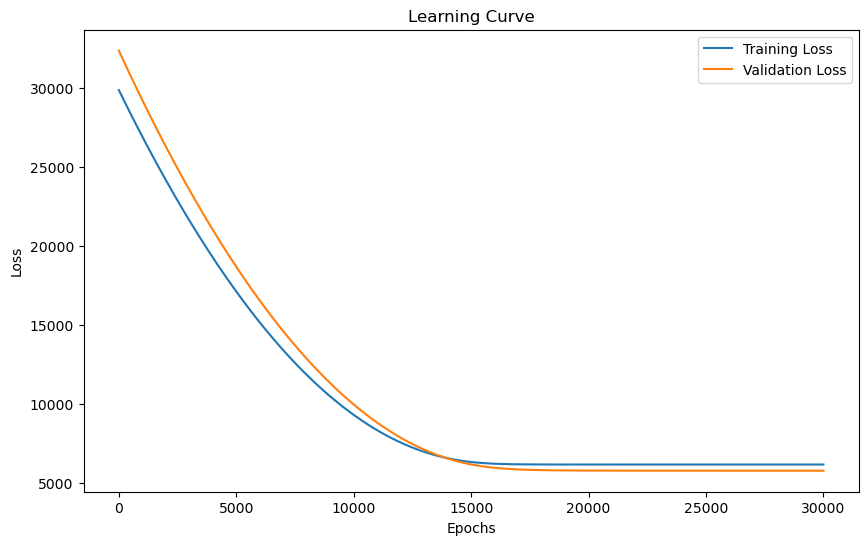

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Task 10

**TODO** try applying l1 and l2 regularization, does it help with the performance? Why?

**HINT** in pytorch l2 can be applied by adding weight decay to optimizer, and for adding L1, you can choose HuberLoss instead of MSE. Or feel free to apply them manually

In [40]:
my_model = NeuralNet(in_dimension=10, hidden_nodes=1, num_hidden_layers=1, out_dimension=1)

# TODO: instantiate loss with HuberLoss for L1 regularization
criterion = nn.SmoothL1Loss()

# TODO: instantiate a suitable optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(my_model.parameters(), lr=0.001, weight_decay=1e-5)

best_model, train_losses, val_losses = a_proper_training(
    30000, my_model, optimizer, criterion, train_loader, valid_loader
)

C:\Users\danie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
C:\Users\danie\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch 1, Validation Loss: 161.6796
Epoch 2, Validation Loss: 161.6696
Epoch 3, Validation Loss: 161.6596
Epoch 4, Validation Loss: 161.6496
Epoch 5, Validation Loss: 161.6396
Epoch 6, Validation Loss: 161.6296
Epoch 7, Validation Loss: 161.6196
Epoch 8, Validation Loss: 161.6096
Epoch 9, Validation Loss: 161.5996
Epoch 10, Validation Loss: 161.5865
Epoch 11, Validation Loss: 161.5649
Epoch 12, Validation Loss: 161.5373
Epoch 13, Validation Loss: 161.5054
Epoch 14, Validation Loss: 161.4728
Epoch 15, Validation Loss: 161.4406
Epoch 16, Validation Loss: 161.4082
Epoch 17, Validation Loss: 161.3757
Epoch 18, Validation Loss: 161.3441
Epoch 19, Validation Loss: 161.3134
Epoch 20, Validation Loss: 161.2830
Epoch 21, Validation Loss: 161.2531
Epoch 22, Validation Loss: 161.2220
Epoch 23, Validation Loss: 161.1905
Epoch 24, Validation Loss: 161.1589
Epoch 25, Validation Loss: 161.1271
Epoch 26, Validation Loss: 161.0952
Epoch 27, Validation Loss: 161.0628
Epoch 28, Validation Loss: 161.0292
E

Epoch 231, Validation Loss: 146.5461
Epoch 232, Validation Loss: 146.4421
Epoch 233, Validation Loss: 146.3401
Epoch 234, Validation Loss: 146.2379
Epoch 235, Validation Loss: 146.1331
Epoch 236, Validation Loss: 146.0314
Epoch 237, Validation Loss: 145.9263
Epoch 238, Validation Loss: 145.8215
Epoch 239, Validation Loss: 145.7138
Epoch 240, Validation Loss: 145.6088
Epoch 241, Validation Loss: 145.4999
Epoch 242, Validation Loss: 145.3938
Epoch 243, Validation Loss: 145.2908
Epoch 244, Validation Loss: 145.1855
Epoch 245, Validation Loss: 145.0804
Epoch 246, Validation Loss: 144.9776
Epoch 247, Validation Loss: 144.8671
Epoch 248, Validation Loss: 144.7592
Epoch 249, Validation Loss: 144.6477
Epoch 250, Validation Loss: 144.5353
Epoch 251, Validation Loss: 144.4240
Epoch 252, Validation Loss: 144.3143
Epoch 253, Validation Loss: 144.2108
Epoch 254, Validation Loss: 144.1072
Epoch 255, Validation Loss: 144.0000
Epoch 256, Validation Loss: 143.8929
Epoch 257, Validation Loss: 143.7885
E

Epoch 465, Validation Loss: 118.9266
Epoch 466, Validation Loss: 118.8084
Epoch 467, Validation Loss: 118.6932
Epoch 468, Validation Loss: 118.5841
Epoch 469, Validation Loss: 118.4804
Epoch 470, Validation Loss: 118.3743
Epoch 471, Validation Loss: 118.2600
Epoch 472, Validation Loss: 118.1482
Epoch 473, Validation Loss: 118.0352
Epoch 474, Validation Loss: 117.9322
Epoch 475, Validation Loss: 117.8226
Epoch 476, Validation Loss: 117.7105
Epoch 477, Validation Loss: 117.6028
Epoch 478, Validation Loss: 117.4923
Epoch 479, Validation Loss: 117.3895
Epoch 480, Validation Loss: 117.2760
Epoch 481, Validation Loss: 117.1620
Epoch 482, Validation Loss: 117.0530
Epoch 483, Validation Loss: 116.9382
Epoch 484, Validation Loss: 116.8278
Epoch 485, Validation Loss: 116.7145
Epoch 486, Validation Loss: 116.6151
Epoch 487, Validation Loss: 116.4997
Epoch 488, Validation Loss: 116.3870
Epoch 489, Validation Loss: 116.2811
Epoch 490, Validation Loss: 116.1714
Epoch 491, Validation Loss: 116.0809
E

Epoch 697, Validation Loss: 97.8662
Epoch 698, Validation Loss: 97.8135
Epoch 699, Validation Loss: 97.7579
Epoch 700, Validation Loss: 97.7014
Epoch 701, Validation Loss: 97.6474
Epoch 702, Validation Loss: 97.5724
Epoch 703, Validation Loss: 97.5037
Epoch 704, Validation Loss: 97.4500
Epoch 705, Validation Loss: 97.4012
Epoch 706, Validation Loss: 97.3418
Epoch 707, Validation Loss: 97.2667
Epoch 708, Validation Loss: 97.1979
Epoch 709, Validation Loss: 97.1351
Epoch 710, Validation Loss: 97.0597
Epoch 711, Validation Loss: 97.0010
Epoch 712, Validation Loss: 96.9349
Epoch 713, Validation Loss: 96.8831
Epoch 714, Validation Loss: 96.8264
Epoch 715, Validation Loss: 96.7679
Epoch 716, Validation Loss: 96.7289
Epoch 717, Validation Loss: 96.6813
Epoch 718, Validation Loss: 96.6443
Epoch 719, Validation Loss: 96.5915
Epoch 720, Validation Loss: 96.5333
Epoch 721, Validation Loss: 96.4600
Epoch 722, Validation Loss: 96.4056
Epoch 723, Validation Loss: 96.3550
Epoch 724, Validation Loss: 

Epoch 930, Validation Loss: 90.5651
Epoch 931, Validation Loss: 90.5653
Epoch 932, Validation Loss: 90.5642
Epoch 933, Validation Loss: 90.5595
Epoch 934, Validation Loss: 90.5378
Epoch 935, Validation Loss: 90.5090
Epoch 936, Validation Loss: 90.5016
Epoch 937, Validation Loss: 90.4982
Epoch 938, Validation Loss: 90.4887
Epoch 939, Validation Loss: 90.4815
Epoch 940, Validation Loss: 90.4763
Epoch 941, Validation Loss: 90.4856
Epoch 942, Validation Loss: 90.4754
Epoch 943, Validation Loss: 90.4495
Epoch 944, Validation Loss: 90.4547
Epoch 945, Validation Loss: 90.4561
Epoch 946, Validation Loss: 90.4823
Epoch 947, Validation Loss: 90.4786
Epoch 948, Validation Loss: 90.4887
Epoch 949, Validation Loss: 90.4772
Epoch 950, Validation Loss: 90.4468
Epoch 951, Validation Loss: 90.4068
Epoch 952, Validation Loss: 90.3627
Epoch 953, Validation Loss: 90.3312
Epoch 954, Validation Loss: 90.3047
Epoch 955, Validation Loss: 90.3007
Epoch 956, Validation Loss: 90.2915
Epoch 957, Validation Loss: 

Epoch 1161, Validation Loss: 88.2408
Epoch 1162, Validation Loss: 88.2225
Epoch 1163, Validation Loss: 88.2162
Epoch 1164, Validation Loss: 88.1960
Epoch 1165, Validation Loss: 88.2120
Epoch 1166, Validation Loss: 88.2355
Epoch 1167, Validation Loss: 88.2434
Epoch 1168, Validation Loss: 88.2370
Epoch 1169, Validation Loss: 88.2085
Epoch 1170, Validation Loss: 88.1893
Epoch 1171, Validation Loss: 88.1976
Epoch 1172, Validation Loss: 88.1800
Epoch 1173, Validation Loss: 88.1569
Epoch 1174, Validation Loss: 88.1424
Epoch 1175, Validation Loss: 88.1507
Epoch 1176, Validation Loss: 88.1395
Epoch 1177, Validation Loss: 88.1164
Epoch 1178, Validation Loss: 88.0808
Epoch 1179, Validation Loss: 88.0759
Epoch 1180, Validation Loss: 88.0694
Epoch 1181, Validation Loss: 88.0503
Epoch 1182, Validation Loss: 88.0145
Epoch 1183, Validation Loss: 87.9867
Epoch 1184, Validation Loss: 87.9750
Epoch 1185, Validation Loss: 87.9749
Epoch 1186, Validation Loss: 87.9754
Epoch 1187, Validation Loss: 87.9802
E

Epoch 1393, Validation Loss: 87.1855
Epoch 1394, Validation Loss: 87.1799
Epoch 1395, Validation Loss: 87.1700
Epoch 1396, Validation Loss: 87.1404
Epoch 1397, Validation Loss: 87.1151
Epoch 1398, Validation Loss: 87.1120
Epoch 1399, Validation Loss: 87.1036
Epoch 1400, Validation Loss: 87.1049
Epoch 1401, Validation Loss: 87.0834
Epoch 1402, Validation Loss: 87.0668
Epoch 1403, Validation Loss: 87.0506
Epoch 1404, Validation Loss: 87.0130
Epoch 1405, Validation Loss: 87.0036
Epoch 1406, Validation Loss: 86.9881
Epoch 1407, Validation Loss: 86.9705
Epoch 1408, Validation Loss: 86.9512
Epoch 1409, Validation Loss: 86.9494
Epoch 1410, Validation Loss: 86.9485
Epoch 1411, Validation Loss: 86.9616
Epoch 1412, Validation Loss: 86.9726
Epoch 1413, Validation Loss: 86.9714
Epoch 1414, Validation Loss: 86.9688
Epoch 1415, Validation Loss: 86.9594
Epoch 1416, Validation Loss: 86.9464
Epoch 1417, Validation Loss: 86.9480
Epoch 1418, Validation Loss: 86.9416
Epoch 1419, Validation Loss: 86.9327
E

Epoch 1623, Validation Loss: 86.1754
Epoch 1624, Validation Loss: 86.1647
Epoch 1625, Validation Loss: 86.1579
Epoch 1626, Validation Loss: 86.1515
Epoch 1627, Validation Loss: 86.1532
Epoch 1628, Validation Loss: 86.1583
Epoch 1629, Validation Loss: 86.1660
Epoch 1630, Validation Loss: 86.1562
Epoch 1631, Validation Loss: 86.1507
Epoch 1632, Validation Loss: 86.1568
Epoch 1633, Validation Loss: 86.1774
Epoch 1634, Validation Loss: 86.1956
Epoch 1635, Validation Loss: 86.2042
Epoch 1636, Validation Loss: 86.2232
Epoch 1637, Validation Loss: 86.2270
Epoch 1638, Validation Loss: 86.2329
Epoch 1639, Validation Loss: 86.2210
Epoch 1640, Validation Loss: 86.2158
Epoch 1641, Validation Loss: 86.2237
Epoch 1642, Validation Loss: 86.2183
Epoch 1643, Validation Loss: 86.2193
Epoch 1644, Validation Loss: 86.2133
Epoch 1645, Validation Loss: 86.2137
Epoch 1646, Validation Loss: 86.2010
Epoch 1647, Validation Loss: 86.1786
Epoch 1648, Validation Loss: 86.1567
Epoch 1649, Validation Loss: 86.1421
E

Epoch 1857, Validation Loss: 85.6756
Epoch 1858, Validation Loss: 85.6749
Epoch 1859, Validation Loss: 85.6756
Epoch 1860, Validation Loss: 85.6749
Epoch 1861, Validation Loss: 85.6692
Epoch 1862, Validation Loss: 85.6648
Epoch 1863, Validation Loss: 85.6634
Epoch 1864, Validation Loss: 85.6682
Epoch 1865, Validation Loss: 85.6867
Epoch 1866, Validation Loss: 85.6900
Epoch 1867, Validation Loss: 85.6877
Epoch 1868, Validation Loss: 85.6805
Epoch 1869, Validation Loss: 85.6817
Epoch 1870, Validation Loss: 85.6942
Epoch 1871, Validation Loss: 85.6899
Epoch 1872, Validation Loss: 85.6809
Epoch 1873, Validation Loss: 85.6710
Epoch 1874, Validation Loss: 85.6628
Epoch 1875, Validation Loss: 85.6576
Epoch 1876, Validation Loss: 85.6594
Epoch 1877, Validation Loss: 85.6535
Epoch 1878, Validation Loss: 85.6477
Epoch 1879, Validation Loss: 85.6289
Epoch 1880, Validation Loss: 85.6039
Epoch 1881, Validation Loss: 85.5935
Epoch 1882, Validation Loss: 85.5914
Epoch 1883, Validation Loss: 85.6030
E

Epoch 2090, Validation Loss: 85.4816
Epoch 2091, Validation Loss: 85.4741
Epoch 2092, Validation Loss: 85.4618
Epoch 2093, Validation Loss: 85.4365
Epoch 2094, Validation Loss: 85.4182
Epoch 2095, Validation Loss: 85.4110
Epoch 2096, Validation Loss: 85.4198
Epoch 2097, Validation Loss: 85.4346
Epoch 2098, Validation Loss: 85.4475
Epoch 2099, Validation Loss: 85.4547
Epoch 2100, Validation Loss: 85.4503
Epoch 2101, Validation Loss: 85.4582
Epoch 2102, Validation Loss: 85.4501
Epoch 2103, Validation Loss: 85.4337
Epoch 2104, Validation Loss: 85.4274
Epoch 2105, Validation Loss: 85.4178
Epoch 2106, Validation Loss: 85.4041
Epoch 2107, Validation Loss: 85.3894
Epoch 2108, Validation Loss: 85.3725
Epoch 2109, Validation Loss: 85.3716
Epoch 2110, Validation Loss: 85.3583
Epoch 2111, Validation Loss: 85.3444
Epoch 2112, Validation Loss: 85.3400
Epoch 2113, Validation Loss: 85.3369
Epoch 2114, Validation Loss: 85.3371
Epoch 2115, Validation Loss: 85.3446
Epoch 2116, Validation Loss: 85.3425
E

Epoch 2323, Validation Loss: 84.7327
Epoch 2324, Validation Loss: 84.7235
Epoch 2325, Validation Loss: 84.7237
Epoch 2326, Validation Loss: 84.7187
Epoch 2327, Validation Loss: 84.7126
Epoch 2328, Validation Loss: 84.7040
Epoch 2329, Validation Loss: 84.6922
Epoch 2330, Validation Loss: 84.6769
Epoch 2331, Validation Loss: 84.6702
Epoch 2332, Validation Loss: 84.6676
Epoch 2333, Validation Loss: 84.6774
Epoch 2334, Validation Loss: 84.6795
Epoch 2335, Validation Loss: 84.6897
Epoch 2336, Validation Loss: 84.6985
Epoch 2337, Validation Loss: 84.6953
Epoch 2338, Validation Loss: 84.6986
Epoch 2339, Validation Loss: 84.6914
Epoch 2340, Validation Loss: 84.6850
Epoch 2341, Validation Loss: 84.6814
Epoch 2342, Validation Loss: 84.6833
Epoch 2343, Validation Loss: 84.6777
Epoch 2344, Validation Loss: 84.6677
Epoch 2345, Validation Loss: 84.6469
Epoch 2346, Validation Loss: 84.6332
Epoch 2347, Validation Loss: 84.6241
Epoch 2348, Validation Loss: 84.6078
Epoch 2349, Validation Loss: 84.6023
E

Epoch 2557, Validation Loss: 84.4326
Epoch 2558, Validation Loss: 84.4260
Epoch 2559, Validation Loss: 84.4087
Epoch 2560, Validation Loss: 84.4042
Epoch 2561, Validation Loss: 84.3953
Epoch 2562, Validation Loss: 84.3927
Epoch 2563, Validation Loss: 84.3835
Epoch 2564, Validation Loss: 84.3809
Epoch 2565, Validation Loss: 84.3713
Epoch 2566, Validation Loss: 84.3533
Epoch 2567, Validation Loss: 84.3323
Epoch 2568, Validation Loss: 84.3161
Epoch 2569, Validation Loss: 84.3034
Epoch 2570, Validation Loss: 84.2989
Epoch 2571, Validation Loss: 84.3048
Epoch 2572, Validation Loss: 84.3067
Epoch 2573, Validation Loss: 84.3061
Epoch 2574, Validation Loss: 84.3018
Epoch 2575, Validation Loss: 84.2853
Epoch 2576, Validation Loss: 84.2727
Epoch 2577, Validation Loss: 84.2684
Epoch 2578, Validation Loss: 84.2518
Epoch 2579, Validation Loss: 84.2509
Epoch 2580, Validation Loss: 84.2454
Epoch 2581, Validation Loss: 84.2441
Epoch 2582, Validation Loss: 84.2463
Epoch 2583, Validation Loss: 84.2470
E

Epoch 2792, Validation Loss: 83.7469
Epoch 2793, Validation Loss: 83.7396
Epoch 2794, Validation Loss: 83.7332
Epoch 2795, Validation Loss: 83.7219
Epoch 2796, Validation Loss: 83.7207
Epoch 2797, Validation Loss: 83.7235
Epoch 2798, Validation Loss: 83.7185
Epoch 2799, Validation Loss: 83.7135
Epoch 2800, Validation Loss: 83.7117
Epoch 2801, Validation Loss: 83.6997
Epoch 2802, Validation Loss: 83.6910
Epoch 2803, Validation Loss: 83.6860
Epoch 2804, Validation Loss: 83.6907
Epoch 2805, Validation Loss: 83.6947
Epoch 2806, Validation Loss: 83.6953
Epoch 2807, Validation Loss: 83.7043
Epoch 2808, Validation Loss: 83.7201
Epoch 2809, Validation Loss: 83.7232
Epoch 2810, Validation Loss: 83.7196
Epoch 2811, Validation Loss: 83.7041
Epoch 2812, Validation Loss: 83.7040
Epoch 2813, Validation Loss: 83.6989
Epoch 2814, Validation Loss: 83.6938
Epoch 2815, Validation Loss: 83.6902
Epoch 2816, Validation Loss: 83.6832
Epoch 2817, Validation Loss: 83.7009
Epoch 2818, Validation Loss: 83.7193
E

Epoch 3025, Validation Loss: 83.3167
Epoch 3026, Validation Loss: 83.3190
Epoch 3027, Validation Loss: 83.3211
Epoch 3028, Validation Loss: 83.3247
Epoch 3029, Validation Loss: 83.3196
Epoch 3030, Validation Loss: 83.3257
Epoch 3031, Validation Loss: 83.3259
Epoch 3032, Validation Loss: 83.3116
Epoch 3033, Validation Loss: 83.2967
Epoch 3034, Validation Loss: 83.3019
Epoch 3035, Validation Loss: 83.3067
Epoch 3036, Validation Loss: 83.3093
Epoch 3037, Validation Loss: 83.3127
Epoch 3038, Validation Loss: 83.3284
Epoch 3039, Validation Loss: 83.3383
Epoch 3040, Validation Loss: 83.3556
Epoch 3041, Validation Loss: 83.3605
Epoch 3042, Validation Loss: 83.3538
Epoch 3043, Validation Loss: 83.3516
Epoch 3044, Validation Loss: 83.3593
Epoch 3045, Validation Loss: 83.3741
Epoch 3046, Validation Loss: 83.3719
Epoch 3047, Validation Loss: 83.3728
Epoch 3048, Validation Loss: 83.3833
Epoch 3049, Validation Loss: 83.3900
Epoch 3050, Validation Loss: 83.4057
Epoch 3051, Validation Loss: 83.4055
E

Epoch 3262, Validation Loss: 82.8743
Epoch 3263, Validation Loss: 82.8571
Epoch 3264, Validation Loss: 82.8572
Epoch 3265, Validation Loss: 82.8511
Epoch 3266, Validation Loss: 82.8544
Epoch 3267, Validation Loss: 82.8616
Epoch 3268, Validation Loss: 82.8566
Epoch 3269, Validation Loss: 82.8357
Epoch 3270, Validation Loss: 82.8215
Epoch 3271, Validation Loss: 82.8124
Epoch 3272, Validation Loss: 82.8032
Epoch 3273, Validation Loss: 82.7945
Epoch 3274, Validation Loss: 82.8043
Epoch 3275, Validation Loss: 82.8127
Epoch 3276, Validation Loss: 82.8012
Epoch 3277, Validation Loss: 82.8017
Epoch 3278, Validation Loss: 82.8003
Epoch 3279, Validation Loss: 82.7990
Epoch 3280, Validation Loss: 82.7936
Epoch 3281, Validation Loss: 82.7927
Epoch 3282, Validation Loss: 82.7924
Epoch 3283, Validation Loss: 82.8002
Epoch 3284, Validation Loss: 82.7946
Epoch 3285, Validation Loss: 82.7987
Epoch 3286, Validation Loss: 82.8152
Epoch 3287, Validation Loss: 82.8208
Epoch 3288, Validation Loss: 82.8215
E

Epoch 3498, Validation Loss: 82.2925
Epoch 3499, Validation Loss: 82.2826
Epoch 3500, Validation Loss: 82.2766
Epoch 3501, Validation Loss: 82.2614
Epoch 3502, Validation Loss: 82.2464
Epoch 3503, Validation Loss: 82.2421
Epoch 3504, Validation Loss: 82.2342
Epoch 3505, Validation Loss: 82.2233
Epoch 3506, Validation Loss: 82.2206
Epoch 3507, Validation Loss: 82.2200
Epoch 3508, Validation Loss: 82.2223
Epoch 3509, Validation Loss: 82.2222
Epoch 3510, Validation Loss: 82.2233
Epoch 3511, Validation Loss: 82.2333
Epoch 3512, Validation Loss: 82.2464
Epoch 3513, Validation Loss: 82.2483
Epoch 3514, Validation Loss: 82.2430
Epoch 3515, Validation Loss: 82.2441
Epoch 3516, Validation Loss: 82.2627
Epoch 3517, Validation Loss: 82.2792
Epoch 3518, Validation Loss: 82.2897
Epoch 3519, Validation Loss: 82.3019
Epoch 3520, Validation Loss: 82.2987
Epoch 3521, Validation Loss: 82.2894
Epoch 3522, Validation Loss: 82.2724
Epoch 3523, Validation Loss: 82.2715
Epoch 3524, Validation Loss: 82.2617
E

Epoch 3735, Validation Loss: 81.9501
Epoch 3736, Validation Loss: 81.9419
Epoch 3737, Validation Loss: 81.9234
Epoch 3738, Validation Loss: 81.9228
Epoch 3739, Validation Loss: 81.9121
Epoch 3740, Validation Loss: 81.9056
Epoch 3741, Validation Loss: 81.9024
Epoch 3742, Validation Loss: 81.9108
Epoch 3743, Validation Loss: 81.9159
Epoch 3744, Validation Loss: 81.9158
Epoch 3745, Validation Loss: 81.9095
Epoch 3746, Validation Loss: 81.9079
Epoch 3747, Validation Loss: 81.8996
Epoch 3748, Validation Loss: 81.9026
Epoch 3749, Validation Loss: 81.8895
Epoch 3750, Validation Loss: 81.8787
Epoch 3751, Validation Loss: 81.8912
Epoch 3752, Validation Loss: 81.9039
Epoch 3753, Validation Loss: 81.9258
Epoch 3754, Validation Loss: 81.9519
Epoch 3755, Validation Loss: 81.9590
Epoch 3756, Validation Loss: 81.9568
Epoch 3757, Validation Loss: 81.9490
Epoch 3758, Validation Loss: 81.9399
Epoch 3759, Validation Loss: 81.9440
Epoch 3760, Validation Loss: 81.9491
Epoch 3761, Validation Loss: 81.9576
E

Epoch 3972, Validation Loss: 81.5439
Epoch 3973, Validation Loss: 81.5533
Epoch 3974, Validation Loss: 81.5487
Epoch 3975, Validation Loss: 81.5535
Epoch 3976, Validation Loss: 81.5554
Epoch 3977, Validation Loss: 81.5645
Epoch 3978, Validation Loss: 81.5583
Epoch 3979, Validation Loss: 81.5483
Epoch 3980, Validation Loss: 81.5449
Epoch 3981, Validation Loss: 81.5479
Epoch 3982, Validation Loss: 81.5407
Epoch 3983, Validation Loss: 81.5332
Epoch 3984, Validation Loss: 81.5182
Epoch 3985, Validation Loss: 81.5182
Epoch 3986, Validation Loss: 81.5244
Epoch 3987, Validation Loss: 81.5375
Epoch 3988, Validation Loss: 81.5328
Epoch 3989, Validation Loss: 81.5268
Epoch 3990, Validation Loss: 81.5161
Epoch 3991, Validation Loss: 81.4925
Epoch 3992, Validation Loss: 81.4719
Epoch 3993, Validation Loss: 81.4668
Epoch 3994, Validation Loss: 81.4590
Epoch 3995, Validation Loss: 81.4554
Epoch 3996, Validation Loss: 81.4585
Epoch 3997, Validation Loss: 81.4698
Epoch 3998, Validation Loss: 81.4620
E

Epoch 4209, Validation Loss: 80.9054
Epoch 4210, Validation Loss: 80.8981
Epoch 4211, Validation Loss: 80.9065
Epoch 4212, Validation Loss: 80.9208
Epoch 4213, Validation Loss: 80.9317
Epoch 4214, Validation Loss: 80.9417
Epoch 4215, Validation Loss: 80.9313
Epoch 4216, Validation Loss: 80.9139
Epoch 4217, Validation Loss: 80.9160
Epoch 4218, Validation Loss: 80.9038
Epoch 4219, Validation Loss: 80.8936
Epoch 4220, Validation Loss: 80.8943
Epoch 4221, Validation Loss: 80.8919
Epoch 4222, Validation Loss: 80.8905
Epoch 4223, Validation Loss: 80.8750
Epoch 4224, Validation Loss: 80.8519
Epoch 4225, Validation Loss: 80.8348
Epoch 4226, Validation Loss: 80.8184
Epoch 4227, Validation Loss: 80.8009
Epoch 4228, Validation Loss: 80.7932
Epoch 4229, Validation Loss: 80.7894
Epoch 4230, Validation Loss: 80.7892
Epoch 4231, Validation Loss: 80.7926
Epoch 4232, Validation Loss: 80.7909
Epoch 4233, Validation Loss: 80.7993
Epoch 4234, Validation Loss: 80.7961
Epoch 4235, Validation Loss: 80.8140
E

Epoch 4446, Validation Loss: 80.3350
Epoch 4447, Validation Loss: 80.3445
Epoch 4448, Validation Loss: 80.3393
Epoch 4449, Validation Loss: 80.3286
Epoch 4450, Validation Loss: 80.3171
Epoch 4451, Validation Loss: 80.3026
Epoch 4452, Validation Loss: 80.2906
Epoch 4453, Validation Loss: 80.2826
Epoch 4454, Validation Loss: 80.2723
Epoch 4455, Validation Loss: 80.2615
Epoch 4456, Validation Loss: 80.2576
Epoch 4457, Validation Loss: 80.2521
Epoch 4458, Validation Loss: 80.2487
Epoch 4459, Validation Loss: 80.2420
Epoch 4460, Validation Loss: 80.2574
Epoch 4461, Validation Loss: 80.2697
Epoch 4462, Validation Loss: 80.2740
Epoch 4463, Validation Loss: 80.2726
Epoch 4464, Validation Loss: 80.2754
Epoch 4465, Validation Loss: 80.2729
Epoch 4466, Validation Loss: 80.2751
Epoch 4467, Validation Loss: 80.2776
Epoch 4468, Validation Loss: 80.2734
Epoch 4469, Validation Loss: 80.2831
Epoch 4470, Validation Loss: 80.2748
Epoch 4471, Validation Loss: 80.2647
Epoch 4472, Validation Loss: 80.2452
E

Epoch 4682, Validation Loss: 79.9111
Epoch 4683, Validation Loss: 79.9125
Epoch 4684, Validation Loss: 79.9087
Epoch 4685, Validation Loss: 79.8974
Epoch 4686, Validation Loss: 79.8906
Epoch 4687, Validation Loss: 79.8848
Epoch 4688, Validation Loss: 79.8935
Epoch 4689, Validation Loss: 79.8948
Epoch 4690, Validation Loss: 79.8961
Epoch 4691, Validation Loss: 79.8943
Epoch 4692, Validation Loss: 79.9040
Epoch 4693, Validation Loss: 79.8955
Epoch 4694, Validation Loss: 79.8844
Epoch 4695, Validation Loss: 79.8705
Epoch 4696, Validation Loss: 79.8581
Epoch 4697, Validation Loss: 79.8498
Epoch 4698, Validation Loss: 79.8506
Epoch 4699, Validation Loss: 79.8498
Epoch 4700, Validation Loss: 79.8532
Epoch 4701, Validation Loss: 79.8550
Epoch 4702, Validation Loss: 79.8596
Epoch 4703, Validation Loss: 79.8550
Epoch 4704, Validation Loss: 79.8498
Epoch 4705, Validation Loss: 79.8414
Epoch 4706, Validation Loss: 79.8352
Epoch 4707, Validation Loss: 79.8312
Epoch 4708, Validation Loss: 79.8265
E

Epoch 4917, Validation Loss: 79.5252
Epoch 4918, Validation Loss: 79.5235
Epoch 4919, Validation Loss: 79.5169
Epoch 4920, Validation Loss: 79.5106
Epoch 4921, Validation Loss: 79.5053
Epoch 4922, Validation Loss: 79.5084
Epoch 4923, Validation Loss: 79.5100
Epoch 4924, Validation Loss: 79.5148
Epoch 4925, Validation Loss: 79.5171
Epoch 4926, Validation Loss: 79.5210
Epoch 4927, Validation Loss: 79.5120
Epoch 4928, Validation Loss: 79.5085
Epoch 4929, Validation Loss: 79.4910
Epoch 4930, Validation Loss: 79.4754
Epoch 4931, Validation Loss: 79.4657
Epoch 4932, Validation Loss: 79.4567
Epoch 4933, Validation Loss: 79.4663
Epoch 4934, Validation Loss: 79.4748
Epoch 4935, Validation Loss: 79.4709
Epoch 4936, Validation Loss: 79.4517
Epoch 4937, Validation Loss: 79.4458
Epoch 4938, Validation Loss: 79.4512
Epoch 4939, Validation Loss: 79.4519
Epoch 4940, Validation Loss: 79.4535
Epoch 4941, Validation Loss: 79.4508
Epoch 4942, Validation Loss: 79.4451
Epoch 4943, Validation Loss: 79.4497
E

Epoch 5150, Validation Loss: 78.9899
Epoch 5151, Validation Loss: 78.9809
Epoch 5152, Validation Loss: 78.9811
Epoch 5153, Validation Loss: 78.9850
Epoch 5154, Validation Loss: 78.9779
Epoch 5155, Validation Loss: 78.9838
Epoch 5156, Validation Loss: 78.9901
Epoch 5157, Validation Loss: 78.9915
Epoch 5158, Validation Loss: 78.9911
Epoch 5159, Validation Loss: 78.9856
Epoch 5160, Validation Loss: 78.9697
Epoch 5161, Validation Loss: 78.9599
Epoch 5162, Validation Loss: 78.9539
Epoch 5163, Validation Loss: 78.9544
Epoch 5164, Validation Loss: 78.9590
Epoch 5165, Validation Loss: 78.9671
Epoch 5166, Validation Loss: 78.9739
Epoch 5167, Validation Loss: 78.9814
Epoch 5168, Validation Loss: 78.9926
Epoch 5169, Validation Loss: 79.0027
Epoch 5170, Validation Loss: 79.0102
Epoch 5171, Validation Loss: 79.0066
Epoch 5172, Validation Loss: 79.0099
Epoch 5173, Validation Loss: 79.0170
Epoch 5174, Validation Loss: 79.0103
Epoch 5175, Validation Loss: 79.0051
Epoch 5176, Validation Loss: 78.9986
E

Epoch 5386, Validation Loss: 78.6783
Epoch 5387, Validation Loss: 78.6789
Epoch 5388, Validation Loss: 78.6793
Epoch 5389, Validation Loss: 78.6817
Epoch 5390, Validation Loss: 78.6795
Epoch 5391, Validation Loss: 78.6685
Epoch 5392, Validation Loss: 78.6626
Epoch 5393, Validation Loss: 78.6641
Epoch 5394, Validation Loss: 78.6694
Epoch 5395, Validation Loss: 78.6656
Epoch 5396, Validation Loss: 78.6545
Epoch 5397, Validation Loss: 78.6451
Epoch 5398, Validation Loss: 78.6301
Epoch 5399, Validation Loss: 78.6241
Epoch 5400, Validation Loss: 78.6140
Epoch 5401, Validation Loss: 78.5995
Epoch 5402, Validation Loss: 78.5906
Epoch 5403, Validation Loss: 78.5751
Epoch 5404, Validation Loss: 78.5756
Epoch 5405, Validation Loss: 78.5707
Epoch 5406, Validation Loss: 78.5727
Epoch 5407, Validation Loss: 78.5825
Epoch 5408, Validation Loss: 78.5824
Epoch 5409, Validation Loss: 78.5724
Epoch 5410, Validation Loss: 78.5673
Epoch 5411, Validation Loss: 78.5650
Epoch 5412, Validation Loss: 78.5517
E

Epoch 5622, Validation Loss: 78.1148
Epoch 5623, Validation Loss: 78.1204
Epoch 5624, Validation Loss: 78.1118
Epoch 5625, Validation Loss: 78.0954
Epoch 5626, Validation Loss: 78.0788
Epoch 5627, Validation Loss: 78.0809
Epoch 5628, Validation Loss: 78.0870
Epoch 5629, Validation Loss: 78.0788
Epoch 5630, Validation Loss: 78.0721
Epoch 5631, Validation Loss: 78.0665
Epoch 5632, Validation Loss: 78.0626
Epoch 5633, Validation Loss: 78.0649
Epoch 5634, Validation Loss: 78.0774
Epoch 5635, Validation Loss: 78.0936
Epoch 5636, Validation Loss: 78.1019
Epoch 5637, Validation Loss: 78.1077
Epoch 5638, Validation Loss: 78.1009
Epoch 5639, Validation Loss: 78.0916
Epoch 5640, Validation Loss: 78.0837
Epoch 5641, Validation Loss: 78.0832
Epoch 5642, Validation Loss: 78.0733
Epoch 5643, Validation Loss: 78.0748
Epoch 5644, Validation Loss: 78.0734
Epoch 5645, Validation Loss: 78.0591
Epoch 5646, Validation Loss: 78.0511
Epoch 5647, Validation Loss: 78.0482
Epoch 5648, Validation Loss: 78.0560
E

Epoch 5856, Validation Loss: 77.6529
Epoch 5857, Validation Loss: 77.6484
Epoch 5858, Validation Loss: 77.6368
Epoch 5859, Validation Loss: 77.6382
Epoch 5860, Validation Loss: 77.6449
Epoch 5861, Validation Loss: 77.6391
Epoch 5862, Validation Loss: 77.6314
Epoch 5863, Validation Loss: 77.6254
Epoch 5864, Validation Loss: 77.6192
Epoch 5865, Validation Loss: 77.6132
Epoch 5866, Validation Loss: 77.6002
Epoch 5867, Validation Loss: 77.5892
Epoch 5868, Validation Loss: 77.5881
Epoch 5869, Validation Loss: 77.5884
Epoch 5870, Validation Loss: 77.5762
Epoch 5871, Validation Loss: 77.5629
Epoch 5872, Validation Loss: 77.5544
Epoch 5873, Validation Loss: 77.5393
Epoch 5874, Validation Loss: 77.5241
Epoch 5875, Validation Loss: 77.5185
Epoch 5876, Validation Loss: 77.5137
Epoch 5877, Validation Loss: 77.5063
Epoch 5878, Validation Loss: 77.4957
Epoch 5879, Validation Loss: 77.4908
Epoch 5880, Validation Loss: 77.4864
Epoch 5881, Validation Loss: 77.4861
Epoch 5882, Validation Loss: 77.4904
E

Epoch 6092, Validation Loss: 77.1075
Epoch 6093, Validation Loss: 77.1076
Epoch 6094, Validation Loss: 77.1005
Epoch 6095, Validation Loss: 77.0934
Epoch 6096, Validation Loss: 77.0983
Epoch 6097, Validation Loss: 77.0967
Epoch 6098, Validation Loss: 77.0945
Epoch 6099, Validation Loss: 77.0912
Epoch 6100, Validation Loss: 77.0895
Epoch 6101, Validation Loss: 77.0872
Epoch 6102, Validation Loss: 77.0810
Epoch 6103, Validation Loss: 77.0731
Epoch 6104, Validation Loss: 77.0577
Epoch 6105, Validation Loss: 77.0483
Epoch 6106, Validation Loss: 77.0378
Epoch 6107, Validation Loss: 77.0309
Epoch 6108, Validation Loss: 77.0265
Epoch 6109, Validation Loss: 77.0207
Epoch 6110, Validation Loss: 77.0204
Epoch 6111, Validation Loss: 77.0150
Epoch 6112, Validation Loss: 77.0121
Epoch 6113, Validation Loss: 77.0170
Epoch 6114, Validation Loss: 77.0221
Epoch 6115, Validation Loss: 77.0294
Epoch 6116, Validation Loss: 77.0320
Epoch 6117, Validation Loss: 77.0340
Epoch 6118, Validation Loss: 77.0407
E

Epoch 6329, Validation Loss: 76.6393
Epoch 6330, Validation Loss: 76.6485
Epoch 6331, Validation Loss: 76.6546
Epoch 6332, Validation Loss: 76.6561
Epoch 6333, Validation Loss: 76.6616
Epoch 6334, Validation Loss: 76.6635
Epoch 6335, Validation Loss: 76.6519
Epoch 6336, Validation Loss: 76.6507
Epoch 6337, Validation Loss: 76.6547
Epoch 6338, Validation Loss: 76.6629
Epoch 6339, Validation Loss: 76.6716
Epoch 6340, Validation Loss: 76.6770
Epoch 6341, Validation Loss: 76.6759
Epoch 6342, Validation Loss: 76.6724
Epoch 6343, Validation Loss: 76.6638
Epoch 6344, Validation Loss: 76.6609
Epoch 6345, Validation Loss: 76.6592
Epoch 6346, Validation Loss: 76.6564
Epoch 6347, Validation Loss: 76.6638
Epoch 6348, Validation Loss: 76.6634
Epoch 6349, Validation Loss: 76.6581
Epoch 6350, Validation Loss: 76.6523
Epoch 6351, Validation Loss: 76.6490
Epoch 6352, Validation Loss: 76.6562
Epoch 6353, Validation Loss: 76.6597
Epoch 6354, Validation Loss: 76.6563
Epoch 6355, Validation Loss: 76.6556
E

Epoch 6560, Validation Loss: 76.2375
Epoch 6561, Validation Loss: 76.2337
Epoch 6562, Validation Loss: 76.2285
Epoch 6563, Validation Loss: 76.2249
Epoch 6564, Validation Loss: 76.2249
Epoch 6565, Validation Loss: 76.2269
Epoch 6566, Validation Loss: 76.2210
Epoch 6567, Validation Loss: 76.2238
Epoch 6568, Validation Loss: 76.2203
Epoch 6569, Validation Loss: 76.2168
Epoch 6570, Validation Loss: 76.2148
Epoch 6571, Validation Loss: 76.2251
Epoch 6572, Validation Loss: 76.2282
Epoch 6573, Validation Loss: 76.2229
Epoch 6574, Validation Loss: 76.2140
Epoch 6575, Validation Loss: 76.2029
Epoch 6576, Validation Loss: 76.1956
Epoch 6577, Validation Loss: 76.1793
Epoch 6578, Validation Loss: 76.1585
Epoch 6579, Validation Loss: 76.1554
Epoch 6580, Validation Loss: 76.1623
Epoch 6581, Validation Loss: 76.1569
Epoch 6582, Validation Loss: 76.1452
Epoch 6583, Validation Loss: 76.1356
Epoch 6584, Validation Loss: 76.1310
Epoch 6585, Validation Loss: 76.1264
Epoch 6586, Validation Loss: 76.1255
E

Epoch 6795, Validation Loss: 75.8507
Epoch 6796, Validation Loss: 75.8602
Epoch 6797, Validation Loss: 75.8621
Epoch 6798, Validation Loss: 75.8644
Epoch 6799, Validation Loss: 75.8649
Epoch 6800, Validation Loss: 75.8681
Epoch 6801, Validation Loss: 75.8664
Epoch 6802, Validation Loss: 75.8699
Epoch 6803, Validation Loss: 75.8632
Epoch 6804, Validation Loss: 75.8503
Epoch 6805, Validation Loss: 75.8431
Epoch 6806, Validation Loss: 75.8392
Epoch 6807, Validation Loss: 75.8357
Epoch 6808, Validation Loss: 75.8415
Epoch 6809, Validation Loss: 75.8442
Epoch 6810, Validation Loss: 75.8543
Epoch 6811, Validation Loss: 75.8615
Epoch 6812, Validation Loss: 75.8658
Epoch 6813, Validation Loss: 75.8657
Epoch 6814, Validation Loss: 75.8621
Epoch 6815, Validation Loss: 75.8588
Epoch 6816, Validation Loss: 75.8561
Epoch 6817, Validation Loss: 75.8470
Epoch 6818, Validation Loss: 75.8495
Epoch 6819, Validation Loss: 75.8473
Epoch 6820, Validation Loss: 75.8500
Epoch 6821, Validation Loss: 75.8504
E

Epoch 7032, Validation Loss: 75.3172
Epoch 7033, Validation Loss: 75.3210
Epoch 7034, Validation Loss: 75.3360
Epoch 7035, Validation Loss: 75.3500
Epoch 7036, Validation Loss: 75.3555
Epoch 7037, Validation Loss: 75.3552
Epoch 7038, Validation Loss: 75.3518
Epoch 7039, Validation Loss: 75.3563
Epoch 7040, Validation Loss: 75.3589
Epoch 7041, Validation Loss: 75.3532
Epoch 7042, Validation Loss: 75.3582
Epoch 7043, Validation Loss: 75.3705
Epoch 7044, Validation Loss: 75.3683
Epoch 7045, Validation Loss: 75.3674
Epoch 7046, Validation Loss: 75.3677
Epoch 7047, Validation Loss: 75.3677
Epoch 7048, Validation Loss: 75.3744
Epoch 7049, Validation Loss: 75.3725
Epoch 7050, Validation Loss: 75.3620
Epoch 7051, Validation Loss: 75.3583
Epoch 7052, Validation Loss: 75.3587
Epoch 7053, Validation Loss: 75.3561
Epoch 7054, Validation Loss: 75.3579
Epoch 7055, Validation Loss: 75.3605
Epoch 7056, Validation Loss: 75.3552
Epoch 7057, Validation Loss: 75.3531
Epoch 7058, Validation Loss: 75.3508
E

Epoch 7269, Validation Loss: 74.9462
Epoch 7270, Validation Loss: 74.9517
Epoch 7271, Validation Loss: 74.9543
Epoch 7272, Validation Loss: 74.9527
Epoch 7273, Validation Loss: 74.9491
Epoch 7274, Validation Loss: 74.9460
Epoch 7275, Validation Loss: 74.9443
Epoch 7276, Validation Loss: 74.9390
Epoch 7277, Validation Loss: 74.9347
Epoch 7278, Validation Loss: 74.9365
Epoch 7279, Validation Loss: 74.9407
Epoch 7280, Validation Loss: 74.9425
Epoch 7281, Validation Loss: 74.9468
Epoch 7282, Validation Loss: 74.9467
Epoch 7283, Validation Loss: 74.9467
Epoch 7284, Validation Loss: 74.9427
Epoch 7285, Validation Loss: 74.9381
Epoch 7286, Validation Loss: 74.9427
Epoch 7287, Validation Loss: 74.9557
Epoch 7288, Validation Loss: 74.9592
Epoch 7289, Validation Loss: 74.9486
Epoch 7290, Validation Loss: 74.9376
Epoch 7291, Validation Loss: 74.9279
Epoch 7292, Validation Loss: 74.9276
Epoch 7293, Validation Loss: 74.9255
Epoch 7294, Validation Loss: 74.9167
Epoch 7295, Validation Loss: 74.9045
E

Epoch 7507, Validation Loss: 74.5682
Epoch 7508, Validation Loss: 74.5732
Epoch 7509, Validation Loss: 74.5773
Epoch 7510, Validation Loss: 74.5797
Epoch 7511, Validation Loss: 74.5809
Epoch 7512, Validation Loss: 74.5814
Epoch 7513, Validation Loss: 74.5817
Epoch 7514, Validation Loss: 74.5730
Epoch 7515, Validation Loss: 74.5631
Epoch 7516, Validation Loss: 74.5581
Epoch 7517, Validation Loss: 74.5533
Epoch 7518, Validation Loss: 74.5498
Epoch 7519, Validation Loss: 74.5473
Epoch 7520, Validation Loss: 74.5400
Epoch 7521, Validation Loss: 74.5349
Epoch 7522, Validation Loss: 74.5346
Epoch 7523, Validation Loss: 74.5301
Epoch 7524, Validation Loss: 74.5238
Epoch 7525, Validation Loss: 74.5212
Epoch 7526, Validation Loss: 74.5164
Epoch 7527, Validation Loss: 74.5143
Epoch 7528, Validation Loss: 74.5132
Epoch 7529, Validation Loss: 74.5095
Epoch 7530, Validation Loss: 74.5150
Epoch 7531, Validation Loss: 74.5173
Epoch 7532, Validation Loss: 74.5156
Epoch 7533, Validation Loss: 74.5096
E

Epoch 7744, Validation Loss: 74.1850
Epoch 7745, Validation Loss: 74.1781
Epoch 7746, Validation Loss: 74.1737
Epoch 7747, Validation Loss: 74.1717
Epoch 7748, Validation Loss: 74.1622
Epoch 7749, Validation Loss: 74.1510
Epoch 7750, Validation Loss: 74.1454
Epoch 7751, Validation Loss: 74.1373
Epoch 7752, Validation Loss: 74.1226
Epoch 7753, Validation Loss: 74.1104
Epoch 7754, Validation Loss: 74.1026
Epoch 7755, Validation Loss: 74.0990
Epoch 7756, Validation Loss: 74.1045
Epoch 7757, Validation Loss: 74.1038
Epoch 7758, Validation Loss: 74.1036
Epoch 7759, Validation Loss: 74.1007
Epoch 7760, Validation Loss: 74.1026
Epoch 7761, Validation Loss: 74.1036
Epoch 7762, Validation Loss: 74.1009
Epoch 7763, Validation Loss: 74.0949
Epoch 7764, Validation Loss: 74.0866
Epoch 7765, Validation Loss: 74.0792
Epoch 7766, Validation Loss: 74.0735
Epoch 7767, Validation Loss: 74.0672
Epoch 7768, Validation Loss: 74.0618
Epoch 7769, Validation Loss: 74.0550
Epoch 7770, Validation Loss: 74.0510
E

Epoch 7982, Validation Loss: 73.7093
Epoch 7983, Validation Loss: 73.7034
Epoch 7984, Validation Loss: 73.6935
Epoch 7985, Validation Loss: 73.6837
Epoch 7986, Validation Loss: 73.6747
Epoch 7987, Validation Loss: 73.6680
Epoch 7988, Validation Loss: 73.6673
Epoch 7989, Validation Loss: 73.6689
Epoch 7990, Validation Loss: 73.6743
Epoch 7991, Validation Loss: 73.6817
Epoch 7992, Validation Loss: 73.6825
Epoch 7993, Validation Loss: 73.6826
Epoch 7994, Validation Loss: 73.6790
Epoch 7995, Validation Loss: 73.6757
Epoch 7996, Validation Loss: 73.6746
Epoch 7997, Validation Loss: 73.6752
Epoch 7998, Validation Loss: 73.6736
Epoch 7999, Validation Loss: 73.6743
Epoch 8000, Validation Loss: 73.6732
Epoch 8001, Validation Loss: 73.6738
Epoch 8002, Validation Loss: 73.6722
Epoch 8003, Validation Loss: 73.6659
Epoch 8004, Validation Loss: 73.6605
Epoch 8005, Validation Loss: 73.6585
Epoch 8006, Validation Loss: 73.6650
Epoch 8007, Validation Loss: 73.6643
Epoch 8008, Validation Loss: 73.6605
E

Epoch 8220, Validation Loss: 73.2645
Epoch 8221, Validation Loss: 73.2637
Epoch 8222, Validation Loss: 73.2584
Epoch 8223, Validation Loss: 73.2521
Epoch 8224, Validation Loss: 73.2452
Epoch 8225, Validation Loss: 73.2378
Epoch 8226, Validation Loss: 73.2390
Epoch 8227, Validation Loss: 73.2345
Epoch 8228, Validation Loss: 73.2300
Epoch 8229, Validation Loss: 73.2263
Epoch 8230, Validation Loss: 73.2196
Epoch 8231, Validation Loss: 73.2137
Epoch 8232, Validation Loss: 73.2110
Epoch 8233, Validation Loss: 73.2134
Epoch 8234, Validation Loss: 73.2171
Epoch 8235, Validation Loss: 73.2137
Epoch 8236, Validation Loss: 73.2101
Epoch 8237, Validation Loss: 73.2093
Epoch 8238, Validation Loss: 73.2088
Epoch 8239, Validation Loss: 73.2019
Epoch 8240, Validation Loss: 73.1998
Epoch 8241, Validation Loss: 73.2036
Epoch 8242, Validation Loss: 73.1949
Epoch 8243, Validation Loss: 73.1918
Epoch 8244, Validation Loss: 73.1926
Epoch 8245, Validation Loss: 73.1898
Epoch 8246, Validation Loss: 73.1896
E

Epoch 8455, Validation Loss: 73.0149
Epoch 8456, Validation Loss: 73.0062
Epoch 8457, Validation Loss: 72.9979
Epoch 8458, Validation Loss: 72.9941
Epoch 8459, Validation Loss: 72.9941
Epoch 8460, Validation Loss: 72.9870
Epoch 8461, Validation Loss: 72.9823
Epoch 8462, Validation Loss: 72.9741
Epoch 8463, Validation Loss: 72.9732
Epoch 8464, Validation Loss: 72.9683
Epoch 8465, Validation Loss: 72.9645
Epoch 8466, Validation Loss: 72.9581
Epoch 8467, Validation Loss: 72.9518
Epoch 8468, Validation Loss: 72.9437
Epoch 8469, Validation Loss: 72.9336
Epoch 8470, Validation Loss: 72.9316
Epoch 8471, Validation Loss: 72.9319
Epoch 8472, Validation Loss: 72.9326
Epoch 8473, Validation Loss: 72.9283
Epoch 8474, Validation Loss: 72.9252
Epoch 8475, Validation Loss: 72.9260
Epoch 8476, Validation Loss: 72.9330
Epoch 8477, Validation Loss: 72.9348
Epoch 8478, Validation Loss: 72.9271
Epoch 8479, Validation Loss: 72.9293
Epoch 8480, Validation Loss: 72.9290
Epoch 8481, Validation Loss: 72.9305
E

Epoch 8692, Validation Loss: 72.4384
Epoch 8693, Validation Loss: 72.4384
Epoch 8694, Validation Loss: 72.4329
Epoch 8695, Validation Loss: 72.4300
Epoch 8696, Validation Loss: 72.4211
Epoch 8697, Validation Loss: 72.4184
Epoch 8698, Validation Loss: 72.4156
Epoch 8699, Validation Loss: 72.4120
Epoch 8700, Validation Loss: 72.4091
Epoch 8701, Validation Loss: 72.4095
Epoch 8702, Validation Loss: 72.4077
Epoch 8703, Validation Loss: 72.4025
Epoch 8704, Validation Loss: 72.4000
Epoch 8705, Validation Loss: 72.3970
Epoch 8706, Validation Loss: 72.3983
Epoch 8707, Validation Loss: 72.4030
Epoch 8708, Validation Loss: 72.4018
Epoch 8709, Validation Loss: 72.4007
Epoch 8710, Validation Loss: 72.3961
Epoch 8711, Validation Loss: 72.3908
Epoch 8712, Validation Loss: 72.3846
Epoch 8713, Validation Loss: 72.3841
Epoch 8714, Validation Loss: 72.3821
Epoch 8715, Validation Loss: 72.3799
Epoch 8716, Validation Loss: 72.3803
Epoch 8717, Validation Loss: 72.3750
Epoch 8718, Validation Loss: 72.3665
E

Epoch 8927, Validation Loss: 72.0066
Epoch 8928, Validation Loss: 72.0027
Epoch 8929, Validation Loss: 72.0000
Epoch 8930, Validation Loss: 71.9987
Epoch 8931, Validation Loss: 71.9968
Epoch 8932, Validation Loss: 71.9992
Epoch 8933, Validation Loss: 71.9985
Epoch 8934, Validation Loss: 71.9982
Epoch 8935, Validation Loss: 71.9951
Epoch 8936, Validation Loss: 71.9897
Epoch 8937, Validation Loss: 71.9892
Epoch 8938, Validation Loss: 71.9926
Epoch 8939, Validation Loss: 71.9925
Epoch 8940, Validation Loss: 71.9874
Epoch 8941, Validation Loss: 71.9880
Epoch 8942, Validation Loss: 71.9868
Epoch 8943, Validation Loss: 71.9805
Epoch 8944, Validation Loss: 71.9726
Epoch 8945, Validation Loss: 71.9667
Epoch 8946, Validation Loss: 71.9621
Epoch 8947, Validation Loss: 71.9573
Epoch 8948, Validation Loss: 71.9546
Epoch 8949, Validation Loss: 71.9565
Epoch 8950, Validation Loss: 71.9640
Epoch 8951, Validation Loss: 71.9659
Epoch 8952, Validation Loss: 71.9683
Epoch 8953, Validation Loss: 71.9693
E

Epoch 9165, Validation Loss: 71.7167
Epoch 9166, Validation Loss: 71.7130
Epoch 9167, Validation Loss: 71.7132
Epoch 9168, Validation Loss: 71.7133
Epoch 9169, Validation Loss: 71.7091
Epoch 9170, Validation Loss: 71.7062
Epoch 9171, Validation Loss: 71.7036
Epoch 9172, Validation Loss: 71.7044
Epoch 9173, Validation Loss: 71.7060
Epoch 9174, Validation Loss: 71.7081
Epoch 9175, Validation Loss: 71.7070
Epoch 9176, Validation Loss: 71.7035
Epoch 9177, Validation Loss: 71.6974
Epoch 9178, Validation Loss: 71.6953
Epoch 9179, Validation Loss: 71.6926
Epoch 9180, Validation Loss: 71.6881
Epoch 9181, Validation Loss: 71.6871
Epoch 9182, Validation Loss: 71.6886
Epoch 9183, Validation Loss: 71.6875
Epoch 9184, Validation Loss: 71.6867
Epoch 9185, Validation Loss: 71.6852
Epoch 9186, Validation Loss: 71.6828
Epoch 9187, Validation Loss: 71.6806
Epoch 9188, Validation Loss: 71.6823
Epoch 9189, Validation Loss: 71.6821
Epoch 9190, Validation Loss: 71.6876
Epoch 9191, Validation Loss: 71.6917
E

Epoch 9402, Validation Loss: 71.3072
Epoch 9403, Validation Loss: 71.3039
Epoch 9404, Validation Loss: 71.2977
Epoch 9405, Validation Loss: 71.2929
Epoch 9406, Validation Loss: 71.2906
Epoch 9407, Validation Loss: 71.2935
Epoch 9408, Validation Loss: 71.2980
Epoch 9409, Validation Loss: 71.2999
Epoch 9410, Validation Loss: 71.3023
Epoch 9411, Validation Loss: 71.3012
Epoch 9412, Validation Loss: 71.2987
Epoch 9413, Validation Loss: 71.2957
Epoch 9414, Validation Loss: 71.2946
Epoch 9415, Validation Loss: 71.2952
Epoch 9416, Validation Loss: 71.2988
Epoch 9417, Validation Loss: 71.3010
Epoch 9418, Validation Loss: 71.3008
Epoch 9419, Validation Loss: 71.2971
Epoch 9420, Validation Loss: 71.2923
Epoch 9421, Validation Loss: 71.2831
Epoch 9422, Validation Loss: 71.2781
Epoch 9423, Validation Loss: 71.2734
Epoch 9424, Validation Loss: 71.2685
Epoch 9425, Validation Loss: 71.2690
Epoch 9426, Validation Loss: 71.2672
Epoch 9427, Validation Loss: 71.2642
Epoch 9428, Validation Loss: 71.2601
E

Epoch 9639, Validation Loss: 70.8419
Epoch 9640, Validation Loss: 70.8370
Epoch 9641, Validation Loss: 70.8355
Epoch 9642, Validation Loss: 70.8343
Epoch 9643, Validation Loss: 70.8354
Epoch 9644, Validation Loss: 70.8311
Epoch 9645, Validation Loss: 70.8270
Epoch 9646, Validation Loss: 70.8202
Epoch 9647, Validation Loss: 70.8159
Epoch 9648, Validation Loss: 70.8124
Epoch 9649, Validation Loss: 70.8098
Epoch 9650, Validation Loss: 70.8131
Epoch 9651, Validation Loss: 70.8144
Epoch 9652, Validation Loss: 70.8161
Epoch 9653, Validation Loss: 70.8162
Epoch 9654, Validation Loss: 70.8131
Epoch 9655, Validation Loss: 70.8102
Epoch 9656, Validation Loss: 70.8110
Epoch 9657, Validation Loss: 70.8123
Epoch 9658, Validation Loss: 70.8140
Epoch 9659, Validation Loss: 70.8130
Epoch 9660, Validation Loss: 70.8122
Epoch 9661, Validation Loss: 70.8112
Epoch 9662, Validation Loss: 70.8109
Epoch 9663, Validation Loss: 70.8120
Epoch 9664, Validation Loss: 70.8110
Epoch 9665, Validation Loss: 70.8127
E

Epoch 9876, Validation Loss: 70.5793
Epoch 9877, Validation Loss: 70.5794
Epoch 9878, Validation Loss: 70.5819
Epoch 9879, Validation Loss: 70.5834
Epoch 9880, Validation Loss: 70.5859
Epoch 9881, Validation Loss: 70.5878
Epoch 9882, Validation Loss: 70.5868
Epoch 9883, Validation Loss: 70.5882
Epoch 9884, Validation Loss: 70.5875
Epoch 9885, Validation Loss: 70.5869
Epoch 9886, Validation Loss: 70.5851
Epoch 9887, Validation Loss: 70.5847
Epoch 9888, Validation Loss: 70.5884
Epoch 9889, Validation Loss: 70.5865
Epoch 9890, Validation Loss: 70.5838
Epoch 9891, Validation Loss: 70.5787
Epoch 9892, Validation Loss: 70.5740
Epoch 9893, Validation Loss: 70.5694
Epoch 9894, Validation Loss: 70.5663
Epoch 9895, Validation Loss: 70.5618
Epoch 9896, Validation Loss: 70.5598
Epoch 9897, Validation Loss: 70.5600
Epoch 9898, Validation Loss: 70.5616
Epoch 9899, Validation Loss: 70.5645
Epoch 9900, Validation Loss: 70.5670
Epoch 9901, Validation Loss: 70.5686
Epoch 9902, Validation Loss: 70.5682
E

Epoch 10113, Validation Loss: 70.2891
Epoch 10114, Validation Loss: 70.2872
Epoch 10115, Validation Loss: 70.2853
Epoch 10116, Validation Loss: 70.2835
Epoch 10117, Validation Loss: 70.2816
Epoch 10118, Validation Loss: 70.2797
Epoch 10119, Validation Loss: 70.2780
Epoch 10120, Validation Loss: 70.2762
Epoch 10121, Validation Loss: 70.2744
Epoch 10122, Validation Loss: 70.2726
Epoch 10123, Validation Loss: 70.2710
Epoch 10124, Validation Loss: 70.2694
Epoch 10125, Validation Loss: 70.2677
Epoch 10126, Validation Loss: 70.2660
Epoch 10127, Validation Loss: 70.2645
Epoch 10128, Validation Loss: 70.2631
Epoch 10129, Validation Loss: 70.2614
Epoch 10130, Validation Loss: 70.2596
Epoch 10131, Validation Loss: 70.2578
Epoch 10132, Validation Loss: 70.2561
Epoch 10133, Validation Loss: 70.2543
Epoch 10134, Validation Loss: 70.2526
Epoch 10135, Validation Loss: 70.2508
Epoch 10136, Validation Loss: 70.2489
Epoch 10137, Validation Loss: 70.2471
Epoch 10138, Validation Loss: 70.2454
Epoch 10139,

Epoch 10347, Validation Loss: 69.9100
Epoch 10348, Validation Loss: 69.9084
Epoch 10349, Validation Loss: 69.9068
Epoch 10350, Validation Loss: 69.9053
Epoch 10351, Validation Loss: 69.9037
Epoch 10352, Validation Loss: 69.9021
Epoch 10353, Validation Loss: 69.9005
Epoch 10354, Validation Loss: 69.8992
Epoch 10355, Validation Loss: 69.8978
Epoch 10356, Validation Loss: 69.8963
Epoch 10357, Validation Loss: 69.8946
Epoch 10358, Validation Loss: 69.8929
Epoch 10359, Validation Loss: 69.8913
Epoch 10360, Validation Loss: 69.8896
Epoch 10361, Validation Loss: 69.8878
Epoch 10362, Validation Loss: 69.8863
Epoch 10363, Validation Loss: 69.8844
Epoch 10364, Validation Loss: 69.8827
Epoch 10365, Validation Loss: 69.8810
Epoch 10366, Validation Loss: 69.8793
Epoch 10367, Validation Loss: 69.8779
Epoch 10368, Validation Loss: 69.8766
Epoch 10369, Validation Loss: 69.8752
Epoch 10370, Validation Loss: 69.8738
Epoch 10371, Validation Loss: 69.8725
Epoch 10372, Validation Loss: 69.8711
Epoch 10373,

Epoch 10583, Validation Loss: 69.5476
Epoch 10584, Validation Loss: 69.5456
Epoch 10585, Validation Loss: 69.5437
Epoch 10586, Validation Loss: 69.5419
Epoch 10587, Validation Loss: 69.5401
Epoch 10588, Validation Loss: 69.5385
Epoch 10589, Validation Loss: 69.5371
Epoch 10590, Validation Loss: 69.5358
Epoch 10591, Validation Loss: 69.5346
Epoch 10592, Validation Loss: 69.5332
Epoch 10593, Validation Loss: 69.5316
Epoch 10594, Validation Loss: 69.5299
Epoch 10595, Validation Loss: 69.5282
Epoch 10596, Validation Loss: 69.5269
Epoch 10597, Validation Loss: 69.5254
Epoch 10598, Validation Loss: 69.5241
Epoch 10599, Validation Loss: 69.5229
Epoch 10600, Validation Loss: 69.5215
Epoch 10601, Validation Loss: 69.5198
Epoch 10602, Validation Loss: 69.5183
Epoch 10603, Validation Loss: 69.5171
Epoch 10604, Validation Loss: 69.5157
Epoch 10605, Validation Loss: 69.5140
Epoch 10606, Validation Loss: 69.5126
Epoch 10607, Validation Loss: 69.5114
Epoch 10608, Validation Loss: 69.5101
Epoch 10609,

Epoch 10817, Validation Loss: 69.2061
Epoch 10818, Validation Loss: 69.2050
Epoch 10819, Validation Loss: 69.2038
Epoch 10820, Validation Loss: 69.2023
Epoch 10821, Validation Loss: 69.2008
Epoch 10822, Validation Loss: 69.1997
Epoch 10823, Validation Loss: 69.1984
Epoch 10824, Validation Loss: 69.1970
Epoch 10825, Validation Loss: 69.1956
Epoch 10826, Validation Loss: 69.1941
Epoch 10827, Validation Loss: 69.1927
Epoch 10828, Validation Loss: 69.1913
Epoch 10829, Validation Loss: 69.1898
Epoch 10830, Validation Loss: 69.1884
Epoch 10831, Validation Loss: 69.1873
Epoch 10832, Validation Loss: 69.1857
Epoch 10833, Validation Loss: 69.1843
Epoch 10834, Validation Loss: 69.1828
Epoch 10835, Validation Loss: 69.1814
Epoch 10836, Validation Loss: 69.1802
Epoch 10837, Validation Loss: 69.1786
Epoch 10838, Validation Loss: 69.1770
Epoch 10839, Validation Loss: 69.1756
Epoch 10840, Validation Loss: 69.1744
Epoch 10841, Validation Loss: 69.1731
Epoch 10842, Validation Loss: 69.1715
Epoch 10843,

Epoch 11053, Validation Loss: 68.9023
Epoch 11054, Validation Loss: 68.9010
Epoch 11055, Validation Loss: 68.8995
Epoch 11056, Validation Loss: 68.8981
Epoch 11057, Validation Loss: 68.8967
Epoch 11058, Validation Loss: 68.8954
Epoch 11059, Validation Loss: 68.8940
Epoch 11060, Validation Loss: 68.8929
Epoch 11061, Validation Loss: 68.8921
Epoch 11062, Validation Loss: 68.8910
Epoch 11063, Validation Loss: 68.8901
Epoch 11064, Validation Loss: 68.8894
Epoch 11065, Validation Loss: 68.8884
Epoch 11066, Validation Loss: 68.8878
Epoch 11067, Validation Loss: 68.8868
Epoch 11068, Validation Loss: 68.8857
Epoch 11069, Validation Loss: 68.8843
Epoch 11070, Validation Loss: 68.8829
Epoch 11071, Validation Loss: 68.8814
Epoch 11072, Validation Loss: 68.8800
Epoch 11073, Validation Loss: 68.8786
Epoch 11074, Validation Loss: 68.8772
Epoch 11075, Validation Loss: 68.8757
Epoch 11076, Validation Loss: 68.8744
Epoch 11077, Validation Loss: 68.8731
Epoch 11078, Validation Loss: 68.8718
Epoch 11079,

Epoch 11287, Validation Loss: 68.6135
Epoch 11288, Validation Loss: 68.6127
Epoch 11289, Validation Loss: 68.6114
Epoch 11290, Validation Loss: 68.6103
Epoch 11291, Validation Loss: 68.6092
Epoch 11292, Validation Loss: 68.6079
Epoch 11293, Validation Loss: 68.6067
Epoch 11294, Validation Loss: 68.6061
Epoch 11295, Validation Loss: 68.6052
Epoch 11296, Validation Loss: 68.6039
Epoch 11297, Validation Loss: 68.6025
Epoch 11298, Validation Loss: 68.6010
Epoch 11299, Validation Loss: 68.5998
Epoch 11300, Validation Loss: 68.5986
Epoch 11301, Validation Loss: 68.5975
Epoch 11302, Validation Loss: 68.5967
Epoch 11303, Validation Loss: 68.5957
Epoch 11304, Validation Loss: 68.5949
Epoch 11305, Validation Loss: 68.5939
Epoch 11306, Validation Loss: 68.5931
Epoch 11307, Validation Loss: 68.5918
Epoch 11308, Validation Loss: 68.5904
Epoch 11309, Validation Loss: 68.5888
Epoch 11310, Validation Loss: 68.5873
Epoch 11311, Validation Loss: 68.5860
Epoch 11312, Validation Loss: 68.5848
Epoch 11313,

Epoch 11522, Validation Loss: 68.3325
Epoch 11523, Validation Loss: 68.3314
Epoch 11524, Validation Loss: 68.3299
Epoch 11525, Validation Loss: 68.3280
Epoch 11526, Validation Loss: 68.3263
Epoch 11527, Validation Loss: 68.3248
Epoch 11528, Validation Loss: 68.3233
Epoch 11529, Validation Loss: 68.3224
Epoch 11530, Validation Loss: 68.3209
Epoch 11531, Validation Loss: 68.3197
Epoch 11532, Validation Loss: 68.3182
Epoch 11533, Validation Loss: 68.3171
Epoch 11534, Validation Loss: 68.3161
Epoch 11535, Validation Loss: 68.3143
Epoch 11536, Validation Loss: 68.3130
Epoch 11537, Validation Loss: 68.3119
Epoch 11538, Validation Loss: 68.3110
Epoch 11539, Validation Loss: 68.3105
Epoch 11540, Validation Loss: 68.3095
Epoch 11541, Validation Loss: 68.3082
Epoch 11542, Validation Loss: 68.3071
Epoch 11543, Validation Loss: 68.3058
Epoch 11544, Validation Loss: 68.3043
Epoch 11545, Validation Loss: 68.3027
Epoch 11546, Validation Loss: 68.3014
Epoch 11547, Validation Loss: 68.3005
Epoch 11548,

Epoch 11756, Validation Loss: 68.0673
Epoch 11757, Validation Loss: 68.0661
Epoch 11758, Validation Loss: 68.0650
Epoch 11759, Validation Loss: 68.0644
Epoch 11760, Validation Loss: 68.0631
Epoch 11761, Validation Loss: 68.0620
Epoch 11762, Validation Loss: 68.0612
Epoch 11763, Validation Loss: 68.0609
Epoch 11764, Validation Loss: 68.0600
Epoch 11765, Validation Loss: 68.0589
Epoch 11766, Validation Loss: 68.0576
Epoch 11767, Validation Loss: 68.0564
Epoch 11768, Validation Loss: 68.0552
Epoch 11769, Validation Loss: 68.0535
Epoch 11770, Validation Loss: 68.0524
Epoch 11771, Validation Loss: 68.0517
Epoch 11772, Validation Loss: 68.0505
Epoch 11773, Validation Loss: 68.0491
Epoch 11774, Validation Loss: 68.0483
Epoch 11775, Validation Loss: 68.0476
Epoch 11776, Validation Loss: 68.0468
Epoch 11777, Validation Loss: 68.0460
Epoch 11778, Validation Loss: 68.0445
Epoch 11779, Validation Loss: 68.0431
Epoch 11780, Validation Loss: 68.0420
Epoch 11781, Validation Loss: 68.0408
Epoch 11782,

Epoch 11989, Validation Loss: 67.8228
Epoch 11990, Validation Loss: 67.8225
Epoch 11991, Validation Loss: 67.8214
Epoch 11992, Validation Loss: 67.8206
Epoch 11993, Validation Loss: 67.8200
Epoch 11994, Validation Loss: 67.8194
Epoch 11995, Validation Loss: 67.8180
Epoch 11996, Validation Loss: 67.8161
Epoch 11997, Validation Loss: 67.8142
Epoch 11998, Validation Loss: 67.8129
Epoch 11999, Validation Loss: 67.8117
Epoch 12000, Validation Loss: 67.8111
Epoch 12001, Validation Loss: 67.8097
Epoch 12002, Validation Loss: 67.8080
Epoch 12003, Validation Loss: 67.8070
Epoch 12004, Validation Loss: 67.8060
Epoch 12005, Validation Loss: 67.8051
Epoch 12006, Validation Loss: 67.8040
Epoch 12007, Validation Loss: 67.8032
Epoch 12008, Validation Loss: 67.8028
Epoch 12009, Validation Loss: 67.8020
Epoch 12010, Validation Loss: 67.8015
Epoch 12011, Validation Loss: 67.8005
Epoch 12012, Validation Loss: 67.7995
Epoch 12013, Validation Loss: 67.7980
Epoch 12014, Validation Loss: 67.7965
Epoch 12015,

Epoch 12226, Validation Loss: 67.5909
Epoch 12227, Validation Loss: 67.5905
Epoch 12228, Validation Loss: 67.5894
Epoch 12229, Validation Loss: 67.5879
Epoch 12230, Validation Loss: 67.5862
Epoch 12231, Validation Loss: 67.5854
Epoch 12232, Validation Loss: 67.5849
Epoch 12233, Validation Loss: 67.5842
Epoch 12234, Validation Loss: 67.5836
Epoch 12235, Validation Loss: 67.5826
Epoch 12236, Validation Loss: 67.5812
Epoch 12237, Validation Loss: 67.5803
Epoch 12238, Validation Loss: 67.5797
Epoch 12239, Validation Loss: 67.5783
Epoch 12240, Validation Loss: 67.5777
Epoch 12241, Validation Loss: 67.5770
Epoch 12242, Validation Loss: 67.5758
Epoch 12243, Validation Loss: 67.5750
Epoch 12244, Validation Loss: 67.5745
Epoch 12245, Validation Loss: 67.5737
Epoch 12246, Validation Loss: 67.5731
Epoch 12247, Validation Loss: 67.5726
Epoch 12248, Validation Loss: 67.5722
Epoch 12249, Validation Loss: 67.5720
Epoch 12250, Validation Loss: 67.5714
Epoch 12251, Validation Loss: 67.5710
Epoch 12252,

Epoch 12461, Validation Loss: 67.3920
Epoch 12462, Validation Loss: 67.3901
Epoch 12463, Validation Loss: 67.3886
Epoch 12464, Validation Loss: 67.3868
Epoch 12465, Validation Loss: 67.3855
Epoch 12466, Validation Loss: 67.3837
Epoch 12467, Validation Loss: 67.3823
Epoch 12468, Validation Loss: 67.3814
Epoch 12469, Validation Loss: 67.3812
Epoch 12470, Validation Loss: 67.3811
Epoch 12471, Validation Loss: 67.3811
Epoch 12472, Validation Loss: 67.3806
Epoch 12473, Validation Loss: 67.3791
Epoch 12474, Validation Loss: 67.3775
Epoch 12475, Validation Loss: 67.3754
Epoch 12476, Validation Loss: 67.3732
Epoch 12477, Validation Loss: 67.3717
Epoch 12478, Validation Loss: 67.3708
Epoch 12479, Validation Loss: 67.3701
Epoch 12480, Validation Loss: 67.3693
Epoch 12481, Validation Loss: 67.3681
Epoch 12482, Validation Loss: 67.3661
Epoch 12483, Validation Loss: 67.3657
Epoch 12484, Validation Loss: 67.3648
Epoch 12485, Validation Loss: 67.3639
Epoch 12486, Validation Loss: 67.3632
Epoch 12487,

Epoch 12696, Validation Loss: 67.1932
Epoch 12697, Validation Loss: 67.1917
Epoch 12698, Validation Loss: 67.1899
Epoch 12699, Validation Loss: 67.1883
Epoch 12700, Validation Loss: 67.1870
Epoch 12701, Validation Loss: 67.1861
Epoch 12702, Validation Loss: 67.1860
Epoch 12703, Validation Loss: 67.1864
Epoch 12704, Validation Loss: 67.1862
Epoch 12705, Validation Loss: 67.1855
Epoch 12706, Validation Loss: 67.1846
Epoch 12707, Validation Loss: 67.1833
Epoch 12708, Validation Loss: 67.1818
Epoch 12709, Validation Loss: 67.1808
Epoch 12710, Validation Loss: 67.1795
Epoch 12711, Validation Loss: 67.1779
Epoch 12712, Validation Loss: 67.1757
Epoch 12713, Validation Loss: 67.1741
Epoch 12714, Validation Loss: 67.1734
Epoch 12715, Validation Loss: 67.1731
Epoch 12716, Validation Loss: 67.1732
Epoch 12717, Validation Loss: 67.1731
Epoch 12718, Validation Loss: 67.1725
Epoch 12719, Validation Loss: 67.1719
Epoch 12720, Validation Loss: 67.1706
Epoch 12721, Validation Loss: 67.1696
Epoch 12722,

Epoch 12932, Validation Loss: 66.9991
Epoch 12933, Validation Loss: 66.9983
Epoch 12934, Validation Loss: 66.9973
Epoch 12935, Validation Loss: 66.9957
Epoch 12936, Validation Loss: 66.9944
Epoch 12937, Validation Loss: 66.9930
Epoch 12938, Validation Loss: 66.9926
Epoch 12939, Validation Loss: 66.9921
Epoch 12940, Validation Loss: 66.9917
Epoch 12941, Validation Loss: 66.9912
Epoch 12942, Validation Loss: 66.9899
Epoch 12943, Validation Loss: 66.9889
Epoch 12944, Validation Loss: 66.9876
Epoch 12945, Validation Loss: 66.9869
Epoch 12946, Validation Loss: 66.9866
Epoch 12947, Validation Loss: 66.9856
Epoch 12948, Validation Loss: 66.9835
Epoch 12949, Validation Loss: 66.9824
Epoch 12950, Validation Loss: 66.9818
Epoch 12951, Validation Loss: 66.9816
Epoch 12952, Validation Loss: 66.9812
Epoch 12953, Validation Loss: 66.9811
Epoch 12954, Validation Loss: 66.9804
Epoch 12955, Validation Loss: 66.9788
Epoch 12956, Validation Loss: 66.9763
Epoch 12957, Validation Loss: 66.9748
Epoch 12958,

Epoch 13167, Validation Loss: 66.8273
Epoch 13168, Validation Loss: 66.8274
Epoch 13169, Validation Loss: 66.8266
Epoch 13170, Validation Loss: 66.8250
Epoch 13171, Validation Loss: 66.8240
Epoch 13172, Validation Loss: 66.8232
Epoch 13173, Validation Loss: 66.8221
Epoch 13174, Validation Loss: 66.8214
Epoch 13175, Validation Loss: 66.8206
Epoch 13176, Validation Loss: 66.8208
Epoch 13177, Validation Loss: 66.8205
Epoch 13178, Validation Loss: 66.8200
Epoch 13179, Validation Loss: 66.8194
Epoch 13180, Validation Loss: 66.8179
Epoch 13181, Validation Loss: 66.8166
Epoch 13182, Validation Loss: 66.8151
Epoch 13183, Validation Loss: 66.8151
Epoch 13184, Validation Loss: 66.8147
Epoch 13185, Validation Loss: 66.8144
Epoch 13186, Validation Loss: 66.8132
Epoch 13187, Validation Loss: 66.8117
Epoch 13188, Validation Loss: 66.8101
Epoch 13189, Validation Loss: 66.8088
Epoch 13190, Validation Loss: 66.8077
Epoch 13191, Validation Loss: 66.8068
Epoch 13192, Validation Loss: 66.8068
Epoch 13193,

Epoch 13402, Validation Loss: 66.6746
Epoch 13403, Validation Loss: 66.6741
Epoch 13404, Validation Loss: 66.6727
Epoch 13405, Validation Loss: 66.6707
Epoch 13406, Validation Loss: 66.6696
Epoch 13407, Validation Loss: 66.6682
Epoch 13408, Validation Loss: 66.6665
Epoch 13409, Validation Loss: 66.6661
Epoch 13410, Validation Loss: 66.6659
Epoch 13411, Validation Loss: 66.6649
Epoch 13412, Validation Loss: 66.6653
Epoch 13413, Validation Loss: 66.6648
Epoch 13414, Validation Loss: 66.6640
Epoch 13415, Validation Loss: 66.6640
Epoch 13416, Validation Loss: 66.6640
Epoch 13417, Validation Loss: 66.6641
Epoch 13418, Validation Loss: 66.6631
Epoch 13419, Validation Loss: 66.6617
Epoch 13420, Validation Loss: 66.6597
Epoch 13421, Validation Loss: 66.6584
Epoch 13422, Validation Loss: 66.6586
Epoch 13423, Validation Loss: 66.6582
Epoch 13424, Validation Loss: 66.6581
Epoch 13425, Validation Loss: 66.6589
Epoch 13426, Validation Loss: 66.6597
Epoch 13427, Validation Loss: 66.6596
Epoch 13428,

Epoch 13638, Validation Loss: 66.5269
Epoch 13639, Validation Loss: 66.5267
Epoch 13640, Validation Loss: 66.5259
Epoch 13641, Validation Loss: 66.5251
Epoch 13642, Validation Loss: 66.5238
Epoch 13643, Validation Loss: 66.5223
Epoch 13644, Validation Loss: 66.5212
Epoch 13645, Validation Loss: 66.5205
Epoch 13646, Validation Loss: 66.5205
Epoch 13647, Validation Loss: 66.5200
Epoch 13648, Validation Loss: 66.5200
Epoch 13649, Validation Loss: 66.5189
Epoch 13650, Validation Loss: 66.5173
Epoch 13651, Validation Loss: 66.5167
Epoch 13652, Validation Loss: 66.5165
Epoch 13653, Validation Loss: 66.5156
Epoch 13654, Validation Loss: 66.5146
Epoch 13655, Validation Loss: 66.5137
Epoch 13656, Validation Loss: 66.5128
Epoch 13657, Validation Loss: 66.5118
Epoch 13658, Validation Loss: 66.5112
Epoch 13659, Validation Loss: 66.5100
Epoch 13660, Validation Loss: 66.5097
Epoch 13661, Validation Loss: 66.5087
Epoch 13662, Validation Loss: 66.5084
Epoch 13663, Validation Loss: 66.5073
Epoch 13664,

Epoch 13871, Validation Loss: 66.3940
Epoch 13872, Validation Loss: 66.3944
Epoch 13873, Validation Loss: 66.3950
Epoch 13874, Validation Loss: 66.3956
Epoch 13875, Validation Loss: 66.3952
Epoch 13876, Validation Loss: 66.3942
Epoch 13877, Validation Loss: 66.3934
Epoch 13878, Validation Loss: 66.3930
Epoch 13879, Validation Loss: 66.3928
Epoch 13880, Validation Loss: 66.3916
Epoch 13881, Validation Loss: 66.3907
Epoch 13882, Validation Loss: 66.3891
Epoch 13883, Validation Loss: 66.3866
Epoch 13884, Validation Loss: 66.3859
Epoch 13885, Validation Loss: 66.3852
Epoch 13886, Validation Loss: 66.3853
Epoch 13887, Validation Loss: 66.3848
Epoch 13888, Validation Loss: 66.3850
Epoch 13889, Validation Loss: 66.3845
Epoch 13890, Validation Loss: 66.3847
Epoch 13891, Validation Loss: 66.3854
Epoch 13892, Validation Loss: 66.3854
Epoch 13893, Validation Loss: 66.3840
Epoch 13894, Validation Loss: 66.3832
Epoch 13895, Validation Loss: 66.3825
Epoch 13896, Validation Loss: 66.3818
Epoch 13897,

Epoch 14106, Validation Loss: 66.2683
Epoch 14107, Validation Loss: 66.2679
Epoch 14108, Validation Loss: 66.2679
Epoch 14109, Validation Loss: 66.2685
Epoch 14110, Validation Loss: 66.2699
Epoch 14111, Validation Loss: 66.2706
Epoch 14112, Validation Loss: 66.2704
Epoch 14113, Validation Loss: 66.2705
Epoch 14114, Validation Loss: 66.2708
Epoch 14115, Validation Loss: 66.2700
Epoch 14116, Validation Loss: 66.2685
Epoch 14117, Validation Loss: 66.2677
Epoch 14118, Validation Loss: 66.2673
Epoch 14119, Validation Loss: 66.2674
Epoch 14120, Validation Loss: 66.2653
Epoch 14121, Validation Loss: 66.2637
Epoch 14122, Validation Loss: 66.2626
Epoch 14123, Validation Loss: 66.2618
Epoch 14124, Validation Loss: 66.2613
Epoch 14125, Validation Loss: 66.2612
Epoch 14126, Validation Loss: 66.2604
Epoch 14127, Validation Loss: 66.2606
Epoch 14128, Validation Loss: 66.2605
Epoch 14129, Validation Loss: 66.2607
Epoch 14130, Validation Loss: 66.2603
Epoch 14131, Validation Loss: 66.2595
Epoch 14132,

Epoch 14343, Validation Loss: 66.1564
Epoch 14344, Validation Loss: 66.1555
Epoch 14345, Validation Loss: 66.1557
Epoch 14346, Validation Loss: 66.1554
Epoch 14347, Validation Loss: 66.1546
Epoch 14348, Validation Loss: 66.1544
Epoch 14349, Validation Loss: 66.1542
Epoch 14350, Validation Loss: 66.1539
Epoch 14351, Validation Loss: 66.1537
Epoch 14352, Validation Loss: 66.1532
Epoch 14353, Validation Loss: 66.1525
Epoch 14354, Validation Loss: 66.1526
Epoch 14355, Validation Loss: 66.1528
Epoch 14356, Validation Loss: 66.1524
Epoch 14357, Validation Loss: 66.1519
Epoch 14358, Validation Loss: 66.1518
Epoch 14359, Validation Loss: 66.1511
Epoch 14360, Validation Loss: 66.1499
Epoch 14361, Validation Loss: 66.1494
Epoch 14362, Validation Loss: 66.1484
Epoch 14363, Validation Loss: 66.1476
Epoch 14364, Validation Loss: 66.1476
Epoch 14365, Validation Loss: 66.1475
Epoch 14366, Validation Loss: 66.1471
Epoch 14367, Validation Loss: 66.1461
Epoch 14368, Validation Loss: 66.1454
Epoch 14369,

Epoch 14580, Validation Loss: 66.0550
Epoch 14581, Validation Loss: 66.0549
Epoch 14582, Validation Loss: 66.0552
Epoch 14583, Validation Loss: 66.0565
Epoch 14584, Validation Loss: 66.0568
Epoch 14585, Validation Loss: 66.0566
Epoch 14586, Validation Loss: 66.0563
Epoch 14587, Validation Loss: 66.0558
Epoch 14588, Validation Loss: 66.0567
Epoch 14589, Validation Loss: 66.0571
Epoch 14590, Validation Loss: 66.0570
Epoch 14591, Validation Loss: 66.0577
Epoch 14592, Validation Loss: 66.0565
Epoch 14593, Validation Loss: 66.0569
Epoch 14594, Validation Loss: 66.0572
Epoch 14595, Validation Loss: 66.0570
Epoch 14596, Validation Loss: 66.0569
Epoch 14597, Validation Loss: 66.0565
Epoch 14598, Validation Loss: 66.0558
Epoch 14599, Validation Loss: 66.0544
Epoch 14600, Validation Loss: 66.0540
Epoch 14601, Validation Loss: 66.0528
Epoch 14602, Validation Loss: 66.0523
Epoch 14603, Validation Loss: 66.0521
Epoch 14604, Validation Loss: 66.0516
Epoch 14605, Validation Loss: 66.0509
Epoch 14606,

Epoch 14816, Validation Loss: 65.9573
Epoch 14817, Validation Loss: 65.9579
Epoch 14818, Validation Loss: 65.9578
Epoch 14819, Validation Loss: 65.9581
Epoch 14820, Validation Loss: 65.9581
Epoch 14821, Validation Loss: 65.9585
Epoch 14822, Validation Loss: 65.9581
Epoch 14823, Validation Loss: 65.9575
Epoch 14824, Validation Loss: 65.9563
Epoch 14825, Validation Loss: 65.9556
Epoch 14826, Validation Loss: 65.9547
Epoch 14827, Validation Loss: 65.9541
Epoch 14828, Validation Loss: 65.9540
Epoch 14829, Validation Loss: 65.9535
Epoch 14830, Validation Loss: 65.9525
Epoch 14831, Validation Loss: 65.9517
Epoch 14832, Validation Loss: 65.9505
Epoch 14833, Validation Loss: 65.9493
Epoch 14834, Validation Loss: 65.9495
Epoch 14835, Validation Loss: 65.9497
Epoch 14836, Validation Loss: 65.9501
Epoch 14837, Validation Loss: 65.9491
Epoch 14838, Validation Loss: 65.9481
Epoch 14839, Validation Loss: 65.9484
Epoch 14840, Validation Loss: 65.9486
Epoch 14841, Validation Loss: 65.9496
Epoch 14842,

Epoch 15053, Validation Loss: 65.8709
Epoch 15054, Validation Loss: 65.8692
Epoch 15055, Validation Loss: 65.8681
Epoch 15056, Validation Loss: 65.8688
Epoch 15057, Validation Loss: 65.8707
Epoch 15058, Validation Loss: 65.8711
Epoch 15059, Validation Loss: 65.8698
Epoch 15060, Validation Loss: 65.8676
Epoch 15061, Validation Loss: 65.8650
Epoch 15062, Validation Loss: 65.8629
Epoch 15063, Validation Loss: 65.8611
Epoch 15064, Validation Loss: 65.8597
Epoch 15065, Validation Loss: 65.8594
Epoch 15066, Validation Loss: 65.8593
Epoch 15067, Validation Loss: 65.8590
Epoch 15068, Validation Loss: 65.8585
Epoch 15069, Validation Loss: 65.8584
Epoch 15070, Validation Loss: 65.8581
Epoch 15071, Validation Loss: 65.8572
Epoch 15072, Validation Loss: 65.8571
Epoch 15073, Validation Loss: 65.8567
Epoch 15074, Validation Loss: 65.8563
Epoch 15075, Validation Loss: 65.8562
Epoch 15076, Validation Loss: 65.8567
Epoch 15077, Validation Loss: 65.8570
Epoch 15078, Validation Loss: 65.8576
Epoch 15079,

Epoch 15291, Validation Loss: 65.7829
Epoch 15292, Validation Loss: 65.7818
Epoch 15293, Validation Loss: 65.7822
Epoch 15294, Validation Loss: 65.7821
Epoch 15295, Validation Loss: 65.7820
Epoch 15296, Validation Loss: 65.7820
Epoch 15297, Validation Loss: 65.7827
Epoch 15298, Validation Loss: 65.7829
Epoch 15299, Validation Loss: 65.7831
Epoch 15300, Validation Loss: 65.7836
Epoch 15301, Validation Loss: 65.7838
Epoch 15302, Validation Loss: 65.7846
Epoch 15303, Validation Loss: 65.7854
Epoch 15304, Validation Loss: 65.7849
Epoch 15305, Validation Loss: 65.7837
Epoch 15306, Validation Loss: 65.7822
Epoch 15307, Validation Loss: 65.7814
Epoch 15308, Validation Loss: 65.7800
Epoch 15309, Validation Loss: 65.7789
Epoch 15310, Validation Loss: 65.7781
Epoch 15311, Validation Loss: 65.7775
Epoch 15312, Validation Loss: 65.7762
Epoch 15313, Validation Loss: 65.7750
Epoch 15314, Validation Loss: 65.7746
Epoch 15315, Validation Loss: 65.7735
Epoch 15316, Validation Loss: 65.7724
Epoch 15317,

Epoch 15524, Validation Loss: 65.7187
Epoch 15525, Validation Loss: 65.7188
Epoch 15526, Validation Loss: 65.7178
Epoch 15527, Validation Loss: 65.7172
Epoch 15528, Validation Loss: 65.7164
Epoch 15529, Validation Loss: 65.7167
Epoch 15530, Validation Loss: 65.7170
Epoch 15531, Validation Loss: 65.7173
Epoch 15532, Validation Loss: 65.7169
Epoch 15533, Validation Loss: 65.7172
Epoch 15534, Validation Loss: 65.7176
Epoch 15535, Validation Loss: 65.7193
Epoch 15536, Validation Loss: 65.7197
Epoch 15537, Validation Loss: 65.7187
Epoch 15538, Validation Loss: 65.7177
Epoch 15539, Validation Loss: 65.7174
Epoch 15540, Validation Loss: 65.7170
Epoch 15541, Validation Loss: 65.7166
Epoch 15542, Validation Loss: 65.7157
Epoch 15543, Validation Loss: 65.7144
Epoch 15544, Validation Loss: 65.7135
Epoch 15545, Validation Loss: 65.7136
Epoch 15546, Validation Loss: 65.7141
Epoch 15547, Validation Loss: 65.7139
Epoch 15548, Validation Loss: 65.7131
Epoch 15549, Validation Loss: 65.7124
Epoch 15550,

Epoch 15761, Validation Loss: 65.6609
Epoch 15762, Validation Loss: 65.6598
Epoch 15763, Validation Loss: 65.6589
Epoch 15764, Validation Loss: 65.6587
Epoch 15765, Validation Loss: 65.6580
Epoch 15766, Validation Loss: 65.6585
Epoch 15767, Validation Loss: 65.6587
Epoch 15768, Validation Loss: 65.6588
Epoch 15769, Validation Loss: 65.6583
Epoch 15770, Validation Loss: 65.6587
Epoch 15771, Validation Loss: 65.6587
Epoch 15772, Validation Loss: 65.6589
Epoch 15773, Validation Loss: 65.6589
Epoch 15774, Validation Loss: 65.6577
Epoch 15775, Validation Loss: 65.6575
Epoch 15776, Validation Loss: 65.6571
Epoch 15777, Validation Loss: 65.6575
Epoch 15778, Validation Loss: 65.6567
Epoch 15779, Validation Loss: 65.6556
Epoch 15780, Validation Loss: 65.6553
Epoch 15781, Validation Loss: 65.6554
Epoch 15782, Validation Loss: 65.6572
Epoch 15783, Validation Loss: 65.6569
Epoch 15784, Validation Loss: 65.6561
Epoch 15785, Validation Loss: 65.6559
Epoch 15786, Validation Loss: 65.6555
Epoch 15787,

Epoch 15996, Validation Loss: 65.6213
Epoch 15997, Validation Loss: 65.6212
Epoch 15998, Validation Loss: 65.6216
Epoch 15999, Validation Loss: 65.6218
Epoch 16000, Validation Loss: 65.6220
Epoch 16001, Validation Loss: 65.6219
Epoch 16002, Validation Loss: 65.6226
Epoch 16003, Validation Loss: 65.6238
Epoch 16004, Validation Loss: 65.6251
Epoch 16005, Validation Loss: 65.6250
Epoch 16006, Validation Loss: 65.6251
Epoch 16007, Validation Loss: 65.6258
Epoch 16008, Validation Loss: 65.6263
Epoch 16009, Validation Loss: 65.6257
Epoch 16010, Validation Loss: 65.6256
Epoch 16011, Validation Loss: 65.6267
Epoch 16012, Validation Loss: 65.6266
Epoch 16013, Validation Loss: 65.6257
Epoch 16014, Validation Loss: 65.6248
Epoch 16015, Validation Loss: 65.6251
Epoch 16016, Validation Loss: 65.6247
Epoch 16017, Validation Loss: 65.6234
Epoch 16018, Validation Loss: 65.6223
Epoch 16019, Validation Loss: 65.6222
Epoch 16020, Validation Loss: 65.6220
Epoch 16021, Validation Loss: 65.6211
Epoch 16022,

Epoch 16233, Validation Loss: 65.5746
Epoch 16234, Validation Loss: 65.5735
Epoch 16235, Validation Loss: 65.5745
Epoch 16236, Validation Loss: 65.5750
Epoch 16237, Validation Loss: 65.5748
Epoch 16238, Validation Loss: 65.5749
Epoch 16239, Validation Loss: 65.5751
Epoch 16240, Validation Loss: 65.5765
Epoch 16241, Validation Loss: 65.5773
Epoch 16242, Validation Loss: 65.5777
Epoch 16243, Validation Loss: 65.5784
Epoch 16244, Validation Loss: 65.5781
Epoch 16245, Validation Loss: 65.5779
Epoch 16246, Validation Loss: 65.5780
Epoch 16247, Validation Loss: 65.5769
Epoch 16248, Validation Loss: 65.5750
Epoch 16249, Validation Loss: 65.5730
Epoch 16250, Validation Loss: 65.5720
Epoch 16251, Validation Loss: 65.5713
Epoch 16252, Validation Loss: 65.5724
Epoch 16253, Validation Loss: 65.5723
Epoch 16254, Validation Loss: 65.5718
Epoch 16255, Validation Loss: 65.5708
Epoch 16256, Validation Loss: 65.5698
Epoch 16257, Validation Loss: 65.5691
Epoch 16258, Validation Loss: 65.5680
Epoch 16259,

Epoch 16470, Validation Loss: 65.5369
Epoch 16471, Validation Loss: 65.5378
Epoch 16472, Validation Loss: 65.5369
Epoch 16473, Validation Loss: 65.5360
Epoch 16474, Validation Loss: 65.5361
Epoch 16475, Validation Loss: 65.5364
Epoch 16476, Validation Loss: 65.5365
Epoch 16477, Validation Loss: 65.5359
Epoch 16478, Validation Loss: 65.5360
Epoch 16479, Validation Loss: 65.5372
Epoch 16480, Validation Loss: 65.5381
Epoch 16481, Validation Loss: 65.5393
Epoch 16482, Validation Loss: 65.5397
Epoch 16483, Validation Loss: 65.5396
Epoch 16484, Validation Loss: 65.5395
Epoch 16485, Validation Loss: 65.5380
Epoch 16486, Validation Loss: 65.5363
Epoch 16487, Validation Loss: 65.5357
Epoch 16488, Validation Loss: 65.5358
Epoch 16489, Validation Loss: 65.5358
Epoch 16490, Validation Loss: 65.5347
Epoch 16491, Validation Loss: 65.5336
Epoch 16492, Validation Loss: 65.5333
Epoch 16493, Validation Loss: 65.5314
Epoch 16494, Validation Loss: 65.5301
Epoch 16495, Validation Loss: 65.5311
Epoch 16496,

Epoch 16707, Validation Loss: 65.5098
Epoch 16708, Validation Loss: 65.5102
Epoch 16709, Validation Loss: 65.5099
Epoch 16710, Validation Loss: 65.5102
Epoch 16711, Validation Loss: 65.5103
Epoch 16712, Validation Loss: 65.5086
Epoch 16713, Validation Loss: 65.5079
Epoch 16714, Validation Loss: 65.5074
Epoch 16715, Validation Loss: 65.5074
Epoch 16716, Validation Loss: 65.5074
Epoch 16717, Validation Loss: 65.5083
Epoch 16718, Validation Loss: 65.5091
Epoch 16719, Validation Loss: 65.5085
Epoch 16720, Validation Loss: 65.5076
Epoch 16721, Validation Loss: 65.5067
Epoch 16722, Validation Loss: 65.5068
Epoch 16723, Validation Loss: 65.5074
Epoch 16724, Validation Loss: 65.5077
Epoch 16725, Validation Loss: 65.5073
Epoch 16726, Validation Loss: 65.5086
Epoch 16727, Validation Loss: 65.5087
Epoch 16728, Validation Loss: 65.5074
Epoch 16729, Validation Loss: 65.5068
Epoch 16730, Validation Loss: 65.5064
Epoch 16731, Validation Loss: 65.5062
Epoch 16732, Validation Loss: 65.5067
Epoch 16733,

Epoch 16943, Validation Loss: 65.4651
Epoch 16944, Validation Loss: 65.4663
Epoch 16945, Validation Loss: 65.4670
Epoch 16946, Validation Loss: 65.4682
Epoch 16947, Validation Loss: 65.4686
Epoch 16948, Validation Loss: 65.4692
Epoch 16949, Validation Loss: 65.4705
Epoch 16950, Validation Loss: 65.4711
Epoch 16951, Validation Loss: 65.4710
Epoch 16952, Validation Loss: 65.4704
Epoch 16953, Validation Loss: 65.4701
Epoch 16954, Validation Loss: 65.4693
Epoch 16955, Validation Loss: 65.4685
Epoch 16956, Validation Loss: 65.4683
Epoch 16957, Validation Loss: 65.4682
Epoch 16958, Validation Loss: 65.4684
Epoch 16959, Validation Loss: 65.4685
Epoch 16960, Validation Loss: 65.4681
Epoch 16961, Validation Loss: 65.4684
Epoch 16962, Validation Loss: 65.4679
Epoch 16963, Validation Loss: 65.4664
Epoch 16964, Validation Loss: 65.4665
Epoch 16965, Validation Loss: 65.4671
Epoch 16966, Validation Loss: 65.4672
Epoch 16967, Validation Loss: 65.4674
Epoch 16968, Validation Loss: 65.4672
Epoch 16969,

Epoch 17181, Validation Loss: 65.4432
Epoch 17182, Validation Loss: 65.4439
Epoch 17183, Validation Loss: 65.4440
Epoch 17184, Validation Loss: 65.4437
Epoch 17185, Validation Loss: 65.4451
Epoch 17186, Validation Loss: 65.4451
Epoch 17187, Validation Loss: 65.4437
Epoch 17188, Validation Loss: 65.4426
Epoch 17189, Validation Loss: 65.4412
Epoch 17190, Validation Loss: 65.4398
Epoch 17191, Validation Loss: 65.4396
Epoch 17192, Validation Loss: 65.4384
Epoch 17193, Validation Loss: 65.4380
Epoch 17194, Validation Loss: 65.4375
Epoch 17195, Validation Loss: 65.4372
Epoch 17196, Validation Loss: 65.4377
Epoch 17197, Validation Loss: 65.4384
Epoch 17198, Validation Loss: 65.4371
Epoch 17199, Validation Loss: 65.4359
Epoch 17200, Validation Loss: 65.4360
Epoch 17201, Validation Loss: 65.4364
Epoch 17202, Validation Loss: 65.4367
Epoch 17203, Validation Loss: 65.4366
Epoch 17204, Validation Loss: 65.4370
Epoch 17205, Validation Loss: 65.4389
Epoch 17206, Validation Loss: 65.4403
Epoch 17207,

Epoch 17416, Validation Loss: 65.4117
Epoch 17417, Validation Loss: 65.4119
Epoch 17418, Validation Loss: 65.4114
Epoch 17419, Validation Loss: 65.4101
Epoch 17420, Validation Loss: 65.4091
Epoch 17421, Validation Loss: 65.4088
Epoch 17422, Validation Loss: 65.4097
Epoch 17423, Validation Loss: 65.4097
Epoch 17424, Validation Loss: 65.4090
Epoch 17425, Validation Loss: 65.4092
Epoch 17426, Validation Loss: 65.4082
Epoch 17427, Validation Loss: 65.4072
Epoch 17428, Validation Loss: 65.4071
Epoch 17429, Validation Loss: 65.4085
Epoch 17430, Validation Loss: 65.4090
Epoch 17431, Validation Loss: 65.4075
Epoch 17432, Validation Loss: 65.4048
Epoch 17433, Validation Loss: 65.4032
Epoch 17434, Validation Loss: 65.4025
Epoch 17435, Validation Loss: 65.4023
Epoch 17436, Validation Loss: 65.4031
Epoch 17437, Validation Loss: 65.4043
Epoch 17438, Validation Loss: 65.4051
Epoch 17439, Validation Loss: 65.4049
Epoch 17440, Validation Loss: 65.4053
Epoch 17441, Validation Loss: 65.4055
Epoch 17442,

Epoch 17649, Validation Loss: 65.3859
Epoch 17650, Validation Loss: 65.3862
Epoch 17651, Validation Loss: 65.3858
Epoch 17652, Validation Loss: 65.3851
Epoch 17653, Validation Loss: 65.3832
Epoch 17654, Validation Loss: 65.3817
Epoch 17655, Validation Loss: 65.3808
Epoch 17656, Validation Loss: 65.3810
Epoch 17657, Validation Loss: 65.3805
Epoch 17658, Validation Loss: 65.3803
Epoch 17659, Validation Loss: 65.3799
Epoch 17660, Validation Loss: 65.3796
Epoch 17661, Validation Loss: 65.3796
Epoch 17662, Validation Loss: 65.3806
Epoch 17663, Validation Loss: 65.3814
Epoch 17664, Validation Loss: 65.3817
Epoch 17665, Validation Loss: 65.3819
Epoch 17666, Validation Loss: 65.3827
Epoch 17667, Validation Loss: 65.3833
Epoch 17668, Validation Loss: 65.3842
Epoch 17669, Validation Loss: 65.3853
Epoch 17670, Validation Loss: 65.3862
Epoch 17671, Validation Loss: 65.3868
Epoch 17672, Validation Loss: 65.3871
Epoch 17673, Validation Loss: 65.3871
Epoch 17674, Validation Loss: 65.3884
Epoch 17675,

Epoch 17887, Validation Loss: 65.3569
Epoch 17888, Validation Loss: 65.3572
Epoch 17889, Validation Loss: 65.3572
Epoch 17890, Validation Loss: 65.3560
Epoch 17891, Validation Loss: 65.3547
Epoch 17892, Validation Loss: 65.3537
Epoch 17893, Validation Loss: 65.3544
Epoch 17894, Validation Loss: 65.3544
Epoch 17895, Validation Loss: 65.3543
Epoch 17896, Validation Loss: 65.3556
Epoch 17897, Validation Loss: 65.3575
Epoch 17898, Validation Loss: 65.3577
Epoch 17899, Validation Loss: 65.3580
Epoch 17900, Validation Loss: 65.3578
Epoch 17901, Validation Loss: 65.3570
Epoch 17902, Validation Loss: 65.3557
Epoch 17903, Validation Loss: 65.3550
Epoch 17904, Validation Loss: 65.3553
Epoch 17905, Validation Loss: 65.3551
Epoch 17906, Validation Loss: 65.3553
Epoch 17907, Validation Loss: 65.3556
Epoch 17908, Validation Loss: 65.3557
Epoch 17909, Validation Loss: 65.3554
Epoch 17910, Validation Loss: 65.3550
Epoch 17911, Validation Loss: 65.3547
Epoch 17912, Validation Loss: 65.3543
Epoch 17913,

Epoch 18124, Validation Loss: 65.3304
Epoch 18125, Validation Loss: 65.3315
Epoch 18126, Validation Loss: 65.3318
Epoch 18127, Validation Loss: 65.3304
Epoch 18128, Validation Loss: 65.3306
Epoch 18129, Validation Loss: 65.3304
Epoch 18130, Validation Loss: 65.3303
Epoch 18131, Validation Loss: 65.3300
Epoch 18132, Validation Loss: 65.3299
Epoch 18133, Validation Loss: 65.3302
Epoch 18134, Validation Loss: 65.3295
Epoch 18135, Validation Loss: 65.3287
Epoch 18136, Validation Loss: 65.3285
Epoch 18137, Validation Loss: 65.3292
Epoch 18138, Validation Loss: 65.3302
Epoch 18139, Validation Loss: 65.3302
Epoch 18140, Validation Loss: 65.3310
Epoch 18141, Validation Loss: 65.3306
Epoch 18142, Validation Loss: 65.3305
Epoch 18143, Validation Loss: 65.3307
Epoch 18144, Validation Loss: 65.3308
Epoch 18145, Validation Loss: 65.3305
Epoch 18146, Validation Loss: 65.3306
Epoch 18147, Validation Loss: 65.3302
Epoch 18148, Validation Loss: 65.3301
Epoch 18149, Validation Loss: 65.3313
Epoch 18150,

Epoch 18362, Validation Loss: 65.3168
Epoch 18363, Validation Loss: 65.3150
Epoch 18364, Validation Loss: 65.3151
Epoch 18365, Validation Loss: 65.3162
Epoch 18366, Validation Loss: 65.3164
Epoch 18367, Validation Loss: 65.3166
Epoch 18368, Validation Loss: 65.3171
Epoch 18369, Validation Loss: 65.3186
Epoch 18370, Validation Loss: 65.3203
Epoch 18371, Validation Loss: 65.3197
Epoch 18372, Validation Loss: 65.3191
Epoch 18373, Validation Loss: 65.3198
Epoch 18374, Validation Loss: 65.3203
Epoch 18375, Validation Loss: 65.3211
Epoch 18376, Validation Loss: 65.3212
Epoch 18377, Validation Loss: 65.3204
Epoch 18378, Validation Loss: 65.3194
Epoch 18379, Validation Loss: 65.3182
Epoch 18380, Validation Loss: 65.3173
Epoch 18381, Validation Loss: 65.3167
Epoch 18382, Validation Loss: 65.3159
Epoch 18383, Validation Loss: 65.3150
Epoch 18384, Validation Loss: 65.3154
Epoch 18385, Validation Loss: 65.3157
Epoch 18386, Validation Loss: 65.3150
Epoch 18387, Validation Loss: 65.3150
Epoch 18388,

Epoch 18599, Validation Loss: 65.3013
Epoch 18600, Validation Loss: 65.3031
Epoch 18601, Validation Loss: 65.3050
Epoch 18602, Validation Loss: 65.3049
Epoch 18603, Validation Loss: 65.3053
Epoch 18604, Validation Loss: 65.3058
Epoch 18605, Validation Loss: 65.3057
Epoch 18606, Validation Loss: 65.3063
Epoch 18607, Validation Loss: 65.3058
Epoch 18608, Validation Loss: 65.3047
Epoch 18609, Validation Loss: 65.3032
Epoch 18610, Validation Loss: 65.3026
Epoch 18611, Validation Loss: 65.3029
Epoch 18612, Validation Loss: 65.3042
Epoch 18613, Validation Loss: 65.3049
Epoch 18614, Validation Loss: 65.3051
Epoch 18615, Validation Loss: 65.3041
Epoch 18616, Validation Loss: 65.3028
Epoch 18617, Validation Loss: 65.3028
Epoch 18618, Validation Loss: 65.3032
Epoch 18619, Validation Loss: 65.3028
Epoch 18620, Validation Loss: 65.3022
Epoch 18621, Validation Loss: 65.3017
Epoch 18622, Validation Loss: 65.3003
Epoch 18623, Validation Loss: 65.2996
Epoch 18624, Validation Loss: 65.2996
Epoch 18625,

Epoch 18835, Validation Loss: 65.2906
Epoch 18836, Validation Loss: 65.2909
Epoch 18837, Validation Loss: 65.2909
Epoch 18838, Validation Loss: 65.2915
Epoch 18839, Validation Loss: 65.2911
Epoch 18840, Validation Loss: 65.2901
Epoch 18841, Validation Loss: 65.2897
Epoch 18842, Validation Loss: 65.2899
Epoch 18843, Validation Loss: 65.2901
Epoch 18844, Validation Loss: 65.2915
Epoch 18845, Validation Loss: 65.2928
Epoch 18846, Validation Loss: 65.2929
Epoch 18847, Validation Loss: 65.2924
Epoch 18848, Validation Loss: 65.2913
Epoch 18849, Validation Loss: 65.2909
Epoch 18850, Validation Loss: 65.2916
Epoch 18851, Validation Loss: 65.2920
Epoch 18852, Validation Loss: 65.2910
Epoch 18853, Validation Loss: 65.2890
Epoch 18854, Validation Loss: 65.2881
Epoch 18855, Validation Loss: 65.2881
Epoch 18856, Validation Loss: 65.2879
Epoch 18857, Validation Loss: 65.2878
Epoch 18858, Validation Loss: 65.2875
Epoch 18859, Validation Loss: 65.2881
Epoch 18860, Validation Loss: 65.2878
Epoch 18861,

Epoch 19071, Validation Loss: 65.2728
Epoch 19072, Validation Loss: 65.2736
Epoch 19073, Validation Loss: 65.2753
Epoch 19074, Validation Loss: 65.2768
Epoch 19075, Validation Loss: 65.2781
Epoch 19076, Validation Loss: 65.2802
Epoch 19077, Validation Loss: 65.2815
Epoch 19078, Validation Loss: 65.2827
Epoch 19079, Validation Loss: 65.2810
Epoch 19080, Validation Loss: 65.2789
Epoch 19081, Validation Loss: 65.2775
Epoch 19082, Validation Loss: 65.2759
Epoch 19083, Validation Loss: 65.2750
Epoch 19084, Validation Loss: 65.2740
Epoch 19085, Validation Loss: 65.2732
Epoch 19086, Validation Loss: 65.2732
Epoch 19087, Validation Loss: 65.2743
Epoch 19088, Validation Loss: 65.2745
Epoch 19089, Validation Loss: 65.2745
Epoch 19090, Validation Loss: 65.2741
Epoch 19091, Validation Loss: 65.2744
Epoch 19092, Validation Loss: 65.2752
Epoch 19093, Validation Loss: 65.2753
Epoch 19094, Validation Loss: 65.2760
Epoch 19095, Validation Loss: 65.2772
Epoch 19096, Validation Loss: 65.2774
Epoch 19097,

Epoch 19307, Validation Loss: 65.2646
Epoch 19308, Validation Loss: 65.2633
Epoch 19309, Validation Loss: 65.2645
Epoch 19310, Validation Loss: 65.2654
Epoch 19311, Validation Loss: 65.2653
Epoch 19312, Validation Loss: 65.2662
Epoch 19313, Validation Loss: 65.2668
Epoch 19314, Validation Loss: 65.2679
Epoch 19315, Validation Loss: 65.2674
Epoch 19316, Validation Loss: 65.2664
Epoch 19317, Validation Loss: 65.2650
Epoch 19318, Validation Loss: 65.2636
Epoch 19319, Validation Loss: 65.2623
Epoch 19320, Validation Loss: 65.2619
Epoch 19321, Validation Loss: 65.2633
Epoch 19322, Validation Loss: 65.2640
Epoch 19323, Validation Loss: 65.2645
Epoch 19324, Validation Loss: 65.2651
Epoch 19325, Validation Loss: 65.2657
Epoch 19326, Validation Loss: 65.2646
Epoch 19327, Validation Loss: 65.2638
Epoch 19328, Validation Loss: 65.2639
Epoch 19329, Validation Loss: 65.2627
Epoch 19330, Validation Loss: 65.2625
Epoch 19331, Validation Loss: 65.2622
Epoch 19332, Validation Loss: 65.2629
Epoch 19333,

Epoch 19544, Validation Loss: 65.2556
Epoch 19545, Validation Loss: 65.2547
Epoch 19546, Validation Loss: 65.2541
Epoch 19547, Validation Loss: 65.2550
Epoch 19548, Validation Loss: 65.2559
Epoch 19549, Validation Loss: 65.2578
Epoch 19550, Validation Loss: 65.2588
Epoch 19551, Validation Loss: 65.2597
Epoch 19552, Validation Loss: 65.2597
Epoch 19553, Validation Loss: 65.2593
Epoch 19554, Validation Loss: 65.2582
Epoch 19555, Validation Loss: 65.2570
Epoch 19556, Validation Loss: 65.2564
Epoch 19557, Validation Loss: 65.2564
Epoch 19558, Validation Loss: 65.2556
Epoch 19559, Validation Loss: 65.2557
Epoch 19560, Validation Loss: 65.2549
Epoch 19561, Validation Loss: 65.2545
Epoch 19562, Validation Loss: 65.2551
Epoch 19563, Validation Loss: 65.2562
Epoch 19564, Validation Loss: 65.2558
Epoch 19565, Validation Loss: 65.2559
Epoch 19566, Validation Loss: 65.2567
Epoch 19567, Validation Loss: 65.2571
Epoch 19568, Validation Loss: 65.2575
Epoch 19569, Validation Loss: 65.2572
Epoch 19570,

Epoch 19781, Validation Loss: 65.2420
Epoch 19782, Validation Loss: 65.2427
Epoch 19783, Validation Loss: 65.2421
Epoch 19784, Validation Loss: 65.2414
Epoch 19785, Validation Loss: 65.2410
Epoch 19786, Validation Loss: 65.2412
Epoch 19787, Validation Loss: 65.2404
Epoch 19788, Validation Loss: 65.2404
Epoch 19789, Validation Loss: 65.2402
Epoch 19790, Validation Loss: 65.2403
Epoch 19791, Validation Loss: 65.2411
Epoch 19792, Validation Loss: 65.2413
Epoch 19793, Validation Loss: 65.2407
Epoch 19794, Validation Loss: 65.2400
Epoch 19795, Validation Loss: 65.2404
Epoch 19796, Validation Loss: 65.2402
Epoch 19797, Validation Loss: 65.2393
Epoch 19798, Validation Loss: 65.2370
Epoch 19799, Validation Loss: 65.2358
Epoch 19800, Validation Loss: 65.2351
Epoch 19801, Validation Loss: 65.2362
Epoch 19802, Validation Loss: 65.2391
Epoch 19803, Validation Loss: 65.2413
Epoch 19804, Validation Loss: 65.2426
Epoch 19805, Validation Loss: 65.2431
Epoch 19806, Validation Loss: 65.2430
Epoch 19807,

Epoch 20018, Validation Loss: 65.2272
Epoch 20019, Validation Loss: 65.2293
Epoch 20020, Validation Loss: 65.2310
Epoch 20021, Validation Loss: 65.2309
Epoch 20022, Validation Loss: 65.2305
Epoch 20023, Validation Loss: 65.2309
Epoch 20024, Validation Loss: 65.2314
Epoch 20025, Validation Loss: 65.2303
Epoch 20026, Validation Loss: 65.2305
Epoch 20027, Validation Loss: 65.2315
Epoch 20028, Validation Loss: 65.2319
Epoch 20029, Validation Loss: 65.2311
Epoch 20030, Validation Loss: 65.2304
Epoch 20031, Validation Loss: 65.2313
Epoch 20032, Validation Loss: 65.2318
Epoch 20033, Validation Loss: 65.2338
Epoch 20034, Validation Loss: 65.2343
Epoch 20035, Validation Loss: 65.2344
Epoch 20036, Validation Loss: 65.2334
Epoch 20037, Validation Loss: 65.2336
Epoch 20038, Validation Loss: 65.2338
Epoch 20039, Validation Loss: 65.2332
Epoch 20040, Validation Loss: 65.2328
Epoch 20041, Validation Loss: 65.2335
Epoch 20042, Validation Loss: 65.2341
Epoch 20043, Validation Loss: 65.2339
Epoch 20044,

Epoch 20252, Validation Loss: 65.2167
Epoch 20253, Validation Loss: 65.2179
Epoch 20254, Validation Loss: 65.2198
Epoch 20255, Validation Loss: 65.2204
Epoch 20256, Validation Loss: 65.2211
Epoch 20257, Validation Loss: 65.2216
Epoch 20258, Validation Loss: 65.2226
Epoch 20259, Validation Loss: 65.2234
Epoch 20260, Validation Loss: 65.2245
Epoch 20261, Validation Loss: 65.2245
Epoch 20262, Validation Loss: 65.2253
Epoch 20263, Validation Loss: 65.2264
Epoch 20264, Validation Loss: 65.2266
Epoch 20265, Validation Loss: 65.2273
Epoch 20266, Validation Loss: 65.2279
Epoch 20267, Validation Loss: 65.2267
Epoch 20268, Validation Loss: 65.2252
Epoch 20269, Validation Loss: 65.2240
Epoch 20270, Validation Loss: 65.2242
Epoch 20271, Validation Loss: 65.2244
Epoch 20272, Validation Loss: 65.2250
Epoch 20273, Validation Loss: 65.2246
Epoch 20274, Validation Loss: 65.2252
Epoch 20275, Validation Loss: 65.2260
Epoch 20276, Validation Loss: 65.2270
Epoch 20277, Validation Loss: 65.2273
Epoch 20278,

Epoch 20489, Validation Loss: 65.2195
Epoch 20490, Validation Loss: 65.2184
Epoch 20491, Validation Loss: 65.2177
Epoch 20492, Validation Loss: 65.2167
Epoch 20493, Validation Loss: 65.2159
Epoch 20494, Validation Loss: 65.2170
Epoch 20495, Validation Loss: 65.2190
Epoch 20496, Validation Loss: 65.2209
Epoch 20497, Validation Loss: 65.2229
Epoch 20498, Validation Loss: 65.2224
Epoch 20499, Validation Loss: 65.2224
Epoch 20500, Validation Loss: 65.2230
Epoch 20501, Validation Loss: 65.2234
Epoch 20502, Validation Loss: 65.2230
Epoch 20503, Validation Loss: 65.2231
Epoch 20504, Validation Loss: 65.2237
Epoch 20505, Validation Loss: 65.2238
Epoch 20506, Validation Loss: 65.2234
Epoch 20507, Validation Loss: 65.2221
Epoch 20508, Validation Loss: 65.2214
Epoch 20509, Validation Loss: 65.2215
Epoch 20510, Validation Loss: 65.2220
Epoch 20511, Validation Loss: 65.2233
Epoch 20512, Validation Loss: 65.2243
Epoch 20513, Validation Loss: 65.2242
Epoch 20514, Validation Loss: 65.2246
Epoch 20515,

Epoch 20726, Validation Loss: 65.2040
Epoch 20727, Validation Loss: 65.2037
Epoch 20728, Validation Loss: 65.2041
Epoch 20729, Validation Loss: 65.2038
Epoch 20730, Validation Loss: 65.2036
Epoch 20731, Validation Loss: 65.2029
Epoch 20732, Validation Loss: 65.2047
Epoch 20733, Validation Loss: 65.2065
Epoch 20734, Validation Loss: 65.2070
Epoch 20735, Validation Loss: 65.2067
Epoch 20736, Validation Loss: 65.2086
Epoch 20737, Validation Loss: 65.2100
Epoch 20738, Validation Loss: 65.2096
Epoch 20739, Validation Loss: 65.2081
Epoch 20740, Validation Loss: 65.2077
Epoch 20741, Validation Loss: 65.2066
Epoch 20742, Validation Loss: 65.2066
Epoch 20743, Validation Loss: 65.2061
Epoch 20744, Validation Loss: 65.2060
Epoch 20745, Validation Loss: 65.2084
Epoch 20746, Validation Loss: 65.2093
Epoch 20747, Validation Loss: 65.2082
Epoch 20748, Validation Loss: 65.2091
Epoch 20749, Validation Loss: 65.2095
Epoch 20750, Validation Loss: 65.2101
Epoch 20751, Validation Loss: 65.2109
Epoch 20752,

Epoch 20963, Validation Loss: 65.1997
Epoch 20964, Validation Loss: 65.2000
Epoch 20965, Validation Loss: 65.1999
Epoch 20966, Validation Loss: 65.2005
Epoch 20967, Validation Loss: 65.1990
Epoch 20968, Validation Loss: 65.1974
Epoch 20969, Validation Loss: 65.1967
Epoch 20970, Validation Loss: 65.1973
Epoch 20971, Validation Loss: 65.1991
Epoch 20972, Validation Loss: 65.1999
Epoch 20973, Validation Loss: 65.2000
Epoch 20974, Validation Loss: 65.2002
Epoch 20975, Validation Loss: 65.2012
Epoch 20976, Validation Loss: 65.2019
Epoch 20977, Validation Loss: 65.2025
Epoch 20978, Validation Loss: 65.2032
Epoch 20979, Validation Loss: 65.2056
Epoch 20980, Validation Loss: 65.2063
Epoch 20981, Validation Loss: 65.2058
Epoch 20982, Validation Loss: 65.2056
Epoch 20983, Validation Loss: 65.2059
Epoch 20984, Validation Loss: 65.2061
Epoch 20985, Validation Loss: 65.2067
Epoch 20986, Validation Loss: 65.2051
Epoch 20987, Validation Loss: 65.2030
Epoch 20988, Validation Loss: 65.2016
Epoch 20989,

Epoch 21198, Validation Loss: 65.1906
Epoch 21199, Validation Loss: 65.1905
Epoch 21200, Validation Loss: 65.1907
Epoch 21201, Validation Loss: 65.1911
Epoch 21202, Validation Loss: 65.1918
Epoch 21203, Validation Loss: 65.1929
Epoch 21204, Validation Loss: 65.1937
Epoch 21205, Validation Loss: 65.1940
Epoch 21206, Validation Loss: 65.1942
Epoch 21207, Validation Loss: 65.1963
Epoch 21208, Validation Loss: 65.1961
Epoch 21209, Validation Loss: 65.1942
Epoch 21210, Validation Loss: 65.1938
Epoch 21211, Validation Loss: 65.1940
Epoch 21212, Validation Loss: 65.1941
Epoch 21213, Validation Loss: 65.1945
Epoch 21214, Validation Loss: 65.1939
Epoch 21215, Validation Loss: 65.1950
Epoch 21216, Validation Loss: 65.1960
Epoch 21217, Validation Loss: 65.1965
Epoch 21218, Validation Loss: 65.1965
Epoch 21219, Validation Loss: 65.1961
Epoch 21220, Validation Loss: 65.1952
Epoch 21221, Validation Loss: 65.1942
Epoch 21222, Validation Loss: 65.1936
Epoch 21223, Validation Loss: 65.1949
Epoch 21224,

Epoch 21435, Validation Loss: 65.1872
Epoch 21436, Validation Loss: 65.1874
Epoch 21437, Validation Loss: 65.1880
Epoch 21438, Validation Loss: 65.1894
Epoch 21439, Validation Loss: 65.1914
Epoch 21440, Validation Loss: 65.1920
Epoch 21441, Validation Loss: 65.1920
Epoch 21442, Validation Loss: 65.1923
Epoch 21443, Validation Loss: 65.1930
Epoch 21444, Validation Loss: 65.1926
Epoch 21445, Validation Loss: 65.1932
Epoch 21446, Validation Loss: 65.1931
Epoch 21447, Validation Loss: 65.1919
Epoch 21448, Validation Loss: 65.1906
Epoch 21449, Validation Loss: 65.1899
Epoch 21450, Validation Loss: 65.1891
Epoch 21451, Validation Loss: 65.1881
Epoch 21452, Validation Loss: 65.1875
Epoch 21453, Validation Loss: 65.1878
Epoch 21454, Validation Loss: 65.1894
Epoch 21455, Validation Loss: 65.1911
Epoch 21456, Validation Loss: 65.1907
Epoch 21457, Validation Loss: 65.1890
Epoch 21458, Validation Loss: 65.1867
Epoch 21459, Validation Loss: 65.1865
Epoch 21460, Validation Loss: 65.1869
Epoch 21461,

Epoch 21671, Validation Loss: 65.1793
Epoch 21672, Validation Loss: 65.1790
Epoch 21673, Validation Loss: 65.1798
Epoch 21674, Validation Loss: 65.1804
Epoch 21675, Validation Loss: 65.1809
Epoch 21676, Validation Loss: 65.1805
Epoch 21677, Validation Loss: 65.1795
Epoch 21678, Validation Loss: 65.1803
Epoch 21679, Validation Loss: 65.1811
Epoch 21680, Validation Loss: 65.1836
Epoch 21681, Validation Loss: 65.1851
Epoch 21682, Validation Loss: 65.1851
Epoch 21683, Validation Loss: 65.1861
Epoch 21684, Validation Loss: 65.1865
Epoch 21685, Validation Loss: 65.1880
Epoch 21686, Validation Loss: 65.1878
Epoch 21687, Validation Loss: 65.1875
Epoch 21688, Validation Loss: 65.1875
Epoch 21689, Validation Loss: 65.1879
Epoch 21690, Validation Loss: 65.1869
Epoch 21691, Validation Loss: 65.1866
Epoch 21692, Validation Loss: 65.1875
Epoch 21693, Validation Loss: 65.1877
Epoch 21694, Validation Loss: 65.1878
Epoch 21695, Validation Loss: 65.1872
Epoch 21696, Validation Loss: 65.1886
Epoch 21697,

Epoch 21908, Validation Loss: 65.1834
Epoch 21909, Validation Loss: 65.1834
Epoch 21910, Validation Loss: 65.1828
Epoch 21911, Validation Loss: 65.1819
Epoch 21912, Validation Loss: 65.1820
Epoch 21913, Validation Loss: 65.1828
Epoch 21914, Validation Loss: 65.1841
Epoch 21915, Validation Loss: 65.1843
Epoch 21916, Validation Loss: 65.1830
Epoch 21917, Validation Loss: 65.1821
Epoch 21918, Validation Loss: 65.1825
Epoch 21919, Validation Loss: 65.1830
Epoch 21920, Validation Loss: 65.1825
Epoch 21921, Validation Loss: 65.1814
Epoch 21922, Validation Loss: 65.1803
Epoch 21923, Validation Loss: 65.1803
Epoch 21924, Validation Loss: 65.1819
Epoch 21925, Validation Loss: 65.1835
Epoch 21926, Validation Loss: 65.1838
Epoch 21927, Validation Loss: 65.1829
Epoch 21928, Validation Loss: 65.1820
Epoch 21929, Validation Loss: 65.1815
Epoch 21930, Validation Loss: 65.1805
Epoch 21931, Validation Loss: 65.1804
Epoch 21932, Validation Loss: 65.1796
Epoch 21933, Validation Loss: 65.1803
Epoch 21934,

Epoch 22145, Validation Loss: 65.1769
Epoch 22146, Validation Loss: 65.1770
Epoch 22147, Validation Loss: 65.1775
Epoch 22148, Validation Loss: 65.1779
Epoch 22149, Validation Loss: 65.1781
Epoch 22150, Validation Loss: 65.1780
Epoch 22151, Validation Loss: 65.1787
Epoch 22152, Validation Loss: 65.1787
Epoch 22153, Validation Loss: 65.1789
Epoch 22154, Validation Loss: 65.1802
Epoch 22155, Validation Loss: 65.1808
Epoch 22156, Validation Loss: 65.1805
Epoch 22157, Validation Loss: 65.1798
Epoch 22158, Validation Loss: 65.1780
Epoch 22159, Validation Loss: 65.1774
Epoch 22160, Validation Loss: 65.1785
Epoch 22161, Validation Loss: 65.1785
Epoch 22162, Validation Loss: 65.1773
Epoch 22163, Validation Loss: 65.1769
Epoch 22164, Validation Loss: 65.1773
Epoch 22165, Validation Loss: 65.1774
Epoch 22166, Validation Loss: 65.1755
Epoch 22167, Validation Loss: 65.1757
Epoch 22168, Validation Loss: 65.1764
Epoch 22169, Validation Loss: 65.1772
Epoch 22170, Validation Loss: 65.1776
Epoch 22171,

Epoch 22381, Validation Loss: 65.1739
Epoch 22382, Validation Loss: 65.1739
Epoch 22383, Validation Loss: 65.1734
Epoch 22384, Validation Loss: 65.1740
Epoch 22385, Validation Loss: 65.1738
Epoch 22386, Validation Loss: 65.1742
Epoch 22387, Validation Loss: 65.1752
Epoch 22388, Validation Loss: 65.1750
Epoch 22389, Validation Loss: 65.1740
Epoch 22390, Validation Loss: 65.1739
Epoch 22391, Validation Loss: 65.1747
Epoch 22392, Validation Loss: 65.1741
Epoch 22393, Validation Loss: 65.1734
Epoch 22394, Validation Loss: 65.1716
Epoch 22395, Validation Loss: 65.1704
Epoch 22396, Validation Loss: 65.1686
Epoch 22397, Validation Loss: 65.1684
Epoch 22398, Validation Loss: 65.1689
Epoch 22399, Validation Loss: 65.1700
Epoch 22400, Validation Loss: 65.1702
Epoch 22401, Validation Loss: 65.1701
Epoch 22402, Validation Loss: 65.1711
Epoch 22403, Validation Loss: 65.1711
Epoch 22404, Validation Loss: 65.1705
Epoch 22405, Validation Loss: 65.1710
Epoch 22406, Validation Loss: 65.1694
Epoch 22407,

Epoch 22617, Validation Loss: 65.1658
Epoch 22618, Validation Loss: 65.1664
Epoch 22619, Validation Loss: 65.1668
Epoch 22620, Validation Loss: 65.1669
Epoch 22621, Validation Loss: 65.1665
Epoch 22622, Validation Loss: 65.1649
Epoch 22623, Validation Loss: 65.1646
Epoch 22624, Validation Loss: 65.1647
Epoch 22625, Validation Loss: 65.1649
Epoch 22626, Validation Loss: 65.1663
Epoch 22627, Validation Loss: 65.1663
Epoch 22628, Validation Loss: 65.1655
Epoch 22629, Validation Loss: 65.1653
Epoch 22630, Validation Loss: 65.1653
Epoch 22631, Validation Loss: 65.1667
Epoch 22632, Validation Loss: 65.1693
Epoch 22633, Validation Loss: 65.1722
Epoch 22634, Validation Loss: 65.1742
Epoch 22635, Validation Loss: 65.1750
Epoch 22636, Validation Loss: 65.1757
Epoch 22637, Validation Loss: 65.1758
Epoch 22638, Validation Loss: 65.1751
Epoch 22639, Validation Loss: 65.1742
Epoch 22640, Validation Loss: 65.1738
Epoch 22641, Validation Loss: 65.1736
Epoch 22642, Validation Loss: 65.1738
Epoch 22643,

Epoch 22854, Validation Loss: 65.1663
Epoch 22855, Validation Loss: 65.1647
Epoch 22856, Validation Loss: 65.1632
Epoch 22857, Validation Loss: 65.1624
Epoch 22858, Validation Loss: 65.1618
Epoch 22859, Validation Loss: 65.1617
Epoch 22860, Validation Loss: 65.1616
Epoch 22861, Validation Loss: 65.1629
Epoch 22862, Validation Loss: 65.1644
Epoch 22863, Validation Loss: 65.1644
Epoch 22864, Validation Loss: 65.1648
Epoch 22865, Validation Loss: 65.1668
Epoch 22866, Validation Loss: 65.1687
Epoch 22867, Validation Loss: 65.1701
Epoch 22868, Validation Loss: 65.1713
Epoch 22869, Validation Loss: 65.1733
Epoch 22870, Validation Loss: 65.1745
Epoch 22871, Validation Loss: 65.1753
Epoch 22872, Validation Loss: 65.1760
Epoch 22873, Validation Loss: 65.1759
Epoch 22874, Validation Loss: 65.1759
Epoch 22875, Validation Loss: 65.1750
Epoch 22876, Validation Loss: 65.1749
Epoch 22877, Validation Loss: 65.1752
Epoch 22878, Validation Loss: 65.1743
Epoch 22879, Validation Loss: 65.1723
Epoch 22880,

Epoch 23090, Validation Loss: 65.1596
Epoch 23091, Validation Loss: 65.1585
Epoch 23092, Validation Loss: 65.1570
Epoch 23093, Validation Loss: 65.1555
Epoch 23094, Validation Loss: 65.1548
Epoch 23095, Validation Loss: 65.1551
Epoch 23096, Validation Loss: 65.1555
Epoch 23097, Validation Loss: 65.1550
Epoch 23098, Validation Loss: 65.1556
Epoch 23099, Validation Loss: 65.1561
Epoch 23100, Validation Loss: 65.1569
Epoch 23101, Validation Loss: 65.1564
Epoch 23102, Validation Loss: 65.1555
Epoch 23103, Validation Loss: 65.1542
Epoch 23104, Validation Loss: 65.1550
Epoch 23105, Validation Loss: 65.1541
Epoch 23106, Validation Loss: 65.1520
Epoch 23107, Validation Loss: 65.1507
Epoch 23108, Validation Loss: 65.1500
Epoch 23109, Validation Loss: 65.1491
Epoch 23110, Validation Loss: 65.1482
Epoch 23111, Validation Loss: 65.1486
Epoch 23112, Validation Loss: 65.1488
Epoch 23113, Validation Loss: 65.1499
Epoch 23114, Validation Loss: 65.1504
Epoch 23115, Validation Loss: 65.1504
Epoch 23116,

Epoch 23325, Validation Loss: 65.1506
Epoch 23326, Validation Loss: 65.1505
Epoch 23327, Validation Loss: 65.1509
Epoch 23328, Validation Loss: 65.1523
Epoch 23329, Validation Loss: 65.1524
Epoch 23330, Validation Loss: 65.1536
Epoch 23331, Validation Loss: 65.1534
Epoch 23332, Validation Loss: 65.1523
Epoch 23333, Validation Loss: 65.1516
Epoch 23334, Validation Loss: 65.1507
Epoch 23335, Validation Loss: 65.1503
Epoch 23336, Validation Loss: 65.1503
Epoch 23337, Validation Loss: 65.1516
Epoch 23338, Validation Loss: 65.1517
Epoch 23339, Validation Loss: 65.1525
Epoch 23340, Validation Loss: 65.1531
Epoch 23341, Validation Loss: 65.1518
Epoch 23342, Validation Loss: 65.1502
Epoch 23343, Validation Loss: 65.1508
Epoch 23344, Validation Loss: 65.1513
Epoch 23345, Validation Loss: 65.1516
Epoch 23346, Validation Loss: 65.1516
Epoch 23347, Validation Loss: 65.1512
Epoch 23348, Validation Loss: 65.1503
Epoch 23349, Validation Loss: 65.1502
Epoch 23350, Validation Loss: 65.1503
Epoch 23351,

Epoch 23562, Validation Loss: 65.1482
Epoch 23563, Validation Loss: 65.1499
Epoch 23564, Validation Loss: 65.1497
Epoch 23565, Validation Loss: 65.1491
Epoch 23566, Validation Loss: 65.1497
Epoch 23567, Validation Loss: 65.1507
Epoch 23568, Validation Loss: 65.1517
Epoch 23569, Validation Loss: 65.1524
Epoch 23570, Validation Loss: 65.1542
Epoch 23571, Validation Loss: 65.1540
Epoch 23572, Validation Loss: 65.1520
Epoch 23573, Validation Loss: 65.1499
Epoch 23574, Validation Loss: 65.1503
Epoch 23575, Validation Loss: 65.1515
Epoch 23576, Validation Loss: 65.1515
Epoch 23577, Validation Loss: 65.1526
Epoch 23578, Validation Loss: 65.1520
Epoch 23579, Validation Loss: 65.1522
Epoch 23580, Validation Loss: 65.1538
Epoch 23581, Validation Loss: 65.1546
Epoch 23582, Validation Loss: 65.1552
Epoch 23583, Validation Loss: 65.1568
Epoch 23584, Validation Loss: 65.1569
Epoch 23585, Validation Loss: 65.1554
Epoch 23586, Validation Loss: 65.1548
Epoch 23587, Validation Loss: 65.1542
Epoch 23588,

Epoch 23798, Validation Loss: 65.1416
Epoch 23799, Validation Loss: 65.1413
Epoch 23800, Validation Loss: 65.1418
Epoch 23801, Validation Loss: 65.1416
Epoch 23802, Validation Loss: 65.1423
Epoch 23803, Validation Loss: 65.1430
Epoch 23804, Validation Loss: 65.1428
Epoch 23805, Validation Loss: 65.1432
Epoch 23806, Validation Loss: 65.1437
Epoch 23807, Validation Loss: 65.1426
Epoch 23808, Validation Loss: 65.1423
Epoch 23809, Validation Loss: 65.1424
Epoch 23810, Validation Loss: 65.1438
Epoch 23811, Validation Loss: 65.1441
Epoch 23812, Validation Loss: 65.1463
Epoch 23813, Validation Loss: 65.1483
Epoch 23814, Validation Loss: 65.1490
Epoch 23815, Validation Loss: 65.1482
Epoch 23816, Validation Loss: 65.1484
Epoch 23817, Validation Loss: 65.1479
Epoch 23818, Validation Loss: 65.1472
Epoch 23819, Validation Loss: 65.1483
Epoch 23820, Validation Loss: 65.1491
Epoch 23821, Validation Loss: 65.1489
Epoch 23822, Validation Loss: 65.1485
Epoch 23823, Validation Loss: 65.1478
Epoch 23824,

Epoch 24035, Validation Loss: 65.1456
Epoch 24036, Validation Loss: 65.1460
Epoch 24037, Validation Loss: 65.1474
Epoch 24038, Validation Loss: 65.1484
Epoch 24039, Validation Loss: 65.1495
Epoch 24040, Validation Loss: 65.1506
Epoch 24041, Validation Loss: 65.1513
Epoch 24042, Validation Loss: 65.1517
Epoch 24043, Validation Loss: 65.1507
Epoch 24044, Validation Loss: 65.1485
Epoch 24045, Validation Loss: 65.1474
Epoch 24046, Validation Loss: 65.1475
Epoch 24047, Validation Loss: 65.1467
Epoch 24048, Validation Loss: 65.1477
Epoch 24049, Validation Loss: 65.1468
Epoch 24050, Validation Loss: 65.1456
Epoch 24051, Validation Loss: 65.1452
Epoch 24052, Validation Loss: 65.1454
Epoch 24053, Validation Loss: 65.1464
Epoch 24054, Validation Loss: 65.1486
Epoch 24055, Validation Loss: 65.1499
Epoch 24056, Validation Loss: 65.1501
Epoch 24057, Validation Loss: 65.1503
Epoch 24058, Validation Loss: 65.1509
Epoch 24059, Validation Loss: 65.1514
Epoch 24060, Validation Loss: 65.1522
Epoch 24061,

Epoch 24271, Validation Loss: 65.1537
Epoch 24272, Validation Loss: 65.1544
Epoch 24273, Validation Loss: 65.1545
Epoch 24274, Validation Loss: 65.1547
Epoch 24275, Validation Loss: 65.1550
Epoch 24276, Validation Loss: 65.1552
Epoch 24277, Validation Loss: 65.1553
Epoch 24278, Validation Loss: 65.1561
Epoch 24279, Validation Loss: 65.1554
Epoch 24280, Validation Loss: 65.1539
Epoch 24281, Validation Loss: 65.1531
Epoch 24282, Validation Loss: 65.1529
Epoch 24283, Validation Loss: 65.1518
Epoch 24284, Validation Loss: 65.1511
Epoch 24285, Validation Loss: 65.1519
Epoch 24286, Validation Loss: 65.1537
Epoch 24287, Validation Loss: 65.1546
Epoch 24288, Validation Loss: 65.1559
Epoch 24289, Validation Loss: 65.1565
Epoch 24290, Validation Loss: 65.1562
Epoch 24291, Validation Loss: 65.1547
Epoch 24292, Validation Loss: 65.1544
Epoch 24293, Validation Loss: 65.1545
Epoch 24294, Validation Loss: 65.1536
Epoch 24295, Validation Loss: 65.1518
Epoch 24296, Validation Loss: 65.1507
Epoch 24297,

Epoch 24507, Validation Loss: 65.1441
Epoch 24508, Validation Loss: 65.1439
Epoch 24509, Validation Loss: 65.1436
Epoch 24510, Validation Loss: 65.1439
Epoch 24511, Validation Loss: 65.1448
Epoch 24512, Validation Loss: 65.1458
Epoch 24513, Validation Loss: 65.1457
Epoch 24514, Validation Loss: 65.1455
Epoch 24515, Validation Loss: 65.1462
Epoch 24516, Validation Loss: 65.1452
Epoch 24517, Validation Loss: 65.1457
Epoch 24518, Validation Loss: 65.1457
Epoch 24519, Validation Loss: 65.1451
Epoch 24520, Validation Loss: 65.1454
Epoch 24521, Validation Loss: 65.1457
Epoch 24522, Validation Loss: 65.1455
Epoch 24523, Validation Loss: 65.1447
Epoch 24524, Validation Loss: 65.1446
Epoch 24525, Validation Loss: 65.1439
Epoch 24526, Validation Loss: 65.1428
Epoch 24527, Validation Loss: 65.1430
Epoch 24528, Validation Loss: 65.1417
Epoch 24529, Validation Loss: 65.1418
Epoch 24530, Validation Loss: 65.1429
Epoch 24531, Validation Loss: 65.1424
Epoch 24532, Validation Loss: 65.1422
Epoch 24533,

Epoch 24743, Validation Loss: 65.1474
Epoch 24744, Validation Loss: 65.1474
Epoch 24745, Validation Loss: 65.1464
Epoch 24746, Validation Loss: 65.1458
Epoch 24747, Validation Loss: 65.1456
Epoch 24748, Validation Loss: 65.1463
Epoch 24749, Validation Loss: 65.1454
Epoch 24750, Validation Loss: 65.1443
Epoch 24751, Validation Loss: 65.1449
Epoch 24752, Validation Loss: 65.1448
Epoch 24753, Validation Loss: 65.1456
Epoch 24754, Validation Loss: 65.1467
Epoch 24755, Validation Loss: 65.1480
Epoch 24756, Validation Loss: 65.1485
Epoch 24757, Validation Loss: 65.1488
Epoch 24758, Validation Loss: 65.1490
Epoch 24759, Validation Loss: 65.1491
Epoch 24760, Validation Loss: 65.1493
Epoch 24761, Validation Loss: 65.1502
Epoch 24762, Validation Loss: 65.1507
Epoch 24763, Validation Loss: 65.1507
Epoch 24764, Validation Loss: 65.1511
Epoch 24765, Validation Loss: 65.1516
Epoch 24766, Validation Loss: 65.1527
Epoch 24767, Validation Loss: 65.1533
Epoch 24768, Validation Loss: 65.1522
Epoch 24769,

Epoch 24977, Validation Loss: 65.1433
Epoch 24978, Validation Loss: 65.1430
Epoch 24979, Validation Loss: 65.1433
Epoch 24980, Validation Loss: 65.1438
Epoch 24981, Validation Loss: 65.1453
Epoch 24982, Validation Loss: 65.1473
Epoch 24983, Validation Loss: 65.1482
Epoch 24984, Validation Loss: 65.1488
Epoch 24985, Validation Loss: 65.1479
Epoch 24986, Validation Loss: 65.1476
Epoch 24987, Validation Loss: 65.1482
Epoch 24988, Validation Loss: 65.1495
Epoch 24989, Validation Loss: 65.1516
Epoch 24990, Validation Loss: 65.1526
Epoch 24991, Validation Loss: 65.1528
Epoch 24992, Validation Loss: 65.1532
Epoch 24993, Validation Loss: 65.1552
Epoch 24994, Validation Loss: 65.1564
Epoch 24995, Validation Loss: 65.1572
Epoch 24996, Validation Loss: 65.1577
Epoch 24997, Validation Loss: 65.1579
Epoch 24998, Validation Loss: 65.1566
Epoch 24999, Validation Loss: 65.1544
Epoch 25000, Validation Loss: 65.1536
Epoch 25001, Validation Loss: 65.1525
Epoch 25002, Validation Loss: 65.1515
Epoch 25003,

Epoch 25212, Validation Loss: 65.1425
Epoch 25213, Validation Loss: 65.1409
Epoch 25214, Validation Loss: 65.1409
Epoch 25215, Validation Loss: 65.1405
Epoch 25216, Validation Loss: 65.1398
Epoch 25217, Validation Loss: 65.1403
Epoch 25218, Validation Loss: 65.1408
Epoch 25219, Validation Loss: 65.1420
Epoch 25220, Validation Loss: 65.1448
Epoch 25221, Validation Loss: 65.1447
Epoch 25222, Validation Loss: 65.1456
Epoch 25223, Validation Loss: 65.1455
Epoch 25224, Validation Loss: 65.1448
Epoch 25225, Validation Loss: 65.1441
Epoch 25226, Validation Loss: 65.1431
Epoch 25227, Validation Loss: 65.1421
Epoch 25228, Validation Loss: 65.1430
Epoch 25229, Validation Loss: 65.1431
Epoch 25230, Validation Loss: 65.1436
Epoch 25231, Validation Loss: 65.1437
Epoch 25232, Validation Loss: 65.1433
Epoch 25233, Validation Loss: 65.1420
Epoch 25234, Validation Loss: 65.1402
Epoch 25235, Validation Loss: 65.1388
Epoch 25236, Validation Loss: 65.1393
Epoch 25237, Validation Loss: 65.1407
Epoch 25238,

Epoch 25448, Validation Loss: 65.1387
Epoch 25449, Validation Loss: 65.1382
Epoch 25450, Validation Loss: 65.1379
Epoch 25451, Validation Loss: 65.1390
Epoch 25452, Validation Loss: 65.1411
Epoch 25453, Validation Loss: 65.1422
Epoch 25454, Validation Loss: 65.1435
Epoch 25455, Validation Loss: 65.1444
Epoch 25456, Validation Loss: 65.1442
Epoch 25457, Validation Loss: 65.1426
Epoch 25458, Validation Loss: 65.1425
Epoch 25459, Validation Loss: 65.1416
Epoch 25460, Validation Loss: 65.1400
Epoch 25461, Validation Loss: 65.1397
Epoch 25462, Validation Loss: 65.1395
Epoch 25463, Validation Loss: 65.1395
Epoch 25464, Validation Loss: 65.1393
Epoch 25465, Validation Loss: 65.1394
Epoch 25466, Validation Loss: 65.1400
Epoch 25467, Validation Loss: 65.1403
Epoch 25468, Validation Loss: 65.1408
Epoch 25469, Validation Loss: 65.1418
Epoch 25470, Validation Loss: 65.1408
Epoch 25471, Validation Loss: 65.1386
Epoch 25472, Validation Loss: 65.1374
Epoch 25473, Validation Loss: 65.1359
Epoch 25474,

Epoch 25685, Validation Loss: 65.1282
Epoch 25686, Validation Loss: 65.1286
Epoch 25687, Validation Loss: 65.1273
Epoch 25688, Validation Loss: 65.1266
Epoch 25689, Validation Loss: 65.1263
Epoch 25690, Validation Loss: 65.1264
Epoch 25691, Validation Loss: 65.1263
Epoch 25692, Validation Loss: 65.1249
Epoch 25693, Validation Loss: 65.1243
Epoch 25694, Validation Loss: 65.1242
Epoch 25695, Validation Loss: 65.1254
Epoch 25696, Validation Loss: 65.1252
Epoch 25697, Validation Loss: 65.1239
Epoch 25698, Validation Loss: 65.1237
Epoch 25699, Validation Loss: 65.1240
Epoch 25700, Validation Loss: 65.1244
Epoch 25701, Validation Loss: 65.1244
Epoch 25702, Validation Loss: 65.1239
Epoch 25703, Validation Loss: 65.1249
Epoch 25704, Validation Loss: 65.1255
Epoch 25705, Validation Loss: 65.1258
Epoch 25706, Validation Loss: 65.1260
Epoch 25707, Validation Loss: 65.1280
Epoch 25708, Validation Loss: 65.1293
Epoch 25709, Validation Loss: 65.1305
Epoch 25710, Validation Loss: 65.1317
Epoch 25711,

Epoch 25922, Validation Loss: 65.1484
Epoch 25923, Validation Loss: 65.1483
Epoch 25924, Validation Loss: 65.1478
Epoch 25925, Validation Loss: 65.1461
Epoch 25926, Validation Loss: 65.1449
Epoch 25927, Validation Loss: 65.1449
Epoch 25928, Validation Loss: 65.1450
Epoch 25929, Validation Loss: 65.1447
Epoch 25930, Validation Loss: 65.1450
Epoch 25931, Validation Loss: 65.1443
Epoch 25932, Validation Loss: 65.1438
Epoch 25933, Validation Loss: 65.1431
Epoch 25934, Validation Loss: 65.1427
Epoch 25935, Validation Loss: 65.1434
Epoch 25936, Validation Loss: 65.1431
Epoch 25937, Validation Loss: 65.1438
Epoch 25938, Validation Loss: 65.1445
Epoch 25939, Validation Loss: 65.1439
Epoch 25940, Validation Loss: 65.1450
Epoch 25941, Validation Loss: 65.1469
Epoch 25942, Validation Loss: 65.1478
Epoch 25943, Validation Loss: 65.1482
Epoch 25944, Validation Loss: 65.1491
Epoch 25945, Validation Loss: 65.1505
Epoch 25946, Validation Loss: 65.1496
Epoch 25947, Validation Loss: 65.1479
Epoch 25948,

Epoch 26157, Validation Loss: 65.1427
Epoch 26158, Validation Loss: 65.1427
Epoch 26159, Validation Loss: 65.1423
Epoch 26160, Validation Loss: 65.1421
Epoch 26161, Validation Loss: 65.1432
Epoch 26162, Validation Loss: 65.1437
Epoch 26163, Validation Loss: 65.1435
Epoch 26164, Validation Loss: 65.1440
Epoch 26165, Validation Loss: 65.1433
Epoch 26166, Validation Loss: 65.1436
Epoch 26167, Validation Loss: 65.1421
Epoch 26168, Validation Loss: 65.1409
Epoch 26169, Validation Loss: 65.1393
Epoch 26170, Validation Loss: 65.1389
Epoch 26171, Validation Loss: 65.1398
Epoch 26172, Validation Loss: 65.1416
Epoch 26173, Validation Loss: 65.1428
Epoch 26174, Validation Loss: 65.1435
Epoch 26175, Validation Loss: 65.1430
Epoch 26176, Validation Loss: 65.1425
Epoch 26177, Validation Loss: 65.1437
Epoch 26178, Validation Loss: 65.1447
Epoch 26179, Validation Loss: 65.1449
Epoch 26180, Validation Loss: 65.1453
Epoch 26181, Validation Loss: 65.1462
Epoch 26182, Validation Loss: 65.1460
Epoch 26183,

Epoch 26392, Validation Loss: 65.1385
Epoch 26393, Validation Loss: 65.1389
Epoch 26394, Validation Loss: 65.1398
Epoch 26395, Validation Loss: 65.1411
Epoch 26396, Validation Loss: 65.1423
Epoch 26397, Validation Loss: 65.1417
Epoch 26398, Validation Loss: 65.1413
Epoch 26399, Validation Loss: 65.1424
Epoch 26400, Validation Loss: 65.1417
Epoch 26401, Validation Loss: 65.1404
Epoch 26402, Validation Loss: 65.1413
Epoch 26403, Validation Loss: 65.1406
Epoch 26404, Validation Loss: 65.1403
Epoch 26405, Validation Loss: 65.1394
Epoch 26406, Validation Loss: 65.1393
Epoch 26407, Validation Loss: 65.1384
Epoch 26408, Validation Loss: 65.1374
Epoch 26409, Validation Loss: 65.1359
Epoch 26410, Validation Loss: 65.1347
Epoch 26411, Validation Loss: 65.1347
Epoch 26412, Validation Loss: 65.1359
Epoch 26413, Validation Loss: 65.1354
Epoch 26414, Validation Loss: 65.1358
Epoch 26415, Validation Loss: 65.1362
Epoch 26416, Validation Loss: 65.1359
Epoch 26417, Validation Loss: 65.1365
Epoch 26418,

Epoch 26625, Validation Loss: 65.1366
Epoch 26626, Validation Loss: 65.1367
Epoch 26627, Validation Loss: 65.1388
Epoch 26628, Validation Loss: 65.1397
Epoch 26629, Validation Loss: 65.1399
Epoch 26630, Validation Loss: 65.1411
Epoch 26631, Validation Loss: 65.1431
Epoch 26632, Validation Loss: 65.1436
Epoch 26633, Validation Loss: 65.1444
Epoch 26634, Validation Loss: 65.1451
Epoch 26635, Validation Loss: 65.1452
Epoch 26636, Validation Loss: 65.1447
Epoch 26637, Validation Loss: 65.1437
Epoch 26638, Validation Loss: 65.1434
Epoch 26639, Validation Loss: 65.1427
Epoch 26640, Validation Loss: 65.1440
Epoch 26641, Validation Loss: 65.1457
Epoch 26642, Validation Loss: 65.1460
Epoch 26643, Validation Loss: 65.1452
Epoch 26644, Validation Loss: 65.1454
Epoch 26645, Validation Loss: 65.1456
Epoch 26646, Validation Loss: 65.1434
Epoch 26647, Validation Loss: 65.1428
Epoch 26648, Validation Loss: 65.1445
Epoch 26649, Validation Loss: 65.1453
Epoch 26650, Validation Loss: 65.1468
Epoch 26651,

Epoch 26861, Validation Loss: 65.1387
Epoch 26862, Validation Loss: 65.1414
Epoch 26863, Validation Loss: 65.1427
Epoch 26864, Validation Loss: 65.1422
Epoch 26865, Validation Loss: 65.1411
Epoch 26866, Validation Loss: 65.1403
Epoch 26867, Validation Loss: 65.1381
Epoch 26868, Validation Loss: 65.1368
Epoch 26869, Validation Loss: 65.1358
Epoch 26870, Validation Loss: 65.1359
Epoch 26871, Validation Loss: 65.1367
Epoch 26872, Validation Loss: 65.1368
Epoch 26873, Validation Loss: 65.1373
Epoch 26874, Validation Loss: 65.1361
Epoch 26875, Validation Loss: 65.1344
Epoch 26876, Validation Loss: 65.1333
Epoch 26877, Validation Loss: 65.1329
Epoch 26878, Validation Loss: 65.1338
Epoch 26879, Validation Loss: 65.1337
Epoch 26880, Validation Loss: 65.1344
Epoch 26881, Validation Loss: 65.1367
Epoch 26882, Validation Loss: 65.1368
Epoch 26883, Validation Loss: 65.1370
Epoch 26884, Validation Loss: 65.1372
Epoch 26885, Validation Loss: 65.1375
Epoch 26886, Validation Loss: 65.1355
Epoch 26887,

Epoch 27096, Validation Loss: 65.1378
Epoch 27097, Validation Loss: 65.1383
Epoch 27098, Validation Loss: 65.1403
Epoch 27099, Validation Loss: 65.1415
Epoch 27100, Validation Loss: 65.1407
Epoch 27101, Validation Loss: 65.1405
Epoch 27102, Validation Loss: 65.1406
Epoch 27103, Validation Loss: 65.1402
Epoch 27104, Validation Loss: 65.1401
Epoch 27105, Validation Loss: 65.1412
Epoch 27106, Validation Loss: 65.1417
Epoch 27107, Validation Loss: 65.1425
Epoch 27108, Validation Loss: 65.1426
Epoch 27109, Validation Loss: 65.1419
Epoch 27110, Validation Loss: 65.1399
Epoch 27111, Validation Loss: 65.1387
Epoch 27112, Validation Loss: 65.1369
Epoch 27113, Validation Loss: 65.1365
Epoch 27114, Validation Loss: 65.1352
Epoch 27115, Validation Loss: 65.1330
Epoch 27116, Validation Loss: 65.1316
Epoch 27117, Validation Loss: 65.1329
Epoch 27118, Validation Loss: 65.1338
Epoch 27119, Validation Loss: 65.1346
Epoch 27120, Validation Loss: 65.1366
Epoch 27121, Validation Loss: 65.1368
Epoch 27122,

Epoch 27332, Validation Loss: 65.1545
Epoch 27333, Validation Loss: 65.1540
Epoch 27334, Validation Loss: 65.1529
Epoch 27335, Validation Loss: 65.1524
Epoch 27336, Validation Loss: 65.1505
Epoch 27337, Validation Loss: 65.1483
Epoch 27338, Validation Loss: 65.1455
Epoch 27339, Validation Loss: 65.1446
Epoch 27340, Validation Loss: 65.1426
Epoch 27341, Validation Loss: 65.1419
Epoch 27342, Validation Loss: 65.1426
Epoch 27343, Validation Loss: 65.1433
Epoch 27344, Validation Loss: 65.1438
Epoch 27345, Validation Loss: 65.1428
Epoch 27346, Validation Loss: 65.1415
Epoch 27347, Validation Loss: 65.1403
Epoch 27348, Validation Loss: 65.1395
Epoch 27349, Validation Loss: 65.1400
Epoch 27350, Validation Loss: 65.1413
Epoch 27351, Validation Loss: 65.1424
Epoch 27352, Validation Loss: 65.1427
Epoch 27353, Validation Loss: 65.1439
Epoch 27354, Validation Loss: 65.1452
Epoch 27355, Validation Loss: 65.1458
Epoch 27356, Validation Loss: 65.1459
Epoch 27357, Validation Loss: 65.1476
Epoch 27358,

Epoch 27568, Validation Loss: 65.1482
Epoch 27569, Validation Loss: 65.1494
Epoch 27570, Validation Loss: 65.1500
Epoch 27571, Validation Loss: 65.1500
Epoch 27572, Validation Loss: 65.1501
Epoch 27573, Validation Loss: 65.1496
Epoch 27574, Validation Loss: 65.1492
Epoch 27575, Validation Loss: 65.1479
Epoch 27576, Validation Loss: 65.1453
Epoch 27577, Validation Loss: 65.1458
Epoch 27578, Validation Loss: 65.1465
Epoch 27579, Validation Loss: 65.1464
Epoch 27580, Validation Loss: 65.1474
Epoch 27581, Validation Loss: 65.1487
Epoch 27582, Validation Loss: 65.1502
Epoch 27583, Validation Loss: 65.1518
Epoch 27584, Validation Loss: 65.1543
Epoch 27585, Validation Loss: 65.1545
Epoch 27586, Validation Loss: 65.1528
Epoch 27587, Validation Loss: 65.1510
Epoch 27588, Validation Loss: 65.1499
Epoch 27589, Validation Loss: 65.1500
Epoch 27590, Validation Loss: 65.1507
Epoch 27591, Validation Loss: 65.1509
Epoch 27592, Validation Loss: 65.1498
Epoch 27593, Validation Loss: 65.1500
Epoch 27594,

Epoch 27804, Validation Loss: 65.1456
Epoch 27805, Validation Loss: 65.1449
Epoch 27806, Validation Loss: 65.1435
Epoch 27807, Validation Loss: 65.1435
Epoch 27808, Validation Loss: 65.1439
Epoch 27809, Validation Loss: 65.1448
Epoch 27810, Validation Loss: 65.1435
Epoch 27811, Validation Loss: 65.1432
Epoch 27812, Validation Loss: 65.1430
Epoch 27813, Validation Loss: 65.1428
Epoch 27814, Validation Loss: 65.1431
Epoch 27815, Validation Loss: 65.1436
Epoch 27816, Validation Loss: 65.1431
Epoch 27817, Validation Loss: 65.1425
Epoch 27818, Validation Loss: 65.1426
Epoch 27819, Validation Loss: 65.1432
Epoch 27820, Validation Loss: 65.1441
Epoch 27821, Validation Loss: 65.1455
Epoch 27822, Validation Loss: 65.1472
Epoch 27823, Validation Loss: 65.1481
Epoch 27824, Validation Loss: 65.1482
Epoch 27825, Validation Loss: 65.1492
Epoch 27826, Validation Loss: 65.1501
Epoch 27827, Validation Loss: 65.1491
Epoch 27828, Validation Loss: 65.1478
Epoch 27829, Validation Loss: 65.1461
Epoch 27830,

Epoch 28040, Validation Loss: 65.1394
Epoch 28041, Validation Loss: 65.1402
Epoch 28042, Validation Loss: 65.1415
Epoch 28043, Validation Loss: 65.1419
Epoch 28044, Validation Loss: 65.1408
Epoch 28045, Validation Loss: 65.1398
Epoch 28046, Validation Loss: 65.1411
Epoch 28047, Validation Loss: 65.1423
Epoch 28048, Validation Loss: 65.1446
Epoch 28049, Validation Loss: 65.1458
Epoch 28050, Validation Loss: 65.1464
Epoch 28051, Validation Loss: 65.1454
Epoch 28052, Validation Loss: 65.1446
Epoch 28053, Validation Loss: 65.1452
Epoch 28054, Validation Loss: 65.1450
Epoch 28055, Validation Loss: 65.1455
Epoch 28056, Validation Loss: 65.1454
Epoch 28057, Validation Loss: 65.1449
Epoch 28058, Validation Loss: 65.1448
Epoch 28059, Validation Loss: 65.1456
Epoch 28060, Validation Loss: 65.1463
Epoch 28061, Validation Loss: 65.1482
Epoch 28062, Validation Loss: 65.1490
Epoch 28063, Validation Loss: 65.1484
Epoch 28064, Validation Loss: 65.1480
Epoch 28065, Validation Loss: 65.1479
Epoch 28066,

Epoch 28273, Validation Loss: 65.1452
Epoch 28274, Validation Loss: 65.1460
Epoch 28275, Validation Loss: 65.1460
Epoch 28276, Validation Loss: 65.1456
Epoch 28277, Validation Loss: 65.1456
Epoch 28278, Validation Loss: 65.1453
Epoch 28279, Validation Loss: 65.1462
Epoch 28280, Validation Loss: 65.1467
Epoch 28281, Validation Loss: 65.1469
Epoch 28282, Validation Loss: 65.1459
Epoch 28283, Validation Loss: 65.1464
Epoch 28284, Validation Loss: 65.1463
Epoch 28285, Validation Loss: 65.1457
Epoch 28286, Validation Loss: 65.1447
Epoch 28287, Validation Loss: 65.1438
Epoch 28288, Validation Loss: 65.1431
Epoch 28289, Validation Loss: 65.1434
Epoch 28290, Validation Loss: 65.1438
Epoch 28291, Validation Loss: 65.1454
Epoch 28292, Validation Loss: 65.1458
Epoch 28293, Validation Loss: 65.1458
Epoch 28294, Validation Loss: 65.1455
Epoch 28295, Validation Loss: 65.1431
Epoch 28296, Validation Loss: 65.1419
Epoch 28297, Validation Loss: 65.1415
Epoch 28298, Validation Loss: 65.1416
Epoch 28299,

Epoch 28504, Validation Loss: 65.1364
Epoch 28505, Validation Loss: 65.1364
Epoch 28506, Validation Loss: 65.1365
Epoch 28507, Validation Loss: 65.1372
Epoch 28508, Validation Loss: 65.1385
Epoch 28509, Validation Loss: 65.1385
Epoch 28510, Validation Loss: 65.1392
Epoch 28511, Validation Loss: 65.1405
Epoch 28512, Validation Loss: 65.1413
Epoch 28513, Validation Loss: 65.1416
Epoch 28514, Validation Loss: 65.1403
Epoch 28515, Validation Loss: 65.1391
Epoch 28516, Validation Loss: 65.1383
Epoch 28517, Validation Loss: 65.1373
Epoch 28518, Validation Loss: 65.1361
Epoch 28519, Validation Loss: 65.1364
Epoch 28520, Validation Loss: 65.1357
Epoch 28521, Validation Loss: 65.1342
Epoch 28522, Validation Loss: 65.1338
Epoch 28523, Validation Loss: 65.1336
Epoch 28524, Validation Loss: 65.1348
Epoch 28525, Validation Loss: 65.1362
Epoch 28526, Validation Loss: 65.1369
Epoch 28527, Validation Loss: 65.1385
Epoch 28528, Validation Loss: 65.1407
Epoch 28529, Validation Loss: 65.1416
Epoch 28530,

Epoch 28739, Validation Loss: 65.1507
Epoch 28740, Validation Loss: 65.1497
Epoch 28741, Validation Loss: 65.1494
Epoch 28742, Validation Loss: 65.1490
Epoch 28743, Validation Loss: 65.1485
Epoch 28744, Validation Loss: 65.1465
Epoch 28745, Validation Loss: 65.1449
Epoch 28746, Validation Loss: 65.1435
Epoch 28747, Validation Loss: 65.1424
Epoch 28748, Validation Loss: 65.1422
Epoch 28749, Validation Loss: 65.1414
Epoch 28750, Validation Loss: 65.1402
Epoch 28751, Validation Loss: 65.1391
Epoch 28752, Validation Loss: 65.1395
Epoch 28753, Validation Loss: 65.1406
Epoch 28754, Validation Loss: 65.1417
Epoch 28755, Validation Loss: 65.1429
Epoch 28756, Validation Loss: 65.1437
Epoch 28757, Validation Loss: 65.1437
Epoch 28758, Validation Loss: 65.1442
Epoch 28759, Validation Loss: 65.1430
Epoch 28760, Validation Loss: 65.1437
Epoch 28761, Validation Loss: 65.1435
Epoch 28762, Validation Loss: 65.1440
Epoch 28763, Validation Loss: 65.1439
Epoch 28764, Validation Loss: 65.1435
Epoch 28765,

Epoch 28976, Validation Loss: 65.1500
Epoch 28977, Validation Loss: 65.1501
Epoch 28978, Validation Loss: 65.1505
Epoch 28979, Validation Loss: 65.1497
Epoch 28980, Validation Loss: 65.1483
Epoch 28981, Validation Loss: 65.1485
Epoch 28982, Validation Loss: 65.1485
Epoch 28983, Validation Loss: 65.1486
Epoch 28984, Validation Loss: 65.1493
Epoch 28985, Validation Loss: 65.1493
Epoch 28986, Validation Loss: 65.1477
Epoch 28987, Validation Loss: 65.1475
Epoch 28988, Validation Loss: 65.1492
Epoch 28989, Validation Loss: 65.1503
Epoch 28990, Validation Loss: 65.1502
Epoch 28991, Validation Loss: 65.1480
Epoch 28992, Validation Loss: 65.1458
Epoch 28993, Validation Loss: 65.1452
Epoch 28994, Validation Loss: 65.1453
Epoch 28995, Validation Loss: 65.1446
Epoch 28996, Validation Loss: 65.1453
Epoch 28997, Validation Loss: 65.1461
Epoch 28998, Validation Loss: 65.1475
Epoch 28999, Validation Loss: 65.1486
Epoch 29000, Validation Loss: 65.1493
Epoch 29001, Validation Loss: 65.1478
Epoch 29002,

Epoch 29213, Validation Loss: 65.1439
Epoch 29214, Validation Loss: 65.1424
Epoch 29215, Validation Loss: 65.1419
Epoch 29216, Validation Loss: 65.1407
Epoch 29217, Validation Loss: 65.1394
Epoch 29218, Validation Loss: 65.1374
Epoch 29219, Validation Loss: 65.1375
Epoch 29220, Validation Loss: 65.1390
Epoch 29221, Validation Loss: 65.1400
Epoch 29222, Validation Loss: 65.1414
Epoch 29223, Validation Loss: 65.1434
Epoch 29224, Validation Loss: 65.1432
Epoch 29225, Validation Loss: 65.1429
Epoch 29226, Validation Loss: 65.1428
Epoch 29227, Validation Loss: 65.1418
Epoch 29228, Validation Loss: 65.1409
Epoch 29229, Validation Loss: 65.1395
Epoch 29230, Validation Loss: 65.1380
Epoch 29231, Validation Loss: 65.1372
Epoch 29232, Validation Loss: 65.1373
Epoch 29233, Validation Loss: 65.1380
Epoch 29234, Validation Loss: 65.1391
Epoch 29235, Validation Loss: 65.1401
Epoch 29236, Validation Loss: 65.1402
Epoch 29237, Validation Loss: 65.1409
Epoch 29238, Validation Loss: 65.1414
Epoch 29239,

Epoch 29451, Validation Loss: 65.1346
Epoch 29452, Validation Loss: 65.1351
Epoch 29453, Validation Loss: 65.1368
Epoch 29454, Validation Loss: 65.1388
Epoch 29455, Validation Loss: 65.1408
Epoch 29456, Validation Loss: 65.1422
Epoch 29457, Validation Loss: 65.1439
Epoch 29458, Validation Loss: 65.1439
Epoch 29459, Validation Loss: 65.1426
Epoch 29460, Validation Loss: 65.1421
Epoch 29461, Validation Loss: 65.1424
Epoch 29462, Validation Loss: 65.1424
Epoch 29463, Validation Loss: 65.1420
Epoch 29464, Validation Loss: 65.1418
Epoch 29465, Validation Loss: 65.1437
Epoch 29466, Validation Loss: 65.1457
Epoch 29467, Validation Loss: 65.1466
Epoch 29468, Validation Loss: 65.1462
Epoch 29469, Validation Loss: 65.1472
Epoch 29470, Validation Loss: 65.1471
Epoch 29471, Validation Loss: 65.1462
Epoch 29472, Validation Loss: 65.1447
Epoch 29473, Validation Loss: 65.1436
Epoch 29474, Validation Loss: 65.1438
Epoch 29475, Validation Loss: 65.1427
Epoch 29476, Validation Loss: 65.1414
Epoch 29477,

Epoch 29688, Validation Loss: 65.1482
Epoch 29689, Validation Loss: 65.1468
Epoch 29690, Validation Loss: 65.1457
Epoch 29691, Validation Loss: 65.1465
Epoch 29692, Validation Loss: 65.1459
Epoch 29693, Validation Loss: 65.1450
Epoch 29694, Validation Loss: 65.1466
Epoch 29695, Validation Loss: 65.1478
Epoch 29696, Validation Loss: 65.1484
Epoch 29697, Validation Loss: 65.1480
Epoch 29698, Validation Loss: 65.1482
Epoch 29699, Validation Loss: 65.1480
Epoch 29700, Validation Loss: 65.1478
Epoch 29701, Validation Loss: 65.1475
Epoch 29702, Validation Loss: 65.1472
Epoch 29703, Validation Loss: 65.1474
Epoch 29704, Validation Loss: 65.1463
Epoch 29705, Validation Loss: 65.1456
Epoch 29706, Validation Loss: 65.1454
Epoch 29707, Validation Loss: 65.1476
Epoch 29708, Validation Loss: 65.1495
Epoch 29709, Validation Loss: 65.1505
Epoch 29710, Validation Loss: 65.1509
Epoch 29711, Validation Loss: 65.1521
Epoch 29712, Validation Loss: 65.1528
Epoch 29713, Validation Loss: 65.1527
Epoch 29714,

Epoch 29927, Validation Loss: 65.1304
Epoch 29928, Validation Loss: 65.1302
Epoch 29929, Validation Loss: 65.1310
Epoch 29930, Validation Loss: 65.1309
Epoch 29931, Validation Loss: 65.1312
Epoch 29932, Validation Loss: 65.1306
Epoch 29933, Validation Loss: 65.1305
Epoch 29934, Validation Loss: 65.1309
Epoch 29935, Validation Loss: 65.1313
Epoch 29936, Validation Loss: 65.1326
Epoch 29937, Validation Loss: 65.1329
Epoch 29938, Validation Loss: 65.1327
Epoch 29939, Validation Loss: 65.1329
Epoch 29940, Validation Loss: 65.1324
Epoch 29941, Validation Loss: 65.1327
Epoch 29942, Validation Loss: 65.1343
Epoch 29943, Validation Loss: 65.1352
Epoch 29944, Validation Loss: 65.1350
Epoch 29945, Validation Loss: 65.1335
Epoch 29946, Validation Loss: 65.1308
Epoch 29947, Validation Loss: 65.1295
Epoch 29948, Validation Loss: 65.1310
Epoch 29949, Validation Loss: 65.1323
Epoch 29950, Validation Loss: 65.1326
Epoch 29951, Validation Loss: 65.1329
Epoch 29952, Validation Loss: 65.1326
Epoch 29953,

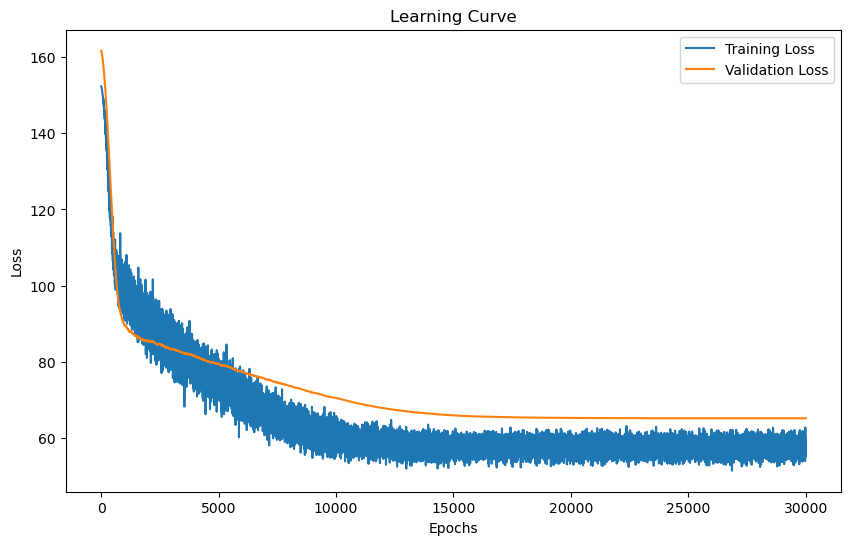

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()